<a href="https://colab.research.google.com/github/jeverton/aml-hw10/blob/master/AML_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 10 - CIFAR10 Image Classification with PyTorch
Brian Hicks (brianjh2) & Joe Everton (everton2)

CS 498 - AML

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.7037, 0.3725, 0.9329],
        [0.7617, 0.0512, 0.3091],
        [0.1317, 0.6936, 0.7461],
        [0.6136, 0.2948, 0.0291],
        [0.1506, 0.0242, 0.4865]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [3]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [0]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10, log_dict=None, next_training_step=0, epoch_offset=0):
  if log_dict == None:
    all_training_loss = np.zeros((0,2))
    all_training_acc = np.zeros((0,2))
    all_test_loss = np.zeros((0,2))
    all_test_acc = np.zeros((0,2))
    training_step = 0
  else:
    all_training_loss = log_dict['loss']['train']
    all_training_acc = log_dict['accuracy']['train']
    all_test_loss = log_dict['loss']['test']
    all_test_acc = log_dict['accuracy']['test']
    training_step = next_training_step
    
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000

  print('First training step: %d' % training_step)

  start = time.clock()
  step_count = 0
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      step_count += 1
      
      if training_step % print_every == 0:
        training_loss /= step_count
        training_acc /= step_count
        step_count = 0
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i + epoch_offset, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i + epoch_offset, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))
  print('Last training step: %d\n' % training_step)
  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}, \
          training_step

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/AML/HW10/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
!mkdir hw10_data

mkdir: cannot create directory ‘hw10_data’: File exists


In [0]:
# Download the data.
from torchvision import datasets, transforms as T

#Original dataset for parts 1 & 2:
# transformations = T.Compose(
#     [T.ToTensor(),
#      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# train_set = datasets.CIFAR10(root='hw10_data/', download=False, transform=transformations)
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='hw10_data/', download=False, transform=T.Compose([transform_augment, transform_normalize]))
test_set = datasets.CIFAR10(root='hw10_data', download=False, train=False, transform=transform_normalize)

Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader
#batch_size was 16 for most trials.
batch_size = 128 # 128 for part 3, 8 for parts 1 & 2.
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [19]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics, steps = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

First training step: 0
  Epoch 0 @ step 0: Train Loss: 4.292547, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.931102, Train Accuracy: 0.332750
  Epoch 0 @ step 2000: Train Loss: 1.811967, Train Accuracy: 0.355625
  Epoch 0 @ step 3000: Train Loss: 1.766811, Train Accuracy: 0.361625
  Epoch 0 @ step 4000: Train Loss: 1.784341, Train Accuracy: 0.364625
  Epoch 0 @ step 5000: Train Loss: 1.757153, Train Accuracy: 0.373500
  Epoch 0 @ step 6000: Train Loss: 1.755492, Train Accuracy: 0.379000
Epoch 0 Test Loss: 1.695291, Test Accuracy: 0.403100, time: 16.5s
  Epoch 1 @ step 7000: Train Loss: 1.752977, Train Accuracy: 0.380000
  Epoch 1 @ step 8000: Train Loss: 1.747382, Train Accuracy: 0.374875
  Epoch 1 @ step 9000: Train Loss: 1.741079, Train Accuracy: 0.381375
  Epoch 1 @ step 10000: Train Loss: 1.737626, Train Accuracy: 0.374500
  Epoch 1 @ step 11000: Train Loss: 1.739141, Train Accuracy: 0.386375
  Epoch 1 @ step 12000: Train Loss: 1.730969, Train Accuracy: 0.383500
E

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

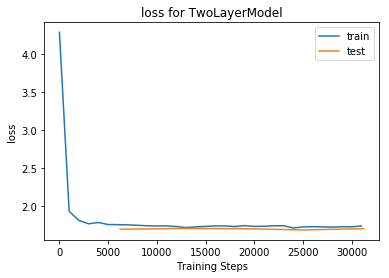

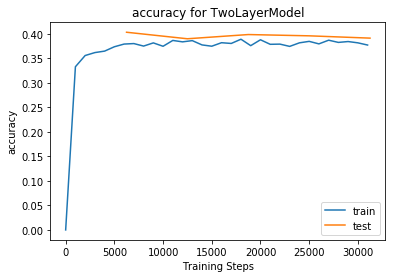

In [20]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [24]:
class ConvModel(nn.Module):
  def __init__(self):
    super(ConvModel, self).__init__()
    self.net = nn.Sequential(
      # 3 x 32 x 32
      nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), 
      nn.ReLU(),
      # 16 x 32 x 32
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      # 16 x 16 x 16
      nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      # 16 x 16 x 16
      Flatten(),
      # 32768
      nn.Linear(16 * 16 * 16, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)
  

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

#metrics = train(model, train_loader, test_loader, loss, optimizer, 2160) # Tried running it over night once.
metrics, step_count = train(model, train_loader, test_loader, loss, optimizer, training_epochs)


First training step: 0
  Epoch 0 @ step 0: Train Loss: 4.240556, Train Accuracy: 0.500000
  Epoch 0 @ step 1000: Train Loss: 1.874241, Train Accuracy: 0.313500
  Epoch 0 @ step 2000: Train Loss: 1.593699, Train Accuracy: 0.421250
  Epoch 0 @ step 3000: Train Loss: 1.530287, Train Accuracy: 0.446750
  Epoch 0 @ step 4000: Train Loss: 1.502787, Train Accuracy: 0.446625
  Epoch 0 @ step 5000: Train Loss: 1.446880, Train Accuracy: 0.476125
  Epoch 0 @ step 6000: Train Loss: 1.422905, Train Accuracy: 0.491375
Epoch 0 Test Loss: 1.342556, Test Accuracy: 0.518100, time: 23.7s
  Epoch 1 @ step 7000: Train Loss: 1.385555, Train Accuracy: 0.504750
  Epoch 1 @ step 8000: Train Loss: 1.380738, Train Accuracy: 0.497750
  Epoch 1 @ step 9000: Train Loss: 1.353362, Train Accuracy: 0.513250
  Epoch 1 @ step 10000: Train Loss: 1.335744, Train Accuracy: 0.523500
  Epoch 1 @ step 11000: Train Loss: 1.343233, Train Accuracy: 0.515375
  Epoch 1 @ step 12000: Train Loss: 1.323395, Train Accuracy: 0.525750
E

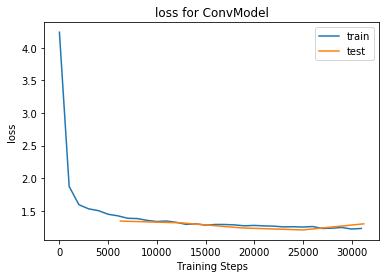

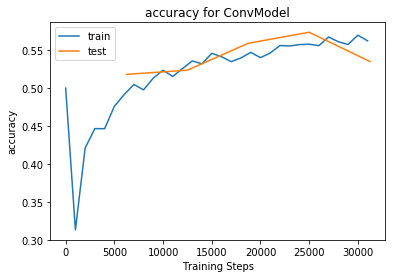

In [25]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

Yes! +10% on accuracy for only a few more seconds of runtime.  It plateaued at 65% if I ran it for many more epochs.

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


### Approach A - VGG
Not run as part of this notebook, but it reached 87.5% accuracy in 150 epochs.

In [0]:
# You Awesome Super Best model code here
#best so far: 77.58%
class AwesomeModel(nn.Module):
  # Your Code Here
  def __init__(self):
    super(AwesomeModel, self).__init__()
    self.net = nn.Sequential(
      nn.Conv2d(3, 512, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(512, 256, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(256, 128, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      #nn.Conv2d(128, 512, 3, stride=2, padding=1),
      #nn.ReLU(),
      #nn.BatchNorm2d(512),
      #nn.MaxPool2d(2),
      #nn.Conv2d(512, 128, 3, stride=1, padding=1),
      #nn.ReLU(),
      nn.Conv2d(128, 32, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Conv2d(32, 16, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 16, 3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      Flatten(),
      #nn.Linear(1024, 2048),
      #nn.ReLU(), 
      #nn.Dropout(p=0.3),
      #nn.Linear(2048, 1024),
      #nn.ReLU(),
      #nn.Linear(256, 1024),
      #nn.ReLU(),
      #nn.Dropout(),
      #nn.Linear(1024, 512),
      #nn.ReLU(),
      #nn.Dropout(),
      #nn.Linear(512, 256),
      #nn.ReLU(),
      #nn.Dropout(),
      nn.Linear(64, 256),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(64, 10))
    
    
  def forward(self, x):
    return self.net(x)
  
  
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'VGGBrian' : [64, 64, 64, 64, 'M', 128, 128, 128, 128, 'M', 256, 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}


#https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
#modified above to include VGGBrian with more convolution layers
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
  
model = VGG('VGGBrian').to(device)

loss = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

metrics, last_training_step = train(model, train_loader, test_loader, loss, optimizer, 150)

### Approach B - resnet

In [0]:
# From https://github.com/KellerJordan/ResNet-PyTorch-CIFAR10
import torch.nn as nn
import torch.nn.functional as F


class ResNet(nn.Module):
    
    def __init__(self, n=7, res_option='A', use_dropout=False):
        super(ResNet, self).__init__()
        self.res_option = res_option
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.layers1 = self._make_layer(n, 16, 16, 1)
        self.layers2 = self._make_layer(n, 32, 16, 2)
        self.layers3 = self._make_layer(n, 64, 32, 2)
        self.avgpool = nn.AvgPool2d(8)
        self.linear = nn.Linear(64, 10)
    
    def _make_layer(self, layer_count, channels, channels_in, stride):
        return nn.Sequential(
            ResBlock(channels, channels_in, stride, res_option=self.res_option, use_dropout=self.use_dropout),
            *[ResBlock(channels) for _ in range(layer_count-1)])
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.layers1(out)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class ResBlock(nn.Module):
    
    def __init__(self, num_filters, channels_in=None, stride=1, res_option='A', use_dropout=False):
        super(ResBlock, self).__init__()
        
        # uses 1x1 convolutions for downsampling
        if not channels_in or channels_in == num_filters:
            channels_in = num_filters
            self.projection = None
        else:
            if res_option == 'A':
                self.projection = IdentityPadding(num_filters, channels_in, stride)
            elif res_option == 'B':
                self.projection = ConvProjection(num_filters, channels_in, stride)
            elif res_option == 'C':
                self.projection = AvgPoolPadding(num_filters, channels_in, stride)
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(channels_in, num_filters, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        if self.use_dropout:
            self.dropout = nn.Dropout(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_dropout:
            out = self.dropout(out)
        if self.projection:
            residual = self.projection(x)
        out += residual
        out = self.relu2(out)
        return out


# various projection options to change number of filters in residual connection
# option A from paper
class IdentityPadding(nn.Module):
    def __init__(self, num_filters, channels_in, stride):
        super(IdentityPadding, self).__init__()
        # with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out

# option B from paper
class ConvProjection(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(ResA, self).__init__()
        self.conv = nn.Conv2d(channels_in, num_filters, kernel_size=1, stride=stride)
    
    def forward(self, x):
        out = self.conv(x)
        return out

# experimental option C
class AvgPoolPadding(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(AvgPoolPadding, self).__init__()
        self.identity = nn.AvgPool2d(stride, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out

In [13]:
# You Awesome Super Best model code here

# Built-in resnet:
#import torchvision.models as models
#model = models.resnet101().to(device)

model = ResNet(n=9).to(device)
loss = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=1e-1, weight_decay=0.0001)

#metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)
awesome_metrics, last_training_step = train(model, train_loader, test_loader, loss, optimizer, 50) #50)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=1e-2, weight_decay=0.0001)
awesome_metrics, last_training_step = train(model, train_loader, test_loader, loss, optimizer, 5, awesome_metrics, last_training_step, 50)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=1e-3, weight_decay=0.0001)
awesome_metrics, last_training_step = train(model, train_loader, test_loader, loss, optimizer, 5, awesome_metrics, last_training_step, 55)


First training step: 0
  Epoch 0 @ step 0: Train Loss: 4.393348, Train Accuracy: 0.070312
Epoch 0 Test Loss: 1.389912, Test Accuracy: 0.499703, time: 41.8s
Epoch 1 Test Loss: 1.034819, Test Accuracy: 0.651305, time: 43.9s
  Epoch 2 @ step 1000: Train Loss: 1.277722, Train Accuracy: 0.534844
Epoch 2 Test Loss: 0.745415, Test Accuracy: 0.743374, time: 44.6s
Epoch 3 Test Loss: 0.860775, Test Accuracy: 0.710938, time: 44.2s
Epoch 4 Test Loss: 0.727671, Test Accuracy: 0.758208, time: 44.1s
  Epoch 5 @ step 2000: Train Loss: 0.681425, Train Accuracy: 0.763008
Epoch 5 Test Loss: 0.726127, Test Accuracy: 0.761274, time: 44.3s
Epoch 6 Test Loss: 0.575063, Test Accuracy: 0.811116, time: 44.5s
  Epoch 7 @ step 3000: Train Loss: 0.526088, Train Accuracy: 0.818303
Epoch 7 Test Loss: 0.670006, Test Accuracy: 0.780756, time: 44.3s
Epoch 8 Test Loss: 0.508641, Test Accuracy: 0.825554, time: 44.2s
Epoch 9 Test Loss: 0.573356, Test Accuracy: 0.809138, time: 44.3s
  Epoch 10 @ step 4000: Train Loss: 0.44

**What changes did you make to improve your model?**

https://github.com/bryanyzhu/two-stream-pytorch/blob/master/models/rgb_resnet.pyOn Resnet-50:
* Learning rate 6e-4 got me up to 70%
* 1e-4 got me to 72%

On Resnet-152:
*  1e-4 got me 50%
*   List item

https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
Resnet-100:
* 1e-4 got me 73%

Resnet-56:
* 1e-4 got me 73%

rgb_resnet152
* 1e-4 got me 75%.

Got me 67%:
model= ResNet110().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=1e-4)


https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16

After lots of changes from https://github.com/KellerJordan/ResNet-PyTorch-CIFAR10, 150 epochs, 77% test accuracy.  That was with lowering LR, ending with lr=6e-5.

Same setup, but lr=1e-1.  50 epochs -> 88% accuracy.  10 more epochs with lr=1e-2 -> 92.5.  10 more epochs with lr=1e-3 -> 92.5.  Reached 92.7.  This is Resnet-56, apparently.

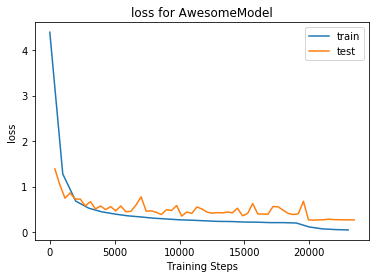

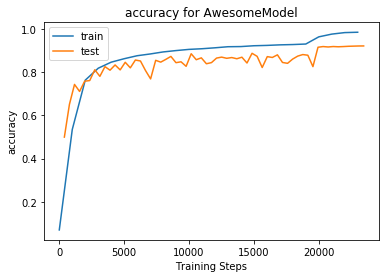

In [14]:
plot_graphs("AwesomeModel", awesome_metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [0]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
from google.colab import files
import torch.utils.data as Data

test_file = 'test_file.pt'
pred_file = 'submission.txt'

f_pred = open(pred_file,'w') 
tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor)  
test_loader = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)

for ele in test_loader:
    x = ele[0]
    x = x.view(-1, 3, 32, 32).to(device)
    with torch.no_grad():
      preds = model(x)
      preds = torch.argmax(model(x), dim=1)
      for pred in preds:
        f_pred.write(str(pred.item()))
        f_pred.write('\n')
    
f_pred.close()
files.download(pred_file)

In [0]:
torch.save(model.state_dict(), './state92.2')

In [0]:
print(model)


# Report

_Images were produced inline above, but copied into this report for convenience._

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

Test (on validation set) accuracy (5 Points):  **39.1%**

Test loss (5 Points): **1.702342**

Training time (5 Points):   **86.3s**

Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

![Part 1 Accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYsAAAEWCAYAAACXGLsWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl8XVW58PHfk3lo0qZNOqVDQmmB%0AlqGUUJEZASljQRSQyytw0V4UFK/CFa6KWPS9qPciDogilivwQkVQqFIsgwwyFBroYFsoTcckbWma%0AJs14knNOnvePvdLunJ4kp2l2Mz3fz2d/ssdznjNkP3uttc9aoqoYY4wxXUnq6wCMMcb0f5YsjDHG%0AdMuShTHGmG5ZsjDGGNMtSxbGGGO6ZcnCGGNMtyxZmCFLRMaIyOsiUi8i/9PX8Qx1InKPiDyU4L5L%0AReSaoGMy+1iyMEPZPGAXkKuq3zyYBxKR/xSRBjeFRCTqW17TO+GCiOwQkVN76/F6GMMcEVEReSJm%0A/Sfc+r/1VWwmOJYsTL8inkP1vZwMrNUe/DJVRFL8y6r6f1V1mKoOA24E3m5fVtUZvRRvn/O97u3A%0Ap0Qk17f5WuCjQx+VORQsWZj9iMjtIrLBVc+sFZHLYrZ/SUQ+8G2f5dZPFJE/iUiViFSLyC/d+rtE%0A5DHf8UXuCjTFLb8qIj8UkTeBJuAwEbne9xwbReTfYmKYKyIrRKTOxTpHRD4nIu/F7PcNEXk2zmv8%0AX7yT23+4q/9zRCRdRO4TkW1uuk9E0t3+Z4pIhYh8S0R2AA8f4Hv6IxH5iZvPFJEWEbnbLee60sgw%0At3y5e19rReQlEZmawOMXiMjz7r3fLSLPisg4t+3/uPfWv/9/isgffPHcJyLlruTyC9/rniMiZSLy%0AXRH5GHjAPUQT8DzwObdfGvAZILa0cYaIvC8ie1zV0Ym+bYeLyJvuM34eyIs59jQRece9D++LyCkJ%0Avt0mCKpqk00dJrwTwHi8i4krgUZgnG9bJXAiIMDheFfoycBK4KdANpABnOqOuQt4zPf4RYACKW75%0AVWArMANIAVKBC4Ep7jnOwDs5zXL7zwb2AOe6GAuBI4F0YDdwlO+5lgOXd/I6/xf4gW95PrAUGA0U%0AAG8Bd7ttZwIR4EfueTK7eP+uA96IWXcBsMzNfwrYALzm2/aOmz8GqHfPlwZ8F1jre692tL+vMY8/%0ABpgLZALDgWeBhW5bNlAHFPv2/wC40M0/ADwFjHDHLgG+57bNca97vosn060rc6+j/TV8xj3nzcDf%0A3LrR7nmvcJ/rdUCVew5xn81/ucc9233GD/m+I9XAOe4zvsAdm+e2LwWu6ev/laE09XkANvX/CVgB%0AzHXzS4Bb4uzzSffPnBJn2110nyzmdxPDM+3PC/wG+Gkn+z0A/NDNzwBqgPRO9v1fOiaLDcAFvuXz%0AgM1u/kygFchI4P26jv2TRS7QAuS49+NWvKqcDLwE9GO33w+BR3zHJbv39SS3HDdZxInhJGC7b/lh%0A4LtuvgTY6U7gKe51Ffr2PQv4wM3PwbtYSPVtb08WAmx2n+czwOV0TBZfAl6PiWs5cBUwDQj530/g%0AT+xLFt8Dfhtz7GvAlW7eksUhnqwayuxHRL7gqnhqRaQWOBrId5sn4p1UY00EtqhqpIdPWx4Tw/mu%0A2mK3i+GCBGIA+D1wtYgI8H+AJ1W1JcEYxgNbfMtb3Lp2VaoaSvCxOlDVOuCfwGnA6cArwDLgE3gl%0Ap9fixaCqUbySXGFXjy8iOSKyQES2ikgd8AL73i/w3pd/cfPXAE+4z2o8Xkluje/zfgavVNBuh6qG%0A47wmBR4Hvo6XnP4Ss0vs+4lbLnTbYt9P/76TgWvaY3JxldDx8zCHkCUL04GITAZ+i3eFOEpVRwCr%0A8a4iwTupT4lzaDkwKbbh12kEsnzLY+Pss7eR2dWXPw38NzDGxbA4gRhQ1aV4V8qnAVcDj8bbrxPb%0A8E5S7Sa5dfvF2EOv4VWdHYVXWnsNr7ptJvBGvBhEJBnv5FrZzWPfDkwATlTVXODT7Hu/2p87Q0RO%0AAj7PvvdlO1410xRVHeGm4ao6yndsV6/7EeBrwJ9VtTVmW+z7Cd57WumeN19EMmK2tSvHK2WM8E3Z%0AqvrTLmIxAbJkYWJl450cqgBE5Hq8kkW7h4BbReQE8RzuEsy7eCeAe0QkW0QyfA2SK4DTRWSSiAwH%0A7ugmhjS8doEqICIi5+Od/Nr9DrheRM4WkSQRKRSRI33bHwF+CYRV9Q0S9wTwHddYnA/cCTzWzTEH%0A4jXgBuB9V2J4Fe/OqTWqusft8wfgMhE5XURS8ZJANVDqe5w09/62T8l41VtNQK2L/Tv+J3algEeB%0AB4FqVS1168PAAuBnIpLvPtOJInJuIi9IVT/Eq6L7fpzNi4DjReSzIpIiIl/ASwjP4901tQ74roik%0AichZeNVb7X4PfM59xsmuEf5sEYl3oWEOAUsWpgNVXQv8D/A28DFeg+ubvu1/xKtXfxyvIfYZYKQ7%0A+V2M1+C9FajAaxxHVV/EOwmuAt4D/tpNDPV4V6tP4rU5XI134mnf/i5wPV5j+h68k7D/CvZRvAR3%0AoCf6H+CdlFfhVRm979b1ln/gJePX3fIKoM23jKquwksov8FLlmfjtRf5q/deBpp90x14pbB8vMTy%0ABl5JLNYjeJ9nbGnr63ilgFK89/NveJ9jQlT1dVXdEWf9x8AlwLddXDcDF6nqHpe8rsBrH9kN/Ae+%0Az0tVN+K1gXwf77cwW4BbsHNWnxHvMzNm8BCRTLwG3Fmqur6v4+kvRCQH7wLgSFXd2tfxmIHFsrQZ%0AjL6Md5uqJYqOvgq8aonC9ES8xkhjBiwR2YzXsHtpH4fSr7gfEjbhVQsZc8CsGsoYY0y3rBrKGGNM%0AtwZNNVR+fr4WFRX1dRjGGDOgvPfee7tUtaC7/QZNsigqKqK0tLT7HY0xxuwlIrG/so/LqqGMMcZ0%0Ay5KFMcaYblmyMMYY0y1LFsYYY7plycIYY0y3LFkYY4zpliULY4wx3Qo0WbjB3te5Ad9v72K/y0VE%0ARaTEt+4Od9w6ETkvyDiHnPqP4eX5sOwh+HAxbFsBDTuhra2vIzPG9FOB/SjPDchyP97IYBXAMhFZ%0A5MZL8O+Xg9dP/Tu+ddPxxumdgTeM4ksiMs2NmWAOVu0WeOM+iH07k1IhZxzkjoPc8ZAz3vubOw5y%0AC71tOeMgJa1v4jbG9Jkgf8E9Gyhzg5ggIguBucDamP3uxhuw/jbfurnAQjd28iYRKXOP93aA8Q4d%0AE2fDd6u80kT9NqjbBnXboa4S6rd7y9tXwUdLINy0//HZBS6pFHqJJF5Sycg99K/LeKIRCNVCcw20%0ANngXAcmpkJQCyWlu3q1LTvXWJSX3ddSmnwsyWRTijaPbrgJvcPq9RGQWMFFVnxOR22KOXRpz7H4D%0A1ovIPGAewKRJk2I3m64kJbuT+zgoPCH+PqreSadue/yksqccyt+B5t37H5uW4xKJL6l0KK2Mh6x8%0ASLJms7hUvUTdXAPN7sTfPoVilvdur/W2tdT14AnFlzhSYubT4iQb33xs8klKPbDjO32sRGNJte/R%0AIdBnfUOJSBJwL3BdTx9DVR/EG1OYkpIS62u9t4lAZp43jZne+X7hZlcicaWSvYnFTZteg/odCVZ7%0AxSSVgV7t1RaF0J79T/qdnvB926OtnT9uUsq+zyYzz3ufRk/3rRvh/U3LhrYIRMPe1Bb2Hjca6Xw+%0A2uqW/fP+490Ubkr8cYMmyfuSSnIqpGZBaqY3pbi/qVmQmrFvPiWj434d1md2vW0IlsSCTBaVwETf%0A8gS3rl0O3jjJr4oIwFhgkYhcksCxpj9JzYSRh3lTZ9qivVDtNb7ztpSgq73CzQlc5cfZFtrT9eOm%0ADdt3cs8YAQVH7H/Cb58yfMtp2V4yHwhUvc8/bkKKk4S6nG9185HO5yMhCIe871LE/W1tgMZd3ny4%0AGSLN7m+oZ68pOd0lnqyYhBSTXLraFjdZxSS35NR+8zkHmSyWAVNFpBjvRH8VcHX7RlXdgzfAPAAi%0A8ipwq6qWikgz8LiI3IvXwD0VeDfAWE3QeqXaqwLK3+2k2mvYvpLIftVebl3mSGit7+KEX9v5tq5O%0AKpLU8YSeXQD507o/4WcMH9ilpkSJQHKKN6Vm9nU0HbW1uYTSvH8iCTftSzrtiaV9PuzbJ/b4hp37%0AtvsfS3twt6Ekd55I/Mkqfxqc8R+9//74BJYsVDUiIjcDS4BkYIGqrhGR+UCpqi7q4tg1IvIkXmN4%0ABLjJ7oQaAnqj2qt+e+fVXt1Jzep4Qh81pfsTfuYIr32mD+rMQ+Eoz63aTl52KmcdMRrpJ1egA0pS%0AEqRleROjgnse1X1Vdx2SSEziiZus/EnJl6xCdd5t8OEmaI1TIu9lg2ZY1ZKSErXxLAa/tdvqaIlE%0AKc7PZkRWF1fl8aq9mqq96ip3sm9JG044bTjDhud761IzDt0LOQjb9zTz6NtbePzdrdQ2hQGYM2Ms%0Ad196NAU56T16zKbWCL/4exnPLq/knOlj+NJphzFxZFZvhj3grNtRzwtrdjB2eAYnTM6jOD97UCZk%0AEXlPVUu63c+ShRkIduwJ8YPn1vLXVdv3rhuRlUrRqGyK87MpGpVNUX6WN5+fTW5GKqFwlG21zVTU%0ANFNe00RFTbObvPmq+haSk4Q5R4/lhlOLmTUprw9fYddUlfe31vLwm5t4fvUOVJVzp4/h2pOLWFWx%0Ah3tf/IistGTuungGc2eOT/ikpqosWbOD+X9Zy7Y9IWYXjWR5eQ1tChcdO44bz5jCUeP6/23QkWgb%0A5TXNbKxqINKmzC4aSV72gVfx1Ta1smjlNv5YWsE/Kzu2N+VlpXLC5DxmTc7jhEl5HDthBJlp3Td0%0Aqyp1zRF2NbagChPyMslI7T8N5JYszKDQGmljwZub+PnL64m0KTeeMYVjCoezeVcjm6ob2bzLm7bt%0A6dimkJOeQn1LpMO61GRh/IhMJuRlMjEviwl5mdQ2hflDaTn1oQjHTxrBDacWM2fGWFKSg6tWikTb%0ASE6ShE7orZE2nl+9nQVvbGJlxR5yMlK46sSJfOGTRR2u/Mt2NnDbUytZvrWWc44azQ8vO4YxuV2X%0AlDbtauSuRWt47aMqjhybw92XHs2JRSPZvqeZ3/1jE0+8u5XG1ihnHlHAjWdM4RPFI/v0ylpV2dXQ%0AyqZdjWysamDjrkY2VjWycVcDW6ubiLTtO5eJwFFjczl5yihOPnwUJxaNJCcjNe7jRqJt/KNsF0+V%0AVvDi2o9pjbYxY3wunz1hApccN56aplbe21Kzd9pQ1QhASpIwY3wusybnccSYHOpDXkLYVd/KroYW%0Aqt18dWML4WjH8+yY3HQmjcxi4sgs729eFpNGefMFw9JJSjp077MlC3NAItE2GlujNLZEaGqNMCY3%0Ao9N/rkSEwlHeWL+L51fvYENVA2cdMZqLjxvHYQXDEn6MN8t2ceezq9lQ1cg5R43mzotmMGlU/KqR%0AUDjKluomNu1qZHN1I9tqm8kflu4lhpFeYhidk0FynH/ChpYIT5WW8/Bbm9lS3UThiEyuPXkyV544%0AieGZPX8PYp9jyeodPLOikjfLdpGSnMTIrDRGZKUyMjuNPN/8iKw08rJSqahp5rGlW9hZ38Jh+dlc%0Ad0oRl8+aQHZ6/KbGaJvy8Jub+MmSdaSnJHHnxTO4fFbhfif4UDjKr14p49evbSQtJYlvnDuNL3xy%0A8n4Jck9TmEeXbubhNzdT3djKzIkjuPGMKXx6+phDdjKLtilvb6jmT8srePmDnexpDu/dlpaSRLEr%0AWR5WkM1hBcMozs9G1TvmrQ3VvLe1htaIl5yPmzCck6fkc/KUUcyanEdFTTNPvVfBn5dX8HFdCyOz%0A05g7czyfO2Ei08d3XpqqaWxlefm+5LGivJZQ2Gu8TktOIn9YGqOGpfv+evP5w9JRlPLdzWzd3US5%0Am7bXhfCfhtNTkjhybI5XgnHTuOHB3RhgycLsFQpHeXfTbl7/qIqyqgYaWyI0tHiJwZuP0BLpeKdG%0AcpJw7ITh3pXZlHxOmJzXbdE5FI7y6roqnl+9nZc/2ElDS4TcjBSKC4axqqIWVTi6MJdLjhvPRceO%0AZ/yI+P8A22qb+eFzH/DcP7czaWQWd10ynU8dOabX3o/ORNuUv3+4k9+9sZGlG3eTlZbM506YwPWn%0AFFOUn33AjxeOtvHG+l38eXklL6zdQSjcxsSRmcyZMZYkEWqaWtndGKa2qZWaplZqmrx53wUyp08r%0A4PpTijhjakHCJ+hNuxr5j6dWsmxzDWceUcB/feaYvSebl9Z+zF1/WUNFTTNzZ47n2xccxehuSiCh%0AcJQ/lpbz4D82Ur67mSkF2Vw6s5DkZCESVSLRNsJt3t9Im3rr2toIR5WxuRmcUJTHrEl5B5R41+2o%0A50/LK3h2+TZ21IXIyUjhvBljmTE+l+L8bKYUDGP8iMy4yT829ve31PDWhmre2rCLlRV7iLYpqclC%0AOKokJwlnHVHAZ0+YyKeOHE1ayoGXKMPRNnbsCTE8K5Wc9JQDLn21RKJU1jRTXuMlka3Vjayq2MPK%0Ain1JaPzwjA7J46hxuaT2UunXksUQpqqs39nA6x9V8dpHVby7aTctkTbSkpOYNnYYw9JTGJaeQrab%0AhqWnkJ2WQnZ6MsPSU8hMS2b9xw0d/rnSkpOYNXnE3iuz4yaOIDU5icaWCK+uq2Lx6u288uFOmlqj%0A5GWlct6Mscw5eiwnT8knLSWJHXtC/HXVNv6ychsrK7y64BOL8rjkuPGcf8w48oel0xpp46E3NvKL%0Al8toU+UrZx7Ov51xWJ/U766u3MPDb25m0cpKIm3KcRNGUDTKqzZorzqYNDKLMbkdSyuqyoryWp5Z%0AXslfVm1nd2MrI7JSuejYcVx2fCGzJuV1eTJpa1PqQxF2N7WSlpJEYScJtTttbcojb2/mR39bR0qS%0A8O/nTuOtDbt46YOdTB09jPlzj+aTUw7s7p9ItI3Fq3fw61c3sHZ7x1+JpyYLKUlJpCQLqclJJCcJ%0AKUnCzvoWom2KCBwxJoeSojxKJo+kpCiPwhGZHd6LnfUhFq3Yxp+XV7JmWx0pScIZ0wr4zKwJnH3U%0A6F75HtSHwizbvJt3Nu6mICeduTMLe3xTQNDC0TY+2F63twTz/paavdWtGalJHDdhBLecM5WTp+R3%0A80hds2QxxNQ0tvLmhl28/lEV/1i/i+3uSzWlIJvTpxVw+rQCTioelVCDnF9DS4Rlm3bz1oZdvLWh%0AmrXb61CFrLRkjhqXy+rKPbRE2sgflsZ5M8ZywTHj+ETxyC7r/DfvauSvq7axaOU2Pvq4geQk4eQp%0Ao6isbWZjVSPnTh/DnRdN7xd34+ysD/HY0q2Ubt7N1t1NbKtt7nDln5actLeqa2xuBu9sqmZzdRNp%0AKUmcO30Ml80s5PRpBT26Yu0NW6ub+NbTq3h7YzVZacl8/ZypXH9K8UFdlaoqja1RUlxC6Kr9pak1%0AwoqttZRuqWHZ5t0s31pLg2tLGpubQUlRHjPGD+edTdX8Y/0uom3KsROGc9nxhVx83Hjyh/XPE3lf%0A2VbbzPtb9yWP288/6oCTfixLFkOAqlK6pYaH/rGRF9d+TJtCbkYKp07N5/SpBZw2raDHV6adqWls%0A5Z1NXn3wqoo9HDdhOOcfM44Ti0Z2WyUQz7od9SxaWclfV20nNTmJb194FGcdMbpXY+5N4Wgb22tD%0AXnWBm8p3N1Fe00RlTTPTxuRw2axC5hw9ltyDaPPpTW2uem1GYW6gdd+JiLYpH+6oo3RzDaVbaijd%0AvJvte0KMH57BpccX8plZhRw+OqdPYxxqLFkMYpFoG8+v3sFDb2xiZXktI7JSuerESZw7fQzHTRge%0A6J08xvS26oYW8rLSDukdQGafRJNFn3UkaA5cXSjMk8vKefjNzVTWNlOcn83dlx7N5bMKyUqzj9IM%0ATKOsqmlAsDPMAFBR08T/vrmZhcvKaWiJMLt4JHddMoOzjxxtV2PGmEPCkkU/EwpH3Y+OGtm0q4FV%0AFXt4+cOdAFx4zDi+eFoxx04Y0cdRGmOGGksWfaSqvoUPttexsarBSw4uQVTWNnfYb/zwDG44tZjr%0ATi7q9HcJxhgTNEsWh4iq8sH2el7+4GNe+nAnK8tr924blp7CYQXZlBTlcUX+RPdrVO+XqdYWYYzp%0AD+xMFKCWSJSlG3fz8gcf8/IHO/eWGo6bOIJbPz2NEyaPZEpBNgU56YOyN0tjzOBhyaKXNbZEeH71%0ADl7+4GNe/6iKxtYoGalJnDa1gK+dfThnHTma0TkDoytsY4xpF2iyEJE5wM/wBj96SFXvidl+I3AT%0AEAUagHmqulZEioAPgHVu16WqemOQsfaGptYIV/92KSsr9jAmN525xxdyzlGjOXlKfr/qktgYYw5U%0AYMlCRJKB+4FzgQpgmYgsUtW1vt0eV9Vfu/0vAe4F5rhtG1R1ZlDx9bZom3LLwhX8s3IPv/j88Vx0%0A7DirWjLGDBpB/tR3NlCmqhtVtRVYCMz176Cq/t7IsoEB+3PyHzy3lhfXfsz3Lp7BxcclPviMMcYM%0ABEEmi0Kg3Ldc4dZ1ICI3icgG4MfA13ybikVkuYi8JiKnxXsCEZknIqUiUlpVVdWbsR+QBW9s4uE3%0AN3PDqcVce3JRn8VhjDFB6fNOhFT1flWdAnwL+I5bvR2YpKrHA98AHheR/UYjUdUHVbVEVUsKCgoO%0AXdA+S9bs4O7n1nLejDH85wVH9UkMxhgTtCCTRSUw0bc8wa3rzELgUgBVbVHVajf/HrABmBZQnD22%0AoryWWxYu57gJI7jvyuN71OuqMcYMBEEmi2XAVBEpFpE04CpgkX8HEZnqW7wQWO/WF7gGckTkMGAq%0AsDHAWA9Y+e4mvvj7ZRTkpPPQtSUHPE6EMcYMJIHdDaWqERG5GViCd+vsAlVdIyLzgVJVXQTcLCLn%0AAGGgBrjWHX46MF9EwkAbcKOq7g4q1gNV29TKtQ+/SziqLLxutg3QYowZ9Gw8iwPUEonyhd+9y/Kt%0AtTx6w2w+cdjBjVJljDF9ycazCICq8q2nVvHOpt387KqZliiMMUNGn98NNZDc++JHPLNiG7eddwRz%0AZ+53F7AxxgxaliwStGzzbn7x9zKuLJnIV86c0tfhGGPMIWXJIkEbdjYA8LVzptqvs40xQ44liwTV%0AhyIA5GZYM48xZuixZJGgulCYJIFsG4zIGDMEWbJIUH0owrD0FJLsV9rGmCHIkkWC6kJhcjJS+zoM%0AY4zpE5YsElTXHCE305KFMWZosmSRoPpQmBxr3DbGDFGWLBJUH4rYnVDGmCHLkkWC6luszcIYM3RZ%0AskhQXbOVLIwxQ5cliwSoKg0tEStZGGOGLEsWCWhqjRJtU2vgNsYMWZYsElAXCgNYycIYM2QFmixE%0AZI6IrBORMhG5Pc72G0XknyKyQkTeEJHpvm13uOPWich5QcbZnb39QmVaycIYMzQFlizcGNr3A+cD%0A04HP+5OB87iqHqOqM4EfA/e6Y6fjjdk9A5gD/Kp9TO6+UG8lC2PMEBdkyWI2UKaqG1W1FVgIzPXv%0AoKp1vsVsoH2M17nAQlVtUdVNQJl7vD5R50oW1mZhjBmqgjz7FQLlvuUK4BOxO4nITcA3gDTgU75j%0Al8Ycu9/QdCIyD5gHMGnSpF4JOp66Zq9kkWslC2PMENXnDdyqer+qTgG+BXznAI99UFVLVLWkoKAg%0AmACxsSyMMSbIZFEJTPQtT3DrOrMQuLSHxwaqfm81lJUsjDFDU5DJYhkwVUSKRSQNr8F6kX8HEZnq%0AW7wQWO/mFwFXiUi6iBQDU4F3A4y1S3WhMClJQkZqnxfEjDGmTwRWr6KqERG5GVgCJAMLVHWNiMwH%0ASlV1EXCziJwDhIEa4Fp37BoReRJYC0SAm1Q1GlSs3akPhcnNTLWxt40xQ1aglfCquhhYHLPuTt/8%0ALV0c+0Pgh8FFl7j6UMTuhDLGDGlWr5IASxbGmKHOkkUC6prDdtusMWZIs2SRACtZGGOGOksWCfCG%0AVLWShTFm6LJkkQArWRhjhjpLFt2Itin1LRFrszDGDGmWLLrR0GKdCBpjjCWLbrR3T24lC2PMUGbJ%0Aoht1zTbwkTHGWLLohg18ZIwxliy6VW8DHxljjCWL7tS3WMnCGGMsWXRjb5uFlSyMMUOYJYtuWJuF%0AMcZYsuhWfShCekoSaSn2Vhljhq5Az4AiMkdE1olImYjcHmf7N0RkrYisEpGXRWSyb1tURFa4aVHs%0AsYdKnRv4yBhjhrLAKuJFJBm4HzgXqACWicgiVV3r2205UKKqTSLyZeDHwJVuW7OqzgwqvkTVWb9Q%0AxhgTaMliNlCmqhtVtRVYCMz176Cqr6hqk1tcCkwIMJ4e8ToRtJKFMWZoCzJZFALlvuUKt64zNwDP%0A+5YzRKRURJaKyKXxDhCReW6f0qqqqoOPOI76UNjuhDLGDHn94iwoItcAJcAZvtWTVbVSRA4D/i4i%0A/1TVDf7jVPVB4EGAkpISDSK2uuYw44dnBvHQxhgzYARZsqgEJvqWJ7h1HYjIOcC3gUtUtaV9vapW%0Aur8bgVeB4wOMtVM2loUxxgSbLJYBU0WkWETSgKuADnc1icjxwG/wEsVO3/o8EUl38/nAKYC/YfyQ%0AsWRhjDEJJgsR+ZOIXCgiCScXVY0ANwNLgA+AJ1V1jYjMF5FL3G4/AYYBf4y5RfYooFREVgKvAPfE%0A3EV1SISjbTSHo9bAbYwZ8hK9ZP4VcD3wcxH5I/Cwqq7r7iBVXQwsjll3p2/+nE6Oews4JsHYAtPe%0AiaA1cBtjhrqESgqq+pKq/gswC9gMvCQib4nI9SIyaC+7rasPY4zxJFytJCKjgOuAL+L9mO5neMnj%0AxUAi6wese3JjjPEkdBYUkT8DRwCPAher6na36Q8iUhpUcH2trtkNqWrdfRhjhrhEL5l/rqqvxNug%0AqiW9GE+/UmclC2OMARKvhpouIiPaF9ytrV8JKKZ+o73NItfaLIwxQ1yiyeJLqlrbvqCqNcCXggmp%0A/7CShTHGeBJNFskiIu0LrkfZtGBC6j/aSxbD0i1ZGGOGtkTPgn/Da8z+jVv+N7duUKsPRchOSyYl%0A2QY+MsYMbYkmi2/hJYgvu+UXgYcCiagfqQ+F7TcWxhhDgslCVduAB9w0ZNQ1R8jNtCooY4xJ9HcW%0AU4H/AqYDGe3rVfWwgOLqF+qyIEDGAAAYW0lEQVRbrGRhjDGQeAP3w3ilighwFvAI8FhQQfUX1uOs%0AMcZ4Ek0Wmar6MiCqukVV7wIuDC6s/sGGVDXGGE+il80trnvy9SJyM94gRsOCC6t/qGu2IVWNMQYS%0AL1ncAmQBXwNOAK4Brg0qqP7CShbGGOPp9rLZ/QDvSlW9FWjAG9di0AuFo7RG26zNwhhjSKBkoapR%0A4NSePLiIzBGRdSJSJiK3x9n+DRFZKyKrRORlEZns23atiKx30yEvxdSFrMdZY4xpl+hl83I35Okf%0Agcb2lar6p84OcCWS+4FzgQpgmYgsihkedTlQoqpNIvJl4MfAlSIyEvgeUAIo8J47tuYAXttBsVHy%0AjDFmn0TbLDKAauBTwMVuuqibY2YDZaq6UVVbgYXAXP8OqvqKqja5xaXABDd/HvCiqu52CeJFYE6C%0AsfYKG/jIGGP2SfQX3D1ppygEyn3LFcAnutj/BuD5Lo4tjD1AROYB8wAmTZrUgxA7Z0OqGmPMPon+%0AgvthvOqgDlT1X3sjCBG5Bq/K6YwDOU5VHwQeBCgpKdkvvoNR19xeDWXJwhhjEq1j+atvPgO4DNjW%0AzTGVwETf8gS3rgMROQf4NnCGqrb4jj0z5thXE4y1V+wrWVg1lDHGJFoN9bR/WUSeAN7o5rBlwFQR%0AKcY7+V8FXB3zOMcDvwHmqOpO36YlwP8VkTy3/GngjkRi7S3WZmGMMfv09Ew4FRjd1Q6qGnG/9l4C%0AJAMLVHWNiMwHSlV1EfATvF+C/9GNrbRVVS9R1d0icjdewgGYr6q7exhrj9SFwiQJZKdZsjDGmETb%0ALOrp2GaxA2+Miy6p6mJgccy6O33z53Rx7AJgQSLxBaE+FGFYegpJSdL9zsYYM8glWg2VE3Qg/U2d%0ADXxkjDF7JfQ7CxG5TESG+5ZHiMilwYXV96x7cmOM2SfRH+V9T1X3tC+oai3eL6wHrbrmsHX1YYwx%0ATqLJIt5+g/qyuz4Usa4+jDHGSTRZlIrIvSIyxU33Au8FGVhfsyFVjTFmn0STxVeBVuAPeH08hYCb%0AggqqP6hrtjYLY4xpl+jdUI3Afl2MD1aqSkNLxLr6MMYYJ9G7oV4UkRG+5TwRWRJcWH2rqTVKtE2t%0AZGGMMU6i1VD57g4oAFy34V3+gnsg29fVh5UsjDEGEk8WbSKytw9wESkiTi+0g8W+UfKsZGGMMZD4%0A7a/fBt4QkdcAAU7DjSMxGNlYFsYY01GiDdx/E5ESvASxHHgGaA4ysL5UZz3OGmNMB4l2JPhF4Ba8%0AcSVWACcBb+MNszro1DW7aihLFsYYAyTeZnELcCKwRVXPAo4Hars+ZOBqb+C2W2eNMcaTaLIIqWoI%0AQETSVfVD4IjgwupbdjeUMcZ0lGiyqHC/s3gGeFFEngW2dHeQiMwRkXUiUiYi+/2oT0ROF5H3RSQi%0AIp+N2RYVkRVuWpRgnL2iPhQmJUnISE307THGmMEt0Qbuy9zsXSLyCjAc+FtXx4hIMnA/cC5QASwT%0AkUWquta321bgOuDWOA/RrKozE4mvt9WFvB5n3eh9xhgz5B1wC66qvpbgrrOBMlXdCCAiC4G5wN5k%0Aoaqb3ba2A40jSDaWhTHGdBRkPUshUO5brnDrEpUhIqUisrSzgZZEZJ7bp7SqqupgYu3AkoUxxnTU%0AnyvlJ6tqCXA1cJ+ITIndQVUfVNUSVS0pKCjotSeuD4XJSbfGbWOMaRdksqgEJvqWJ7h1CVHVSvd3%0AI/Aq3u26h0Rdc8S6+jDGGJ8gk8UyYKqIFItIGnAVkNBdTa5X23Q3nw+cgq+tI2j1IRv4yBhj/AJL%0AFqoaAW4GlgAfAE+q6hoRmS8ilwCIyIkiUgF8DviNiKxxhx+FNzrfSuAV4J6Yu6gCZW0WxhjTUaBn%0ARFVdDCyOWXenb34ZXvVU7HFvAccEGVtnom1KvQ18ZIwxHfTnBu4+0dBinQgaY0wsSxYx2rsnt5KF%0AMcbsY8kiRr11T26MMfuxZBFjb/fkmVayMMaYdpYsYljJwhhj9mfJIkZ9iw2paowxsSxZxKhrtpKF%0AMcbEsmQRo/1uKEsWxhizjyWLGPWhCOkpSaSnJPd1KMYY029YsohRF4pYe4UxxsSwZBHDGyXPqqCM%0AMcbPkkWMeitZGGPMfixZxKgPhcm1xm1jjOnAkkWMuuaw3QlljDExLFnEqA9Z9+TGGBPLkkUMG/jI%0AGGP2F2iyEJE5IrJORMpE5PY4208XkfdFJCIin43Zdq2IrHfTtUHG2S4cbaM5HLUGbmOMiRFYshCR%0AZOB+4HxgOvB5EZkes9tW4Drg8ZhjRwLfAz4BzAa+JyJ5QcXarr0TQWvgNsaYjoIsWcwGylR1o6q2%0AAguBuf4dVHWzqq4C2mKOPQ94UVV3q2oN8CIwJ8BYAX9XH1ayMMYYvyCTRSFQ7luucOt67VgRmSci%0ApSJSWlVV1eNA21n35MYYE9+AbuBW1QdVtURVSwoKCg768doHPrKShTHGdBRksqgEJvqWJ7h1QR/b%0AY3XtbRbW3YcxxnQQZLJYBkwVkWIRSQOuAhYleOwS4NMikucatj/t1gWqvc3CfmdhjDEdBZYsVDUC%0A3Ix3kv8AeFJV14jIfBG5BEBEThSRCuBzwG9EZI07djdwN17CWQbMd+sCZW0WxhgTX6BnRVVdDCyO%0AWXenb34ZXhVTvGMXAAuCjC9WnStZDEu3ZGGMMX4DuoG7t9WHImSnJZOSbG+LMcb42VnRpz4Utjuh%0AjDEmDksWPtYvlDHGxGfJwscbJc9KFsYYE8uShY+VLIwxJj5LFj42pKoxxsRnycKnrtmGVDXGmHgs%0AWfhYycIYY+KzZOGEwlFao23WZmGMMXFYsnBs4CNjjOmcJQunvasPu3XWGGP2Z8nCsU4EjTGmc5Ys%0AHBtS1RhjOmfJwqlrtpKFMcZ0xpKFYwMfGWNM5wK9jBaROcDPgGTgIVW9J2Z7OvAIcAJQDVypqptF%0ApAhvwKR1btelqnpjkLFam4UxQ1M4HKaiooJQKNTXoQQqIyODCRMmkJraswviwM6MIpIM3A+cC1QA%0Ay0Rkkaqu9e12A1CjqoeLyFXAj4Ar3bYNqjozqPhi1YfCiEB2miULY4aSiooKcnJyKCoqQkT6OpxA%0AqCrV1dVUVFRQXFzco8cIshpqNlCmqhtVtRVYCMyN2Wcu8Hs3/xRwtvTRp1UXipCTnkJS0uD8shhj%0A4guFQowaNWrQJgoAEWHUqFEHVXoKMlkUAuW+5Qq3Lu4+bszuPcAot61YRJaLyGsiclq8JxCReSJS%0AKiKlVVVVBxVsnQ18ZMyQNZgTRbuDfY39tYF7OzBJVY8HvgE8LiK5sTup6oOqWqKqJQUFBQf1hNY9%0AuTHGdC7IZFEJTPQtT3Dr4u4jIinAcKBaVVtUtRpAVd8DNgDTAozV9ThrJQtjzKFVW1vLr371qwM+%0A7oILLqC2tjaAiOILMlksA6aKSLGIpAFXAYti9lkEXOvmPwv8XVVVRApcAzkichgwFdgYYKzUhyLk%0AZlrJwhhzaHWWLCKRSJfHLV68mBEjRgQV1n4COzuqakREbgaW4N06u0BV14jIfKBUVRcBvwMeFZEy%0AYDdeQgE4HZgvImGgDbhRVXcHFStAfUuYnIycIJ/CGNPPff8va1i7ra5XH3P6+Fy+d/GMTrfffvvt%0AbNiwgZkzZ5KamkpGRgZ5eXl8+OGHfPTRR1x66aWUl5cTCoW45ZZbmDdvHgBFRUWUlpbS0NDA+eef%0Az6mnnspbb71FYWEhzz77LJmZmb36OgK9lFbVxcDimHV3+uZDwOfiHPc08HSQscWyNgtjTF+45557%0AWL16NStWrODVV1/lwgsvZPXq1XtvcV2wYAEjR46kubmZE088kcsvv5xRo0Z1eIz169fzxBNP8Nvf%0A/pYrrriCp59+mmuuuaZX47SzI949yPWhiLVZGDPEdVUCOFRmz57d4bcQP//5z/nzn/8MQHl5OevX%0Ar98vWRQXFzNzpveztBNOOIHNmzf3elyWLICm1ijRNrWShTGmz2VnZ++df/XVV3nppZd4++23ycrK%0A4swzz4z7W4n09PS988nJyTQ3N/d6XP311tlDal9XH1ayMMYcWjk5OdTX18fdtmfPHvLy8sjKyuLD%0ADz9k6dKlhzi6fexSmn0DH1nJwhhzqI0aNYpTTjmFo48+mszMTMaMGbN325w5c/j1r3/NUUcdxRFH%0AHMFJJ53UZ3Ha2RFfj7M2Sp4xpg88/vjjcdenp6fz/PPPx93W3i6Rn5/P6tWr966/9dZbez0+sGoo%0AwOsXCqxkYYwxnbFkwb42i1xLFsYYE5clC7yuPsAGPjLGmM5YssDuhjLGmO5YssBr4E5JEjJS7e0w%0Axph47OzIvq4+hkKf9sYY0xOWLPB+Z2G3zRpj+kJPuygHuO+++2hqaurliOKzZIF1ImiM6TsDJVnY%0AGRKvzSIn3UoWxgx5z98OO/7Zu4859hg4/55ON/u7KD/33HMZPXo0Tz75JC0tLVx22WV8//vfp7Gx%0AkSuuuIKKigqi0Sjf/e53+fjjj9m2bRtnnXUW+fn5vPLKK70bdwxLFkBdc4Si/Ky+DsMYMwT5uyh/%0A4YUXeOqpp3j33XdRVS655BJef/11qqqqGD9+PM899xzg9Rk1fPhw7r33Xl555RXy8/MDj9OSBa5k%0AYbfNGmO6KAEcCi+88AIvvPACxx9/PAANDQ2sX7+e0047jW9+85t861vf4qKLLuK000475LEF2mYh%0AInNEZJ2IlInI7XG2p4vIH9z2d0SkyLftDrd+nYicF2Sc1mZhjOkPVJU77riDFStWsGLFCsrKyrjh%0AhhuYNm0a77//Pscccwzf+c53mD9//iGPLbBk4cbQvh84H5gOfF5EpsfsdgNQo6qHAz8FfuSOnY43%0AxOoMYA7wq/YxuXtbW5vS0BqxkoUxpk/4uyg/77zzWLBgAQ0NDQBUVlayc+dOtm3bRlZWFtdccw23%0A3XYb77///n7HBi3Iy+nZQJmqbgQQkYXAXGCtb5+5wF1u/ingl+L92GEusFBVW4BNbozu2cDbvR1k%0AfUsEVesXyhjTN/xdlJ9//vlcffXVfPKTnwRg2LBhPPbYY5SVlXHbbbeRlJREamoqDzzwAADz5s1j%0Azpw5jB8/fkA3cBcC5b7lCuATne2jqhER2QOMcuuXxhxbGPsEIjIPmAcwadKkHgWpqlx07Dimjcnp%0A0fHGGHOwYrsov+WWWzosT5kyhfPO2782/qtf/Spf/epXA42t3YC+nFbVB4EHAUpKSrQnjzEiK41f%0AXj2rV+MyxpjBJsgG7kpgom95glsXdx8RSQGGA9UJHmuMMeYQCTJZLAOmikixiKThNVgvitlnEXCt%0Am/8s8HdVVbf+Kne3VDEwFXg3wFiNMUOYd9oZ3A72NQZWDeXaIG4GlgDJwAJVXSMi84FSVV0E/A54%0A1DVg78ZLKLj9nsRrDI8AN6lqNKhYjTFDV0ZGBtXV1YwaNWrQdiaqqlRXV5ORkdHjx5DBklFLSkq0%0AtLS0r8Mwxgww4XCYiooKQqFQX4cSqIyMDCZMmEBqasefCYjIe6pa0t3xA7qB2xhjDlZqairFxcV9%0AHUa/Z73OGmOM6ZYlC2OMMd2yZGGMMaZbg6aBW0SqgC0H8RD5wK5eCqcvDPT4wV5DfzDQ4wd7DQdq%0AsqoWdLfToEkWB0tEShO5I6C/Gujxg72G/mCgxw/2GoJi1VDGGGO6ZcnCGGNMtyxZ7PNgXwdwkAZ6%0A/GCvoT8Y6PGDvYZAWJuFMcaYblnJwhhjTLcsWRhjjOnWkE8WIjJHRNaJSJmI3N7X8cQSkc0i8k8R%0AWSEipW7dSBF5UUTWu795br2IyM/da1klIrN8j3Ot23+9iFzb2fP1UswLRGSniKz2reu1mEXkBPee%0AlLlje7Wr0E7iv0tEKt3nsEJELvBtu8PFsk5EzvOtj/vdct32v+PW/8F14d+rRGSiiLwiImtFZI2I%0A3OLWD4jPoYv4B8znICIZIvKuiKx0r+H7XT2veEMy/MGtf0dEinr62gKhqkN2wus6fQNwGJAGrASm%0A93VcMTFuBvJj1v0YuN3N3w78yM1fADwPCHAS8I5bPxLY6P7mufm8AGM+HZgFrA4iZryxTU5yxzwP%0AnH8I4r8LuDXOvtPd9yYdKHbfp+SuvlvAk8BVbv7XwJcD+AzGAbPcfA7wkYt1QHwOXcQ/YD4H974M%0Ac/OpwDvu/Yr7vMBXgF+7+auAP/T0tQUxDfWSxWygTFU3qmorsBCY28cxJWIu8Hs3/3vgUt/6R9Sz%0AFBghIuOA84AXVXW3qtYALwJzggpOVV/HG5+k12N223JVdal6/0mP+B4ryPg7MxdYqKotqroJKMP7%0AXsX9brmr708BT7nj/e9Fr1HV7ar6vpuvBz7AG8d+QHwOXcTfmX73Obj3ssEtprpJu3he/2fzFHC2%0Ai/OAXltvvga/oZ4sCoFy33IFXX8h+4ICL4jIeyIyz60bo6rb3fwOYIyb7+z19IfX2VsxF7r52PWH%0Aws2uimZBe/UNBx7/KKBWVSMx6wPjqjOOx7uyHXCfQ0z8MIA+BxFJFpEVwE68RLuhi+fdG6vbvsfF%0A2S/+r4d6shgITlXVWcD5wE0icrp/o7uqG1D3Pw/EmIEHgCnATGA78D99G05iRGQY8DTwdVWt828b%0ACJ9DnPgH1OegqlFVnQlMwCsJHNnHIfXYUE8WlcBE3/IEt67fUNVK93cn8Ge8L9zHrhoA93en272z%0A19MfXmdvxVzp5mPXB0pVP3b/+G3Ab/E+B7qJM976arwqnpSY9b1ORFLxTrT/T1X/5FYPmM8hXvwD%0A8XNwcdcCrwCf7OJ598bqtg93cfaP/+ugGkMGwoQ3UuBGvEaj9gaiGX0dly++bCDHN/8WXlvDT+jY%0ASPljN38hHRsp33XrRwKb8Boo89z8yIBjL6JjA3Gvxcz+DasXHIL4x/nm/x2vDhlgBh0bHzfiNTx2%0A+t0C/kjHBs6vBBC/4LUj3BezfkB8Dl3EP2A+B6AAGOHmM4F/ABd19rzATXRs4H6yp68tiCmwk8VA%0AmfDuAvkIry7x230dT0xsh7kvwEpgTXt8ePWYLwPrgZd8/7wC3O9eyz+BEt9j/Stew1gZcH3AcT+B%0AV0UQxqtHvaE3YwZKgNXumF/ieiIIOP5HXXyrgEUxJ61vu1jW4bsjqLPvlvtc33Wv649AegCfwal4%0AVUyrgBVuumCgfA5dxD9gPgfgWGC5i3U1cGdXzwtkuOUyt/2wnr62ICbr7sMYY0y3hnqbhTHGmARY%0AsjDGGNMtSxbGGGO6ZcnCGGNMtyxZGGOM6ZYlCzMoicgoX8+kO2J6Kk2od1EReVhEjuhmn5tE5F96%0AKea5Lr6VrrfVL7r1nxGRAfvLXzM42K2zZtATkbuABlX975j1gvc/0NYngXWMJR3vB28lqrrNLU9W%0A1Y9E5DHgKVV9pm+jNEOZlSzMkCIih7ur9v+H90PHcSLyoIiUujEH7vTt+4aIzBSRFBGpFZF73FX/%0A2yIy2u3zAxH5um//e9wYButE5GS3PltEnnbP+5R7rpkxoQ3H+2HcbgD1ehj9SEROw/vh1U9dqaNI%0ARKaKyBLXueTrIjLNPc9jIvKAW/+RiJzv1h8jIsvc8atE5LBA32QzKFmyMEPRkcBPVXW6en1v3a6q%0AJcBxwLkiMj3OMcOB11T1OOBtvF81xyOqOhu4DWhPPF8FdqjqdOBuvB5UO1Cv768lwBYReVxEPi8i%0ASar6D2Ax8O+qOlNVNwMP4nURcQJwB96vp9tNBE4ELgYedCWUrwD/rV6HdicC2xJ5k4zxS+l+F2MG%0AnQ2qWupb/ryI3ID3/zAeb7CZtTHHNKvq827+PeC0Th77T759itz8qcCPAFR1pYisiXegql4nIscC%0A5+D123Q28EX/PiIyAq8/pqdl38B0/v/jJ1212joRKQem4vUp9h0RmQz8SVXLOondmE5ZsjBDUWP7%0AjIhMBW4BZqtqrWsfyIhzTKtvPkrn/zstCezTKVVdBawSkcfxBvz5YswuAuxypYS4D7H/Q+qjIvI2%0AXmeBfxORf1VvgCdjEmbVUGaoywXqgTrfyHC97U3gCvDaD/BKLh2ISG7MWCUzgS1uvh5vaFHUG61u%0Au4hc5o5LEpHjfMd9TjzT8Kqk1ovIYapapqo/A/6K18GdMQfEShZmqHsfr8rpQ7yT85sBPMcvgEdE%0AZK17rrV4o6D5CXCHiPwWaAYa2Ncu8gTwGxH5Jt4QnFcBD7i7vNKAx/B6JgZvPINSYBgwT1VbReRq%0AEfk8Xi+62/DGsTbmgNits8YEzA1kk6KqIVft9QIwVfcNrdlbz2O32JrAWMnCmOANA152SUOAf+vt%0ARGFM0KxkYYwxplvWwG2MMaZbliyMMcZ0y5KFMcaYblmyMMYY0y1LFsYYY7r1/wGi6Beglb64YQAA%0AAABJRU5ErkJggg==)

- Plot a graph of loss on validation set vs training steps (5 Points)

![Part 1 Loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3XmcXGWd7/HPr5auSi/ZEyAEkqAI%0AIkiAgHhBB0UGggg6IKDiihfHhYuOcoURGfF67wt1Rr2MI4gDc0VQQXBBBQU0CI4sE2IIYQ8IZgGy%0AQCe9d1fV7/5xnqqcrlR3OklXV3fO9/3qetWps/5OVfX5ned5Tj3H3B0RERGAVKMDEBGR8UNJQURE%0AKpQURESkQklBREQqlBRERKRCSUFERCqUFGSnmNlzZva2MdrWJDP7pZltNrOfjMU2ZWhm9vdmdtcI%0A5/2xmV1S75hk9CgpyERwBrAHMMPd370rKzKz95lZZ3j0mFkp9rpzdMIFM7vfzM4ZrfXtZAwHmpmb%0A2X1V4+eYWcHMnmhUbDJ+KSnIRDAPeMrdCzu6oJll4q/d/QZ3b3X3VmAxsK78OozbLcT2uwjMMrP9%0AY5PPAZ4Z+6hkIlBSkF1mZjkz+5aZrQuPb5lZLkybaWa/MrN2M3vZzO41s1SY9nkzW2tmHWb2pJkd%0AX2PdlwGXAmeFs/lzzSxlZpeY2fNmtt7MrjOzKWH++eHs+Fwz+yvw+x3cl4/Hq6jMbLWZ/SD2er2Z%0AHRiG/8bMloVqrfvN7MgRrD9jZreY2UvhPVliZgeEaW8K27PY/O81swfCcNrMvmhmz5rZRjO7wcym%0AhmkHhrP//25mq4HbYpu9HvhA7PX7geuq4jokfDbtZrbCzBbHps02s9vMbEsodcyrWvZgM/u9mb1i%0AZo+b2Tu39z7I+KWkIKPhC8DRwELgUOAooFyP/FlgDTCLqAroHwEPB8JPAUe6extwIvBc9Yrd/Z+A%0A/wPcGM7mrwE+FB5vAfYDWoFvVy36N8Brw3p3xB/CspjZfkABODa8PggoufsTZjYb+CVwOTADuAq4%0ArZyctuMXwKuAPYEngO+H8X8E+oHjYvPGD+CfA/42xDMXGAC+GZs3DbwBOAA4LTb+OuB9FjkcKAEP%0AlyeaWR74NfBzos/pQuAnZrYgzHI18DLR5/dx4COxZScDdwLXADOJks+1ZvbqEbwPMg4pKchoeB/w%0AZXdf7+4bgMuIDmYQHbj2Aua5+4C73+tRh1tFIAccZGZZd3/O3UdapfE+4Bvu/qy7dwIXA2dXVRV9%0Ayd273L1nR3bE3R+DSgJ4M9GBv8PM5hMli3vCrKcBy939JncvuPv/I0p+i6vXWbX+grtf5+6d7t5L%0A9F4dZWb58L5cR1S9g5ntEbZ5Y1j874GL3H1dbNmz4iUL4FJ3747vt7s/C6wL+/MBqkoJwJsAJ3pP%0AB9z9t0QH+rNCwjgVuMTde9x9OXBDbNl3AStDtVzR3f8rvGenD/c+yPilpCCjYQ7wfOz182EcwNeB%0AVcAdodrjIgB3XwV8GvgSsD5cpTKHkam1vQzRmWzZ6h3diZh7iM7W30xUcrib6OD8N+F1rRjKcew9%0A3IpD9dG/hPdiC1FJwYhKGxAdsP8uHIzfA9zp7hvDgX8fotJIu5m1A38m+h8uL1ty93VDbPo6ojP8%0AdzP4oF7el7/64N4xy/uyZ4hvddW0snnAm8sxhbhOJzoRkAlISUFGwzoG1zPvG8bh7h3u/ll334/o%0AjPMfym0H7v5Ddz82LOvAV3dhewXgpdi4Xen+9w9ESeFNRAmiXKUUTwrVMZTjWLuddX8YOIGo6msK%0AcGAYbwDu/hdgBfAOotLWD8J4D+t+q7tPjT3y7r4xrGO4fb6JKCGscPcXq6atC7HX2pcXw3r3qZpW%0Athq4oyqmVnf/9LDvgoxbSgoyGn4EXGJms8xsJlHD8PUAZnaKmb06nOluJqo2KpnZAWb21tAg3Qv0%0AENV1j3R7nzGzBWbWytY2hx2+OmkIfwBOAvpDddgfiM5+s8CjYZ5bgcPM7Ixw9v8BooPl7bH1ZM0s%0AH3tkgDai/d0EtABfqbH964AvErWX/DI2/irgcjPbByoNwO8YyQ65eztRovt4jcn3Aikz+3TYlxOI%0A2i5uCtVUvwQus+j3Iq8nqr4r+3l4H84ys6yZNZnZ0Wb2mpHEJeOPkoKMhq8AS4nOcB8BlrH1YLc/%0AcBfQCdwHfMfdlxC1J1wObCQ6G51N1DYwEtcSnUHfA/yF6CB7/mjsSPAIUVvIPQDhTHw1UG4Pwd1f%0AIir5fIHoAP8p4BR331wVZ0/scRVRg+wGon1+hKhxudpPgFcTHZT7YuO/RvRe/t7MOoA/AYePdKfc%0A/UF3f67G+F7gFKLfg2wCvgGcFdoiAD5GVDX3EvBd4D9iy75C1Jj/YeAFolLHV4gSqExAppvsiIwv%0AFl2y+1fgbHevlTRE6kYlBZHx5z3AFiUEaYTM9mcRkbFiZvcD84H3NjgUSShVH4mISIWqj0REpGLC%0AVR/NnDnT58+f3+gwREQmlIceemiju8/a3nwTLinMnz+fpUuXNjoMEZEJxcyqf4Ffk6qPRESkQklB%0AREQqlBRERKRiwrUpiIjsjIGBAdasWUNvb2+jQ6mrfD7P3LlzyWZ3rqcRJQURSYQ1a9bQ1tbG/Pnz%0AGXwLit2Hu7Np0ybWrFnDggULtr9ADao+EpFE6O3tZcaMGbttQgAwM2bMmLFLpSElBRFJjN05IZTt%0A6j4mJik8+WIH//zbJ3m5q7/RoYiIjFuJSQp/2djJt5es4qUtu3cjk4iMT+3t7XznO9/Z4eVOPvlk%0A2tvb6xBRbYlJCq25qCW+s2+0bs4lIjJyQyWFQmH4Y9Jtt93G1KlT6xXWNhJz9VFrPtrVzl4lBREZ%0AexdddBHPPPMMCxcuJJvNks/nmTZtGk888QRPPfUU73znO1m9ejW9vb1ccMEFnHfeecDWrn06OztZ%0AvHgxxx57LH/605/Ye++9+cUvfsGkSZNGNc7kJIVctKsdKimIJN5lv3yUx9ZtGdV1HjRnMv/0jtcN%0AOf3yyy9n5cqVLF++nLvvvpu3v/3trFy5snLp6LXXXsv06dPp6enhyCOP5PTTT2fGjBmD1vH000/z%0Aox/9iO9973uceeaZ3HLLLZxzzjmjuh+JSQptKimIyDhy1FFHDfotwRVXXMHPfvYzAFavXs3TTz+9%0ATVJYsGABCxcuBOCII47gueeeG/W4EpMUyiWFzr6BBkciIo023Bn9WGlpaakM33333dx1113cd999%0ANDc3c9xxx9X8rUEul6sMp9Npenp6Rj2uxDQ0NzelMVNJQUQao62tjY6OjprTNm/ezLRp02hubuaJ%0AJ57g/vvvH+PotkpMScHMaG3KqE1BRBpixowZHHPMMRx88MFMmjSJPfbYozLtpJNO4qqrruK1r30t%0ABxxwAEcffXTD4kxMUoDoCiSVFESkUX74wx/WHJ/L5bj99ttrTiu3G8ycOZOVK1dWxn/uc58b9fgg%0AQdVHELUrdPUrKYiIDCVZSSGfoUMlBRGRISUrKeQy+kWziMgwEpUU2tSmICIyrEQlBZUURESGl7Ck%0AkFVJQURkGMlKCvkMnf0FSiVvdCgikjA723U2wLe+9S26u7tHOaLaEpUU2nIZ3KF7oNjoUEQkYSZK%0AUkjcj9cg6uqi3BeSiMhYiHedfcIJJzB79mxuuukm+vr6eNe73sVll11GV1cXZ555JmvWrKFYLPLF%0AL36Rl156iXXr1vGWt7yFmTNnsmTJkrrGmagj4+BO8fKNDUZEGuf2i+DFR0Z3nXseAosvH3JyvOvs%0AO+64g5tvvpkHH3wQd+fUU0/lnnvuYcOGDcyZM4df//rXQNQn0pQpU/jGN77BkiVLmDlz5ujGXEPd%0Aq4/MLG1mfzazX9WYljOzG81slZk9YGbz6xlL5Z4KamwWkQa64447uOOOOzjssMM4/PDDeeKJJ3j6%0A6ac55JBDuPPOO/n85z/Pvffey5QpU8Y8trEoKVwAPA5MrjHtXOAVd3+1mZ0NfBU4q16BVKqPdFmq%0ASLINc0Y/Ftydiy++mI997GPbTFu2bBm33XYbl1xyCccffzyXXnrpmMZW15KCmc0F3g78+xCznAZ8%0APwzfDBxvZlaveCrVRyopiMgYi3edfeKJJ3LttdfS2dkJwNq1a1m/fj3r1q2jubmZc845hwsvvJBl%0Ay5Zts2y91buk8C3gfwJtQ0zfG1gN4O4FM9sMzAA2xmcys/OA8wD23XffnQ5ma5uCkoKIjK1419mL%0AFy/mve99L2984xsBaG1t5frrr2fVqlVceOGFpFIpstksV155JQDnnXceJ510EnPmzJm4Dc1mdgqw%0A3t0fMrPjdmVd7n41cDXAokWLdvpHBm2qPhKRBqruOvuCCy4Y9PpVr3oVJ5544jbLnX/++Zx//vl1%0Aja2sntVHxwCnmtlzwI+Bt5rZ9VXzrAX2ATCzDDAF2FSvgFpUfSQiMqy6JQV3v9jd57r7fOBs4Pfu%0Afk7VbLcCHwzDZ4R56vZz42w6RT6bUklBRGQIY/6LZjP7spmdGl5eA8wws1XAPwAX1Xv7rbmsbskp%0AklB1POccN3Z1H8fkx2vufjdwdxi+NDa+F3j3WMRQpu6zRZIpn8+zadMmZsyYQR0vcmwod2fTpk3k%0A8zv/49xE/aIZ1H22SFLNnTuXNWvWsGHDhkaHUlf5fJ65c+fu9PLJTAoqKYgkTjabZcGCBY0OY9xL%0AVC+pEO7TrJKCiEhNyUsKuUzoEE9ERKolMymo+khEpKbkJYV81NCchEvTRER2VPKSQi7DQNHpK5Qa%0AHYqIyLiTuKRQ7v+oS43NIiLbSFxSUE+pIiJDS2xS0N3XRES2lbykoO6zRUSGlLik0JbLAuo+W0Sk%0AlsQlBZUURESGlrykUG5TUFIQEdlG4pJC5Zacqj4SEdlG4pJCLpMikzL1fyQiUkPikoKZ0aL+j0RE%0AakpcUoCoXUFtCiIi20pkUtAtOUVEaktkUtAtOUVEaktmUshn1CGeiEgNyUwKalMQEakpkUlBbQoi%0AIrUlMimoTUFEpLaEJoUs3f1FiiXdklNEJC6ZSUGd4omI1JTIpNCmu6+JiNSUyKTQqk7xRERqSmZS%0AqJQU1CmeiEhc3ZKCmeXN7EEze9jMHjWzy2rM8yEz22Bmy8Pjo/WKJ65F92kWEakpU8d19wFvdfdO%0AM8sCfzSz2939/qr5bnT3T9Uxjm20qaFZRKSmuiUFd3egM7zMhse4uAa0Un2kkoKIyCB1bVMws7SZ%0ALQfWA3e6+wM1ZjvdzFaY2c1mts8Q6znPzJaa2dINGzbscly6JFVEpLa6JgV3L7r7QmAucJSZHVw1%0Ayy+B+e7+euBO4PtDrOdqd1/k7otmzZq1y3G1NCkpiIjUMiZXH7l7O7AEOKlq/CZ37wsv/x04Yizi%0ASaeMlqa0qo9ERKrU8+qjWWY2NQxPAk4AnqiaZ6/Yy1OBx+sVT7XWvPo/EhGpVs+rj/YCvm9maaLk%0Ac5O7/8rMvgwsdfdbgf9hZqcCBeBl4EN1jGcQdZ8tIrKtel59tAI4rMb4S2PDFwMX1yuG4bTms6o+%0AEhGpkshfNEPU/5Gqj0REBktsUmjN6UY7IiLVkpsU1NAsIrKN5CaFXIaOXnWIJyISl+ik0NlXIOqN%0AQ0REIMlJIZ+h5NAzUGx0KCIi40Zyk4I6xRMR2UZik0K5+2z9gE1EZKvEJoVySaFLSUFEpCLxSUHV%0ARyIiWyU3Kaj6SERkG4lNCm25LKCSgohIXGKTgu6+JiKyrcQmhZZcGlBSEBGJS2xSyGXSNGVSdKj6%0ASESkIrFJAcrdZ6v/IxGRskQnhda8us8WEYlLdFJoaVL32SIicYlOCq35jNoURERiEp0UdEtOEZHB%0AEp0UdPc1EZHBkp0Uchl1iCciEpPspKA2BRGRQRKdFNpyGfoKJfoLpUaHIiIyLiQ6KeieCiIigyU7%0AKeRDT6lKCiIiQNKTQigpqF1BRCQyoqRgZheY2WSLXGNmy8zsb+sdXL21qftsEZFBRlpS+Ii7bwH+%0AFpgGvB+4vG5RjZHKLTnVKZ6ICDDypGDh+WTgB+7+aGxc7QXM8mb2oJk9bGaPmtllNebJmdmNZrbK%0AzB4ws/k7EvyuqtySU9VHIiLAyJPCQ2Z2B1FS+K2ZtQHbu46zD3irux8KLAROMrOjq+Y5F3jF3V8N%0AfBP46shD33VbSwpKCiIiMPKkcC5wEXCku3cDWeDDwy3gkc7wMhseXjXbacD3w/DNwPFmNmwJZDRV%0AkoJKCiIiwMiTwhuBJ9293czOAS4BNm9vITNLm9lyYD1wp7s/UDXL3sBqAHcvhHXOqLGe88xsqZkt%0A3bBhwwhD3r7mpjRmKimIiJSNNClcCXSb2aHAZ4FngOu2t5C7F919ITAXOMrMDt6ZIN39andf5O6L%0AZs2atTOrqMnMaM2pqwsRkbKRJoWCuztRdc+33f3fgLaRbsTd24ElwElVk9YC+wCYWQaYAmwa6XpH%0AQ5s6xRMRqRhpUugws4uJLkX9tZmliNoIhmRms8xsahieBJwAPFE1263AB8PwGcDvQ/IZM+o+W0Rk%0Aq5EmhbOIrib6iLu/SFQd9PXtLLMXsMTMVgD/RdSm8Csz+7KZnRrmuQaYYWargH8gasweU6260Y6I%0ASEVmJDO5+4tmdgNwpJmdAjzo7sO2Kbj7CuCwGuMvjQ33Au/esZBHV2s+y5Ye/XhNRARG3s3FmcCD%0ARAfwM4EHzOyMegY2VnRLThGRrUZUUgC+QPQbhfUQtRcAdxH9tmBCa81l9DsFEZFgpG0KqXJCCDbt%0AwLLjmhqaRUS2GmlJ4Tdm9lvgR+H1WcBt9QlpbJUbmkslJ5Uasx9Ti4iMSyNtaL7QzE4Hjgmjrnb3%0An9UvrLFT7j67q79AW37Yq2xFRHZ7Iy0p4O63ALfUMZaGaIl1iqekICJJN2xSMLMOtu3EDqJus93d%0AJ9clqjE0qFO8KQ0ORkSkwYZNCu4+4q4sJqrKPRXU2CwisntcQbQr2tR9tohIReKTQrmkoE7xRESU%0AFCptCqo+EhFRUqAtF11xpOojERElBVpyaUB3XxMRASUFMukUk7JpJQUREZQUgKixWbfkFBFRUgDU%0AfbaISJmSAqGn1F7daEdEREkB3ZJTRKRMSYGoUzy1KYiIKCkAalMQESlTUkB3XxMRKVNSYOt9mt1r%0A9RIuIpIcSgpEJYVCyekrlBodiohIQykpEOs+W1VIIpJwSgps7T5bneKJSNIpKQCt5Z5SVVIQkYRT%0AUiB2TwWVFEQk4ZQUgLa82hREREBJAdhaUujsU/9HIpJsdUsKZraPmS0xs8fM7FEzu6DGPMeZ2WYz%0AWx4el9YrnuGooVlEJJKp47oLwGfdfZmZtQEPmdmd7v5Y1Xz3uvspdYxju3SfZhGRSN1KCu7+grsv%0AC8MdwOPA3vXa3q7IZVJkUqaSgogk3pi0KZjZfOAw4IEak99oZg+b2e1m9rohlj/PzJaa2dINGzbU%0AIz71fyQiwhgkBTNrBW4BPu3uW6omLwPmufuhwL8CP6+1Dne/2t0XufuiWbNm1SXOcv9HIiJJVtek%0AYGZZooRwg7v/tHq6u29x984wfBuQNbOZ9YxpKK25jNoURCTx6nn1kQHXAI+7+zeGmGfPMB9mdlSI%0AZ1O9YhpOW14lBRGRel59dAzwfuARM1sexv0jsC+Au18FnAF83MwKQA9wtjeo/+rWXIZNXf2N2LSI%0AyLhRt6Tg7n8EbDvzfBv4dr1i2BGt+SzPb+pudBgiIg2lXzQHalMQEVFSqFCbgoiIkkJFay5Dz0CR%0AQlF3XxOR5FJSCMpdXXT1FRsciYhI4ygpBOVO8TrUU6qIJJiSQqD7NIuIKClUtOTUfbaIiJJCsLX6%0ASElBRJJLSSFoU0lBRERJoaxV92kWEVFSKGtVSUFEREmhrKVJJQURESWFIJWy6EY7SgoikmBKCjG6%0A+5qIJJ2SQozu0ywiSaekEKPus0Uk6ZQUYqLus9X3kYgkl5JCjBqaRSTplBRi1NAsIkmnpBDTojYF%0AEUk4JYWYtnD1kbs3OhQRkYZQUohpzWVwh+5+3X1NRJJJSSFGneKJSNIpKcSUO8XrUGOziCSUkkJM%0AWygpdKmkICIJpaQQ05rLAqo+EpHkUlKIUfWRiCSdkkJMmxqaRSThlBRitt59Tf0fiUgy1S0pmNk+%0AZrbEzB4zs0fN7IIa85iZXWFmq8xshZkdXq94RqIlp5KCiCRbpo7rLgCfdfdlZtYGPGRmd7r7Y7F5%0AFgP7h8cbgCvDc0M0ZVLkMil1dSEiiVW3koK7v+Duy8JwB/A4sHfVbKcB13nkfmCqme1Vr5hGIuo+%0AW0lBRJJpTNoUzGw+cBjwQNWkvYHVsddr2DZxYGbnmdlSM1u6YcOGeoUJRFVIqj4SkaSqe1Iws1bg%0AFuDT7r5lZ9bh7le7+yJ3XzRr1qzRDbCKus8WkSSra1IwsyxRQrjB3X9aY5a1wD6x13PDuIbRLTlF%0AJMnqefWRAdcAj7v7N4aY7VbgA+EqpKOBze7+Qr1iGgm1KYhIktXz6qNjgPcDj5jZ8jDuH4F9Adz9%0AKuA24GRgFdANfLiO8YyIbskpIklWt6Tg7n8EbDvzOPDJesWwM/ad0cLPl6/j2j/+hY8cu6DR4YiI%0AjKl6lhQmpE++5VU89WIHX/7VY7T3DPCZt+1PVBMmIrL7UzcXVXKZNN9+72GcuWguV/zuab5066OU%0ASro9p4gkg0oKNWTSKb56+uuZ2tzE1fc8y+aeAb7+7kPJppVDRWT3pqQwBDPj4sUHMrU5y9d+8yRb%0Aegt8532Hk8+mGx2aiEjd6NR3GGbGJ457Nf/7XQez5Mn1fOCaB9miHlRFZDempDAC73vDPK44+zD+%0AvPoVzv7u/Wzo6Gt0SCIidaGkMELvOHQO3/vAIp7d2MmZ372PNa90NzokEZFRp6SwA447YDbXn/sG%0ANnX2ccaV9/HQ8y8T/dRCRGT3oKSwgxbNn86NH3sjRXdOv/I+3vovf+Cbdz7Fsxs6Gx2aiMgus4l2%0Aprto0SJfunRpo8Ngc88Av1n5Ar9Yvo77nt2EOxyy9xROWziHU14/hz2n5Ee0nt6BIqtf7qa9Z4DX%0A7NHGlEnZOkcuIklkZg+5+6LtzqeksOte3NzLr1as49aH17FizWbM4OgFMzht4RwWH7wXjvP8pm6e%0Af7mbv27qig138+KW3kHr2m9WCwvnTmXhvlM5dO5UDtyrjVxGl8GKyK5RUmiQZzZ0cuvyKEH8ZWNX%0AzXlmt+WYN6OZfaY3M296C/NmNDN5UobH1m1h+erNLF/dzsbO6AqnpnSK186ZzMK5U1i471Tmz2gh%0Ak0qRTll4QDqVIm1GKgWZVKrynEkb2fCcSZm66xBJMCWFBnN3Hlm7md89vp62fIZ9pzczb0YL+0yf%0ARHPT8L8ZdHfWbe7l4dXtPLy6neWr23lk7Wa6+4u7FFMmZYMSRTadYlJTmknZNM1NaZqbMuE5zaTY%0AcHNThpZcmpbycy4TPQaNz9CUURNVI/X0F9ncM8DkSRkmZdMNPwlwd0oOxZJTcidlpu9IAykp7GaK%0AJefp9R2sa++hWIJiqRQ9u1eGSyWn6E6h5BSLJQolZ6DoFIolBkrhuViKxpVKDBSc3kKRrr4iPQMF%0AuvuL9PQX6e4v0t0fXg8UGelXJJ0ymtIpmjIpsukUuUw0XB5XHoYo7nK85ef4Prg7rbkMkydlo0c+%0Ay+RJGaZUhrNMzmeY1tzEHpPzzGxtIjNK3ZC4O/3FEj39Rbr6i3T3Re9FV39h0LjO8vi+Al39Bbr7%0AipVxnX0FegeKYX1QcsfDuh3AqbxuyqS22a8pVfvdls/S2VdgY2cfGzv62dDZy8aO/uh1Zx8bOvro%0Aip005DIpZrQ0Ma2lienhMa05PLc00ZpLUyxBIXxPKs8lp1hyCuE70lco0dVX2Pq9GCjSE74b5e9J%0AT3+RQjjwl8J3suS+zffGDA7Yo41F86dxxLxpLJo3nbnTJo168vLwP9BXKNE3UCRlRjaTIpOKToTS%0AqfFRYnZ3egdKtPf00949wOaegfAce90zwObuAb52xutpye1aBxQjTQrq5mKCSKeMA/eczIF7Th7T%0A7bo7PQNR4ujuLww66HX3bT0gdvUV6Bko0l8oRY9iif6Ch+dibFwJoHLWmE4ZKbPYc7SvhtHZV2Bz%0AzwBr23vY0lNgS88A/cVSzThTBrPacuwxOc8ek/PsOTnPnlPy4XWOpnSq8g/2Snc/7eEfsL07+geM%0ApvXT0bf1IDdSTZkUrbmoZFV+bstnmNmaI2XRvppFB0XDCH+YGQb0F0ps7hngxS29PLW+g83dA3T0%0AFYZNxlObs8xszTGrNcchc6cys7WJma05pkzK0tFb4JXufl7u2vr468vdvNzZv8N3FcxnUzQ3RSWP%0AllwoQWbT7Dk5y6SmqJQ4qSlNJlRnWvkztPKwRe9ByujpL7J8dTs///M6rr//r0D0mS2aFyWJI+ZN%0A43VzplRKE119BV7a0sv6jr7osaWXDR19lXGdfQX6Bkr0For0DZToKxTpK5ToHSgy3MdnxqBq1Ww6%0AOokpn7jET2Zy2XT0HMZjUYmsZyA6geodCMPhdXlafPvlnBf/zMuG+55lUsaUSVmmNGfp6ivsclIY%0AKSUFGZaZhWqlDJAbnZW6Q6kIXoyeS4UwXIoNl8eXKsNeKtA/UKCrt4/u3j46e/vo7O6nvaub9q5e%0A2jt72dLdw+YXB3jl2X7W9RdxLDygfHsPx0iljOam6Kx8r1yW5lyW1snRAS6XTZPLZshl0uTLw9k0%0A+WyGXDZFPpshn80wqSlDvilNJpWO3TkkHP1rPUdv6DDzbF2+5NDVX6QjlD46e4s05zJMb80xtbmJ%0Apkx68PKpNKQykM5CuglSWUhtW3LqL5Ro7+6ns69QOWuODo5bD5LpVFTFmKrTGXWx5Dz1UgdLn3+F%0AZc+/wtLnX+b2lS8CUQlnzyl5NlaVfMqa0ilmteWYPTnH9JYmcplU9BllUuHzip7L45syKUoelXz6%0Ai6VKCahcgo5K01EJunzi0jcQngsltvQM0FcIJzbFEqUSoXo1qnad1tLEnGw0nA/jJmXTpFPhOxcy%0Au4fBUE6sJPy2fJYpk7JMbc4yNZQOpzZnmdrcREtTqAIsFaHYD71bos83O6kun0uZksLu7Ln/hFV3%0AxQ6y5QNxoeqgXH2ALlUdrGu0pCHtAAAJ0klEQVTNEw7iw66vUHser322vz1GlJZywPSRLNC0nekl%0Aovv9jcMfp6eAtvDYaZbamiDSGUhlaUo3MTudYXYqJI8wfuTD2ZB8dmQ4G5JVNJxOZ3htuonXvirL%0A+18zGdIz2dhdYvnaTpat7eKFziLT22Yya0ozs9tyzG7LM3tyjtltUUloxNVNpRKUBqA4EB1US4Vo%0AuDQAxcLW58q46mkDOzAttp7e/sHzlaq2UWtdw00jVpo49jPwti/tyrdiu5QUdmdrH4I/XRH9g1o6%0AnE2mtw5bOLtMpWLD6Rrzlsdnh5knHdtOqmqbmegAtc36UlXrG0ksI9iOpYgq7Z1K5X35H6syrtYz%0Aw0yrXp5hpu3outn15UuFYQ4+Ixwu9EOpa4Tz94/CF3SrmcDbwqPCUtsklEHD+OCDbvWBfydPPnaM%0AxWKrlUhrTGtqjk3L1N63oabtfUTd90hJYXd2zP+IHiKjrVwFWDNx9Nc+UA81XE4ylbPjEQ4POiDX%0AOgDXKr1UH3R3ddru9xsiJQUR2XFm0cE3nal7HbeMLV00LCIiFUoKIiJSoaQgIiIVSgoiIlKhpCAi%0AIhVKCiIiUqGkICIiFUoKIiJSMeG6zjazDcDzO7n4TGDjKIbTCNqH8WGi78NEjx+0DztqnrvP2t5M%0AEy4p7AozWzqS/sTHM+3D+DDR92Gixw/ah3pR9ZGIiFQoKYiISEXSksLVjQ5gFGgfxoeJvg8TPX7Q%0APtRFotoURERkeEkrKYiIyDCUFEREpCIxScHMTjKzJ81slZld1Oh44szsOTN7xMyWm9nSMG66md1p%0AZk+H52lhvJnZFWE/VpjZ4bH1fDDM/7SZfbDOMV9rZuvNbGVs3KjFbGZHhPdkVVh21O8iP8Q+fMnM%0A1obPYrmZnRybdnGI50kzOzE2vuZ3y8wWmNkDYfyNZra9u0bvaPz7mNkSM3vMzB41swvC+AnzOQyz%0ADxPpc8ib2YNm9nDYh8uG266Z5cLrVWH6/J3dt7pw993+AaSBZ4D9iG7n/jBwUKPjisX3HDCzatzX%0AgIvC8EXAV8PwycDtRPexPxp4IIyfDjwbnqeF4Wl1jPnNwOHAynrEDDwY5rWw7OIx2ocvAZ+rMe9B%0A4XuTAxaE71N6uO8WcBNwdhi+Cvj4KMe/F3B4GG4DngpxTpjPYZh9mEifgwGtYTgLPBDes5rbBT4B%0AXBWGzwZu3Nl9q8cjKSWFo4BV7v6su/cDPwZOa3BM23Ma8P0w/H3gnbHx13nkfmCqme0FnAjc6e4v%0Au/srwJ3ASfUKzt3vAV6uR8xh2mR3v9+j/5brYuuq9z4M5TTgx+7e5+5/AVYRfa9qfrfCGfVbgZvD%0A8vH3Y7Tif8Hdl4XhDuBxYG8m0OcwzD4MZTx+Du7uneFlNjx8mO3GP5+bgeNDnDu0b6O5D3FJSQp7%0AA6tjr9cw/BdvrDlwh5k9ZGbnhXF7uPsLYfhFYI8wPNS+jId9HK2Y9w7D1ePHyqdC9cq15aoXdnwf%0AZgDt7l6oGl8XoQriMKKz1An5OVTtA0ygz8HM0ma2HFhPlFSfGWa7lVjD9M0hznHxv52UpDDeHevu%0AhwOLgU+a2ZvjE8NZ2oS6dngixhxcCbwKWAi8APxLY8PZPjNrBW4BPu3uW+LTJsrnUGMfJtTn4O5F%0Ad18IzCU6sz+wwSHttKQkhbXAPrHXc8O4ccHd14bn9cDPiL5UL4XiO+F5fZh9qH0ZD/s4WjGvDcPV%0A4+vO3V8K/+Al4HtEnwXbibXW+E1E1TOZqvGjysyyRAfTG9z9p2H0hPocau3DRPscyty9HVgCvHGY%0A7VZiDdOnhDjHx/92vRorxtMDyBA1ni1ga0PN6xodV4itBWiLDf+JqC3g6wxuLPxaGH47gxsLHwzj%0ApwN/IWoonBaGp9c59vkMbqQdtZjZtoHz5DHah71iw58hquMFeB2DGwGfJWoAHPK7BfyEwQ2Nnxjl%0A2I2onv9bVeMnzOcwzD5MpM9hFjA1DE8C7gVOGWq7wCcZ3NB8087uW13+J+q14vH2ILry4imiur4v%0ANDqeWFz7hQ/5YeDRcmxEdYy/A54G7or9kxrwb2E/HgEWxdb1EaLGqVXAh+sc94+IivUDRHWc545m%0AzMAiYGVY5tuEX9+PwT78IMS4Ari16uD0hRDPk8SuwhnquxU+2wfDvv0EyI1y/McSVQ2tAJaHx8kT%0A6XMYZh8m0ufweuDPIdaVwKXDbRfIh9erwvT9dnbf6vFQNxciIlKRlDYFEREZASUFERGpUFIQEZEK%0AJQUREalQUhARkQolBZnQzGxGrCfNF6t61hxRb5hm9h9mdsB25vmkmb1vlGI+LcT3cOgd9KNh/N+Z%0A2YT9JazsHnRJquw2zOxLQKe7/3PVeCP6rpcaEtjgWHJEPw5b5O7rwut57v6UmV0P3OzuP29slJJk%0AKinIbsnMXh3Owm8g+lHgXmZ2tZktDX3eXxqb949mttDMMmbWbmaXh7P4+8xsdpjnK2b26dj8l4c+%0A9J80s/8WxreY2S1huzeHbS2sCm0K0Y/IXgbwqEfMp8zsTUQ/UPpmKEXMN7P9zey3oaPEe8zsNWE7%0A15vZlWH8U2a2OIw/xMz+Kyy/wsz2q+ubLLslJQXZnR0IfNPdD/Kof6mL3H0RcChwgpkdVGOZKcAf%0A3P1Q4D6iX/rWYu5+FHAhUE4w5wMvuvtBwP8i6vFzEI/6t/ot8LyZ/dDM3mNmKXe/F7gN+Iy7L3T3%0A54hu6v4Jdz8CuJjoF8Vl+wBHAu8Arg4ljk8A/+xRx2xHAutG8iaJxGW2P4vIhPWMuy+NvX6PmZ1L%0A9L2fQ3RTk8eqlulx99vD8EPAm4ZY909j88wPw8cCXwVw94fN7NFaC7r7h8zs9cDbiPomOh74aHwe%0AM5tK1OfQLbb1Zmfx/9ebQnXYk2a2GtifqN+sS8xsHvBTd181ROwiQ1JSkN1ZV3nAzPYHLgCOcvf2%0AUH+fr7FMf2y4yND/I30jmGdI7r4CWGFmPyS6scxHq2YxYGM466+5im1X6T8ws/uIOr77jZl9xKMb%0ACYmMmKqPJCkmAx3AltjdxkbbfwJnQlS/T1QSGcTMJlfdL2Mh8HwY7iC6JSUe3QHtBTN7V1guZWaH%0AxpZ7t0VeQ1SV9LSZ7efuq9z9/wK/IuqoTWSHqKQgSbGMqKroCaKD8H/WYRv/ClxnZo+FbT1GdFet%0AOAMuNrPvAT1AJ1vbLX4EfNfMPkt068azgSvDVVVNwPVEvelC1J/+UqAVOM/d+83svWb2HqJeX9cR%0A3edYZIfoklSRURJumJJx995QXXUHsL9vvSXjaG1Hl65K3aikIDJ6WoHfheRgwMdGOyGI1JtKCiIi%0AUqGGZhERqVBSEBGRCiUFERGpUFIQEZEKJQUREan4/+Fewcz3uidvAAAAAElFTkSuQmCC)

## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

_for batch size 8..._

Output dimension after 1st conv layer:  **8x16x32x32**

Output dimension after 1st max pooling:  **8x16x16x16**

Output dimension after 2nd conv layer:  **8x16x16x16**

Output dimension after flatten layer: **8x4096**

Output dimension after 1st fully connected layer: **8x64**

Output dimension after 2nd fully connected layer: **8x10**


Test (on validation set) Accuracy (5 Points): **53.5%**

Test loss (5 Points): **1.300114**

Training time (5 Points): **123.4s**


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

![Part 2 Accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYsAAAEWCAYAAACXGLsWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xd8VGX2+PHPSU8gJCT0GnpVAamK%0AioUV1LVscS3YFde+q+6q33Xdtb1+uqvu6q6NZbEjYtkVFfsCVkpQkA6hplBCQkJCeub8/rg3MIkp%0Ak5DJJDPn/XrlxcwtM+dmwj3zPM99zhVVxRhjjKlPWKADMMYY0/pZsjDGGNMgSxbGGGMaZMnCGGNM%0AgyxZGGOMaZAlC2OMMQ2yZGFMI4hIVxH5QkQKROTxQMfT2ojIFBHJ8HHbP4vIq/6OyTQPSxbGNM5M%0AYD/QQVXvaI4XFJHuIvJvEdntJqGNInK/iLRrjtev531VRPaJSITXskh3mU3AMtVYsjBtnjha6m+5%0AL7BemzCb1fuk7LUsCfgWiAUmqWo8MBVIBAYcZay+OABM93o+3V1mTDWWLEyzEJG7RWSr+814vYhc%0AUGP9dSKywWv9GHd5bxF5R0SyRSRHRP7pLq/WRSEiKe434Qj3+WIReVhEvgaKgP4icpXXe2wTketr%0AxHCeiKwSkYNurNNE5JcisrLGdreLyLu1HOOLwBXA70WkUETOEJFoEfm7iGS5P38XkWh3+ykikiEi%0Ad4nIHuCFWn51twMFwAxV3QGgqumqepuq/uC+zgkiskJE8t1/T/CKabGIPCgiX7vH/YmIdHLXfSgi%0AN9c4htUi8jOvRa8Al3s9vxx4ucY+PURkgYjkikiaiFzntS5WRF4UkQMish4YV8u+b7uf73YRubWW%0A34FpC1TVfuznqH+AXwI9cL6A/Ao4BHT3WpeJcyIRYCDON/RwYDXwN6AdEANMdvf5M/Cq1+unAApE%0AuM8XA7uAEUAEEAmcjfNtXIBTcJLIGHf78UA+zrf2MKAnMBSIBnKBYV7v9T3w8zqO80XgIa/nDwBL%0AgS5AZ+Ab4EF33RSgAnjUfZ/YWl5vKXB/Pb/XJJxv+pe5x3mx+zzZ6/ewFRiM0zpZDDzirrsc+Nrr%0AtYYDeUC0+1yBkcBenJZMR/fxSOfUcHi/L4Bn3M9nFJANnOauewT40o2zN7AWyHDXhQErgfuAKKA/%0AsA04s7bP2H5a94+1LEyzUNU3VTVLVT2q+gawBecEDXAt8BdVXaGONFXd6a7vAfxOVQ+paomqftWI%0At31RVdepaoWqlqvqB6q61X2PJcAnwEnuttcAc1T1UzfGTFXdqKqlwBvADAARGYGTmN73MYZLgQdU%0AdZ+qZgP345zYq3iAP6lqqaoW17J/MrC7ntc/G9iiqq+4x/k6sBH4qdc2L6jqZvf15+Oc0AH+A4wS%0Akb5esb7jHnOVEuA9nAT/K2CBuwxwWn7AicBd7uezCpjNkdbIhcDDqpqrqunAU16vPQ7orKoPqGqZ%0Aqm4D/gVcVM/xmlbKkoVpFiJyudvFkycieTjfTju5q3vjfPutqTewU1Urmvi26TVimC4iS93ukjzg%0ALB9iAHgJuEREBOdEP7/GCbU+PYCdXs93usuqZKtqCXXLAbo34vWr3qOn1/M9Xo+LgPYAqloAfMCR%0Ak/PFwGu1vMfLOCf/H3VBue+f675Wbe/fg+qfg3esfYEeVX8T7mfyf0DXWmIwrZwlC3PU3G+u/wJu%0AxukeScTpjhB3k3RqH6xNB/rUNvCL040V5/W8Wy3bHB5kdscJ3gYeA7q6MSz0IQZUdSlQhtMKuQSn%0AH99XWTgnxSp93GU/irEOnwEX1DNAX/P1q94j08f4XgcuFpFJON1Ii2rZ5kuchNUVqNmyywKSRCS+%0AjvffjZOIvddVSQe2q2qi10+8qp7lY+ymFbFkYZpDO5yTYjaAiFyF07KoMhu4U0SOd69cGugmmOU4%0AJ5tHRKSdiMSIyInuPquAk0Wkj4gkAPc0EEMUzrhANlAhItOBn3it/zdwlYicLiJhItJTRIZ6rX8Z%0A+CdQ3siusNeBe0WkszuwfB/QmLkDTwAdgJequovc2J4QkWNxEt5gEblERCJE5Fc4Yw++dpMtxEk2%0ADwBvqKqn5gaqqjjdWue6j73XpeOMw/w/9/M5FqdLr+oY5wP3iEhHEekF3OK1+3KgwB3gjxWRcBEZ%0AKSLVBsFN22DJwhw1VV0PPI5zCehe4Bjga6/1bwIPA3Nxrvz5L5CkqpU4J6mBOIPVGTj95qjqpzhj%0ACT/gDJLWe3J0u0luxTl5HcBpISzwWr8cuApnMD0fWEL1b+yv4CS4xk4SewhIdeNcA3znLvOJquYC%0AJwDlwDIRKQA+d2NMU9Uc4BzgDpwuq98D56jqfh9fvxR4BzgD5/df13brVHVdHasvxhnHycIZB/mT%0Aqn7mrrsfp+tpO84Y0eFWmfv5noMzhrIdZ37KbCDBl9hN6yI1vkgYE5JEJBbYh3P11JZAx2NMa2Mt%0AC2McNwArLFEYU7vaBhaNCSkisgNnIPz8AIdiTKtl3VDGGGMaZN1QxhhjGhQ03VCdOnXSlJSUQIdh%0AjDFtysqVK/eraueGtguaZJGSkkJqamqgwzDGmDZFRGpWCKiVdUMZY4xpkCULY4wxDbJkYYwxpkFB%0AM2ZRm/LycjIyMigpqa/oZ3CIiYmhV69eREZGBjoUY0wQCupkkZGRQXx8PCkpKTjVp4OTqpKTk0NG%0ARgb9+vULdDjGmCAU1N1QJSUlJCcnB3WiABARkpOTQ6IFZYwJjKBOFkDQJ4oqoXKcxpjACOpuKGNM%0AiCgtgH0bYO9aCIuAkb+AqLiG9zM+s2ThZ3l5ecydO5cbb7yxUfudddZZzJ07l8TERD9FZkwb5PFA%0A3g7Yuw72rHWSw951cGB79e0+fwAm3gjjroWYDgEJNdhYsvCzvLw8nnnmmR8li4qKCiIi6v71L1y4%0A0N+hGdO6lRyEfeudhLDHTQr71kNZobuBQPIA6H4cjLoUuo6AbiMhPwO+eAw+vx++/jtM+LXzE5cU%0A0MNp6yxZ+Nndd9/N1q1bGTVqFJGRkcTExNCxY0c2btzI5s2bOf/880lPT6ekpITbbruNmTNnAkfK%0AlxQWFjJ9+nQmT57MN998Q8+ePXn33XeJjY0N8JEZ00w8HqdlUNVKqGox5HlVoYhJgK7HVE8KnYfV%0A3tWU2Acuewcyv4MvH4clj8I3/4RxV8OkWyC+a8sdWyOpKm+mZpDcPorThnZpVWORQVOifOzYsVqz%0ANtSGDRsYNmwYAPe/t471WQeb9T2H9+jAn346ot5tduzYwTnnnMPatWtZvHgxZ599NmvXrj18iWtu%0Abi5JSUkUFxczbtw4lixZQnJycrVkMXDgQFJTUxk1ahQXXngh5557LjNmzPjRe3kfrzGtUkm+kxD2%0ArjvSYti3HsqLnPUSBskDoetIJyl0Hekkhg49oaknzn0b4MsnYO1bEBYJYy6DE29zkkoroqo89MEG%0A/v2V06V24sBk7jtnBEO6xfv1fUVkpaqObWg7a1m0sPHjx1ebC/HUU0/xn//8B4D09HS2bNlCcnJy%0AtX369evHqFGjADj++OPZsWNHi8VrTJN4KiF3W43WwjrI33Vkm9iOTjIYc4VXa2EoRDZzq7nLMPj5%0Av2DK3U631MqXYOWLcOyvYPLt0Glgrbtl5RXz8AcbGN8viV+N601MZHjzxuXF41HufXctc5ft4soT%0AUkhJjuOJTzcz/ckvuHRCX26fOpiO7aL89v6+CJlk0VALoKW0a9fu8OPFixfz2Wef8e233xIXF8eU%0AKVNqnSsRHR19+HF4eDjFxcUtEqsxPik+UEtrYQNUuH+nEg6dBkHv8TD2qiOthfjuTW8tNEXyADj3%0AH3DKXfDNP5yksWoujLgATrrDicm1cc9BrpyzguzCUj5Ys5t/Lkpj5kn9uXRiH+Kimve0WVHp4fdv%0A/cA732dy45QB/O7MIYgI543qyd8+28yrS3eyYHUWvzljEDMm9iUyPDAzHkImWQRKfHw8BQUFta7L%0Az8+nY8eOxMXFsXHjRpYuXdrC0RnTCJUVbmthTfXWwsGMI9vEJjkn3bFXH2ktdBoCkTGBi7umhF4w%0A/VE46U5Y+jQsnw3r3oHB0+HkO/mmNIXrX15JXHQ4798ymbyicv7xvy08vHADzy7ZyjWT+3H5pL7E%0Axxx9aZ2yCg+3zfueD9fu4c6fDObm0wYdXtexXRQPnDeSSyf05cH313P/e+t5bdku7j17GFOGdDnq%0A924sSxZ+lpyczIknnsjIkSOJjY2la9cjg2vTpk3jueeeY9iwYQwZMoSJEycGMFJjvBTlHmkpVLUW%0AsjdChdvyDYuAToOh7wnVxxbad23Z1sLRaN8ZzvizM36xbBYsexZmnw6ekZzZ/iJ+e9019OzoDKBP%0AGpDMyp25PPV5Gn/9eBOzvtjGVSemcNUJ/UiIa1rSKCmv5IZXV7JoUzZ/PGc410yuvVTPkG7xvHLN%0AeD7bsI+HP1jPlS+s4LShXbj37GH079y+iQffeCEzwB0KQu14TTOorICctCNJoarFUJB1ZJt2nX88%0A4NxpMERE1/26bYyq8uKidWR9/jQ3Rn9IR88B6DUeTr4TBv2kWgJcnZ7HP/6Xxmcb9hIfHcHlJ/Tl%0Amsn9SWrEmMKh0gquezmVb7fl8PD5x3DJBN8G20srKnnx6x38439plJRX8sSvRnHucT0afbzefB3g%0AtmQRRELteE0jHcqpkRTWQPYmqCx11odFQuchXolhBHQ7Btq3fJdHS/J4lAc/WM8LX+/grGO68cTP%0AhhKzZi58/STkpzu/g5PugGHnQtiRQe71WQf556ItfLh2D5HhYUzsn8yUwZ05ZUhn+ndqV+dlr/nF%0A5Vz94gq+33WAxy88jgtG92p0zNkFpfz9s83cctoguiUcXRefJQtC7+QZasdrGpC5Eta/e6S1ULjn%0AyLr2XX/cWkgeBBGBveKmpZWUV3L7/FUsXLOHq05M4Y9nDycszD3JV5bDD/Phqyec1lenwc7VU8f8%0AAsKPdD1t2VvA3OW7WLI5m23ZhwDonRTLKYM7c8rgLpwwIJl20U6Pf+6hMi6fs4xNewp46qLRTD+m%0Ae4sfc02WLAi9k2eoHa+phacSNr4P3z4D6UshPMptLRxzpLXQdaTTX9+GFJdVkpVfTFFpJcXllZSU%0Ae/1b5jwuLq+kpKySiPAw+ibH0b9Te1I6xdU5EJ1fVM51L6eyfEcu9549jGtP6l/7m3sqnaT75eNO%0AqyyxD5z4G2eCYI2B+/TcIhZvzmbJpn18szWHorJKIsOFcSlJnDy4M+98l8HOnCKem3E8pw5tHS02%0ASxaE3skz1I7XeCk5CN+/Asueg7xdkNgXJt4Ao2dAtH8nddUlr6iM3fklxEaGExsVTkxkODGRYUSF%0Ah/2oi0ZVyT1Uxs7cInblFLEzp4iduYecx7lFZBeU+vSeIlDzlNapfTT9OsXRr1M7Ujq1o3+ndiS3%0Aj+b/3lnDzpwiHrvwON/6/VVh88fwxV8hMxXad4MTbnEuB45q96PNSysqWbnjgJs8stm0t4C4qHBm%0AXz6WEwZ28ul4WoIlC0Lv5Blqx2uAAzth2fPw3ctQVgB9ToBJN8KQs6r1r7e0z9bv5fb5qzhYUvGj%0AdWFCtQQSFRHGvoOlFJZW37Zbhxj6JMfRNymOvslx9OwYS/voSHffMGIiww+/Tmyk81rREWGUVnjY%0AmVPE9v2H2L7/EDvcf7fnHKqWdOJjIph12VgmDUiuGWL9VGH7Eqf+1I4vncuFJ94I46+D2LoLf+7O%0ALyYqPIzk9q3rwgCbwW1MsFKF9GXw7dNOl5OEORPLJt4IPccENLSKSg9PfLqZZxZvZUSPDtwwZQDl%0AlR6Kyzx1dhuVVFRy0sBO9Eludzgx9E6Ka/KM6ZjIcIZ0i6+1TEZBSTk7c4rYkXOI43ol0jupCWXM%0ARaD/FOcnfbmTNBY9BN885SSMiTdCux+3HLontO16bn5NFiIyDXgSCAdmq+ojNdZfCfwVyHQX/VNV%0AZ7vrKoE17vJdqnquP2P1l6aWKAf4+9//zsyZM4mLs7r8BmfAdf27TpLI+g5iEp05AuOug4SegY6O%0A7IJSbn39e77dlsNF43rz53NH+LVERlPEx0QysmcCI3smNM8L9h4Pl86H3T84YxpfPgFLn4Xjr3S6%0AqDoc3WWtrYnfuqFEJBzYDEwFMoAVwMWqut5rmyuBsap6cy37F6qqzzNOWms3lHchwcaqKibYqZNv%0A/Zut4XiNHxQfcEpTLJ8FBzMhaYAzHjHqklr7ygMhdUcuN839jryich48fyQXju0d6JACI3szfPU3%0A+OENpxtw1CXOYHhS7RPuWoPW0A01HkhT1W1uQPOA84D19e4VZLxLlE+dOpUuXbowf/58SktLueCC%0AC7j//vs5dOgQF154IRkZGVRWVvLHP/6RvXv3kpWVxamnnkqnTp1YtGhRoA/FtLScrc631FVzofwQ%0A9DsZzn7CmSQW1jruiKyq/Pur7Tzy4UZ6dozlnRvHMaJHM31rb4s6D4YLnoUpdznzNL5/Fb57xbnc%0AdvLt0GVooCNsMn8mi55AutfzDGBCLdv9XEROxmmF/FZVq/aJEZFUoAJ4RFX/W3NHEZkJzATo06eB%0AGZAf3u1MQmpO3Y6B6Y/Uu8kjjzzC2rVrWbVqFZ988glvvfUWy5cvR1U599xz+eKLL8jOzqZHjx58%0A8MEHgFMzKiEhgSeeeIJFixb53LIwQUAVdnwFS5+BTR861/OP/IUzaN3tmEBHV01BSTl3vf0DC9fs%0A4SfDu/LXXx5HQuzR10sKCh1T4Jy/wcm/h2//CalznDkbw37qTPDrMSrQETZaoAe43wNeV9VSEbke%0AeAk4zV3XV1UzRaQ/8D8RWaOqW713VtVZwCxwuqFaMvCm+OSTT/jkk08YPXo0AIWFhWzZsoWTTjqJ%0AO+64g7vuuotzzjmHk046KcCRmhZXUQZr33YK2+1ZA3HJcPLvnNuCHuXNelSVlTsP0De5HZ3jm+dK%0AnE17Crjh1ZXszC3inulDmXly/1Z1o55Wo0N3OPNhp1Wx7FmnBtWGBTBwqlNKpE/bqQfnz2SRCXh3%0AXPbiyEA2AKqa4/V0NvAXr3WZ7r/bRGQxMBqoliwapYEWQEtQVe655x6uv/76H6377rvvWLhwIffe%0Aey+nn3469913XwAiNEdjyeZskuKiGNmzg+8nzkM5sHIOLP8XFO517ufw06fg2Aub5b4OK3ce4MH3%0A17MqPY+4qHCundyP607u3+SKqYWlFcxdtpO/fbqFdtERvHbtBCb2b+Slp6GoXTKcdq8z6L1itnOR%0Awpwzoe9kOPkO6H9qqy/A6M9ksQIYJCL9cJLERcAl3huISHdV3e0+PRfY4C7vCBS5LY5OwIl4JZK2%0AxLtE+Zlnnskf//hHLr30Utq3b09mZiaRkZFUVFSQlJTEjBkzSExMZPbs2dX2tW6o1u+Vb3fwx3fX%0AAdA3OY5zju3OT4/rwZCu8bUnjuxNTlfT6nlOJdcBp8P5zzj/NsNJI+NAEY9+tIn3VmfRJT6aB84b%0AwbLtuTz1vzReXbaLm08dyKUT+xAd4dvVSjmFpbz4zQ5e+mYHB0sqOHlwZx77xbF06dCKSo+3BTEJ%0ATjfUhF87Fy188xS8cgH0PN5ZPnh6qxmPqslvyUJVK0TkZuBjnEtn56jqOhF5AEhV1QXArSJyLs64%0ARC5wpbv7MOB5EfEAYThjFm1yYNy7RPn06dO55JJLmDRpEgDt27fn1VdfJS0tjd/97neEhYURGRnJ%0As88+C8DMmTOZNm0aPXr0sAHuVuzdVZnct2AdZwzryk+Gd+W9H7J4bsk2nl60lYFd2vPTY3twznHd%0AGdCpHWxb5HyrTPsMImKcu7VNvLHZBj4LSyt4ZlEas7/aTpjAracN5PpTBtAuOoLLJ6Vw/cl5PPrR%0ARh54fz1zvt7O7VMHc96onoSH1Z6g0nOLmP3lNt5ITae0wsOZw7vx6ykDGNW77slnxgdR7ZxxqHHX%0AOBcwfP13mHcJdBnuJI0RFwR0UmVtbAZ3EAm1420NPt+wl5mvrGR8ShIvXDXu8LyC/YWlfLh2D++v%0AzmLVjj2cF/Y1N0R/Qj/PTirjOhM+YaZzg6BaJm81RaVHeTM1ncc+2cz+wlLOH9WD308bSo/E2ruy%0AvtySzaMfbWRt5kGGdovnrmlDmTKk8+FW0MY9B3l+yTYWrM4iTOCC0T2ZefIABnZpufsnhJTKCmfM%0A6svHYf8m5/Loyb91vkz4ubijlfsg9E6eoXa8gbZ0Ww5XzFnOkG7xzL1uIu2jazTUC/fBitl4ls8m%0ArDiH7RH9+WfRT3jPM4mpx/Tht1MHMbDL0ddt+iZtPw9+sIENuw9yfN+O/PGc4T598/d4lPfX7Obx%0ATzaxM6eI8f2SuHRCH95dlcX/Nu4jLiqcS8b34ZqT+rX52cdthsfjzMr/8jHYvRo69HImXo65rPnv%0ATe6yZEHonTxD7XgDaU1GPhf/ayndEmKYf/2k6je+2bvOqfq6Zj5UlsHgaTDpJkg5iYy8YuYtT+eF%0Ar7dTXF7J+aN78pvTB9MnuXGz9MsqPHy2YS9zl+3iq7T99EyM5Z6zhnL2Md0bfVVSWYWHeSt28dTn%0AW9hfWEbHuEiuOtG5dWhiXGiVLG81VJ2uyi8ec6oHt+vi/A2Nu6bZC0NassA5eQ4dOjQkLulTVTZu%0A3GjJogWk7Svkwue/JTYynLdumOR86/Z4IO1TZzxi+xKIjHNm7064AToN/NFr5BSW8vwX23jpmx1U%0AepQLx/XmltMGNvgNPm1fAW+sSOed7zLJOVRG94QYLp+UwlUnphx1aY1DpRWs3HmAsSkdiYsK9FX1%0A5rAdXzuVbrctckq8TLwBxs+EuKRmeXlLFsD27duJj48nOTk5qBOGqpKTk0NBQQH9+rXesgLBIONA%0AEb987lvKK5W3fj2JlA4Cq193ZlrnbIH4HjBhJoy5wqf/zHsPlvD0ojReX74LEWHGhL7cMGVAtfkQ%0ARWUVfPDDbt5YkU7qzgNEhAlTh3flwnG9OXlQ5zoHp02QyVwJXzwOmz6AqPZOK2PSzUd9J0NLFkB5%0AeTkZGRmUlJQEKKqWExMTQ69evYiMtBm0vlBV3liRzsK1exjbtyOnDe3CiB71z4/YX1jKL5/7lpzC%0AUt6ekcKgHfNg5QtO7aYeo2HiTTDi/Gp3UfNVem4R//jfFt7+LpOo8DCuPDGFKYM78+7qLBasyqKw%0AtIL+ndtx0bjeXDC6V7NNrjNt0N51TsHCde84N7caczmccCskNq0elyULY+pQUl7Jvf9dy1srM+ie%0AEMPufOfLRJf4aE4d0oVTh3Zh8qBO1Qas84vLuXjWUmL3r2HWoKUk7/gA1ANDz3aSRJ+JzTI/Ylt2%0AIX//bAvv/ZCFKsREhnH2MT24aHxvxvbtGNQtZNNIOVudooWr50FSf7hpWZP+Bi1ZGFOLXTlF/PrV%0AlazffZBbTx/EbacPIvdQGYs37WPRpn18uXk/BaUVRIWHMb5fkpM4+nfk3fmzOTX3TcaFbXS6AEZf%0ABhOu91s10U17Cti45yCnDu1ChybOtjYhIi8dDmZBn9pK7zXMkoUxNSzatI/fzFuFqvK3X43i9GE/%0ArrlUXulhxY5cFm3cx7cbdjD2wIdcFf4RfcP2URTXg7jJNzmXMcaEcGVVE1RaQ4lyY1oFj0d56n9b%0AePLzLQzt1oHnZoyhb3Lt94GIDA/jhOQiToh4Dcpfgch89iUcx+rh93LcGZdCuP2XMaHJ/vJNUMsr%0AKuO3b6xi0aZsfjamJw+ffwyxUXVcYpq+wqn6un6B83z4eTDpJrr0GsvRXW9iTNtnycIErbWZ+dzw%0A2kr25Jfw0PkjuXRCnx8PEFdWOCWjlz4DGSsgOsGZ/DR+ZpOvLjEmGFmyMEHprZUZ/OE/a0hqF8X8%0A6ycxuk/H6huU5MN3L8Oy5yE/HTr2g+l/gVGXQrTVPzKmJksWJqiUV3p46P31vPTtTk4YkMxTF4+m%0AU3uvOQm525wE8f2rUFYIfU+E6Y86JTlaWZVPY1oTSxamVVixI5ecwjLOHNG1yXMJcvLy+cPrX7J1%0AVyb3j+rAjGOV8C1vQUmeM3Fu7zrnVqVh4TDy505p8DZ4e0tjAsGShQkoVWXWF9t49KONeBROGZTM%0Aw9P70CumxDnBF7sn+qoTfnFeLcsO4Ck6QHJlCc8BRAMb3Z/DBOK7wUm3w7jrnNtdGmN8ZsnC+Ed5%0A8eETeW0nd4rzqDiUy5adGUwszGFZ+xI6aCGRuwoIm1XP3J/IOIjt6BRUi+0ISf3ZVRzFp/lllEd2%0A4JyJI+jVvbuzznu76A6t9g5kxrQFlixM3TyVzkBwPSf8OpdVltb9uhJGZXQie8piKKmII6lTdzr1%0A7IHEdqRA2vHBllKW7/GQkNSZGVNGMaBPL/fknwgRR8YfKj3KY59s4tlVWxnbtyPPzBhDl3i7zacx%0A/mDJIhQVZsPmDxs44edBaX79rxPV3uvbeyJ0GlT923zVCb7Gsi93lXDLvFV4PMo/Zoxh9ODOh18y%0AHvjVNCVh7R7+tGAdL71dytUnerj9J8nERVSv1XTbvO9ZvCmbi8f34f5zRxAVYS0HY/zFkkUoyk+H%0ABbc4j8Miqp/M23eFzkNrnOATf9ytE5PQ6Ns9eo9PDOoSz6zLj691JrWIMP2Y7pwwsBOPfrSR2V9t%0A58O1e3jogpGcOqQLafsKmPnySnblFvHQ+SOZMbFvc/xWjDH1sNpQoaii1LnlZ2yi0zpogUqmRWUV%0A3PX2Gt5bncVZx3Tjr784jnY1b0NahxU7crnnnTWk7SvkjGFdWLotl+iIMJ65dAwT+if7OXJjgpvV%0AhjJ1i4hu0dnJ6blFXPdyKpv2FvD7aUO44ZQBjbo8dlxKEh/cOpnnFm/j6UVpDO7WnucvG0vPRLsv%0AtDEtxZKF8avvdx3gqhdX4PEoL1w5jilDmlZlKToinNvOGMSlE/vQISbSxieMaWGWLIzfZOYVc93L%0AqXSIieTlq8eT0qn2Sq+NUW02tjGmxViyMH5RVFbBdS+lUlruYd7Msc2SKIwxgWPJwjQ7j0e5Y/5q%0ANu45yL+vHMfALvGBDskYc5Ss49c0uyc/38KHa/fwf2cN49QmjlEYY1oXSxamWb3/QxZPfr6FXxzf%0Ai2sm++f+1MaYlmfJwvzInvwoT9ArAAAfn0lEQVQSCkrKG73f2sx87nxzNcf37cjDF4xscvVYY0zr%0AY2MWpprUHblc9u/lREeGcfOpA7lsUl+iIxq+z8O+gyVc93Iqye2ieW7G8T7tY4xpO/zashCRaSKy%0ASUTSROTuWtZfKSLZIrLK/bnWa90VIrLF/bnCn3Eaxw8ZeVz5wgq6J8RwTM8EHvpgA6c/voR3V2Xi%0A8dQ907+kvJKZr6wkr6icWZcfT+d4u7zVmGDjt5aFiIQDTwNTgQxghYgsUNX1NTZ9Q1VvrrFvEvAn%0AYCygwEp33wP+ijfUbdxzkMvnLKdju0heu24C3RNi+WJzNv/vw43cNm8Vs7/czj1nDeWEAZ2q7aeq%0A/N87a1iVnsdzM8YwokdCgI7AGONP/mxZjAfSVHWbqpYB84DzfNz3TOBTVc11E8SnwDR/BJlfVM6d%0Ab67mm7T9/nj5NmFrdiEzZi8jJiKcuddOpHuCU0bj5MGd+eCWyTxx4XHkFJZyyb+WcdULy9m45+Dh%0AfZ//YhvvfJ/J7VMHM22k3VDImGDlz2TRE0j3ep7hLqvp5yLyg4i8JSJVBYt82ldEZopIqoikZmdn%0ANy1KgbdWZrB+98GGtw1C6blFXPqvZQC8dt0EeifFVVsfFib8bEwv/nfnFO6ZPpTUnQeY/uSX/O7N%0A1byxYhePfrSRc47tzi2nDQxE+MaYFhLoq6HeA1JU9Vic1sNLjdlZVWep6lhVHdu5c+eGd6hFfHQE%0AYeLcHyHU7M4v5pLZSykur+SVayYwoHP7OreNiQzn+lMG8OXvT+Xayf14d1UWd729hpE9EvjrL46z%0AK5+MCXL+vBoqE/AubdrLXXaYquZ4PZ0N/MVr3yk19l3c7BHifHPuEBtJXlFoJYvsglIu/dcyDhwq%0A57VrJzCsewef9kuMi+IPZw/n8kkpvLUyg0sm9CE2yq58MibY+bNlsQIYJCL9RCQKuAhY4L2BiHh3%0Acp8LbHAffwz8REQ6ikhH4CfuMr9IjI0MqZbFgUNlXPbvZezOL+GFq8ZxXO/ERr9G76Q4fjt1MF07%0A2G1MjQkFfmtZqGqFiNyMc5IPB+ao6joReQBIVdUFwK0ici5QAeQCV7r75orIgzgJB+ABVc31V6wJ%0AcVHkhUiyOFhSzhUvLGfb/kPMuWIc41KSAh2SMaYN8OukPFVdCCyssew+r8f3APfUse8cYI4/46uS%0AECIti6KyCq5+YQXrsw7y/GXHM3lQp4Z3MsYYAj/A3SokxkaSX1QW6DD8qqLSw42vfcd3uw7w5EWj%0AOX1Y10CHZIxpQ6zcB07LIti7oR76YAOLN2Xz8AUjOftYmw9hjGkca1kAiXGRHCwur7ekRVv26tKd%0AvPjNDq4+sR+XTugb6HCMMW2QJQucloVHoaC0ItChNLuvtuznTwvWceqQzvzh7GGBDscY00ZZssBJ%0AFgAHg6wramt2ITe+tpKBndvz1MWjCQ+ziXPGmKaxZIEz0QwIqol5Bw6Vcc2LK4gMD2P2FWOJj4kM%0AdEjGmDbMBrg50rIIlstnyyo83PDaSrLySphbS70nY4xpLEsWOAPcAHnFbf/yWVXlvnfXsnRbLn/7%0A1XGMtUl3xphmYN1QHGlZBEM31L+/2s68FencdOoALhjdK9DhGGOChCULgqcb6vMNe3l44Qamj+zG%0AHVOHBDocY0wQsWSBU347JjKsTSeLDbsPcuvr3zOiRwcev/A4wuzKJ2NMM7Jk4UqIjSS/jXZD5RSW%0Acu1LqbSPiWD25eOIi7KhKGNM87KziisxNqrNDnA/u3grew+W8M6NJ9AtwUqGG2Oan7UsXAlt9AZI%0Ah0oreCM1nenHdOfYXo2/L4UxxvjCkoUrIa5tlil/+7sMCkoquOrElECHYowJYpYsXG3xbnkej/LC%0A1zs4rnciY/p0DHQ4xpggZsnC1RZvgLRkczbb9x/iamtVGGP8zKdkISLviMjZIhK0ySUxLpKiskpK%0AKyoDHYrP5ny9nS7x0UwfafenMMb4l68n/2eAS4AtIvKIiATdjK+2NjEvbV8BX27Zz+WT+hIVEbQ5%0A3BjTSvh0llHVz1T1UmAMsAP4TES+EZGrRCQoypkmuJVn20qZ8he+3kFURBgXj+8T6FCMMSHA56+k%0AIpIMXAlcC3wPPImTPD71S2QtrC3Vh8orKuPt7zI4f1QPkttHBzocY0wI8GlSnoj8BxgCvAL8VFV3%0Au6veEJFUfwXXkhLbUDfUvBXplJR7uOrEfoEOxRgTInydwf2Uqi6qbYWqjm3GeALmcJnyVt6yqKj0%0A8PI3O5jYP4lh3TsEOhxjTIjwtRtquIgcnh4sIh1F5EY/xRQQh7uhWnnL4pP1e8nKL7FWhTGmRfma%0ALK5T1byqJ6p6ALjOPyEFRnxMJCKtvxvqha+30zspljOGdQ10KMaYEOJrsggXkcM1r0UkHIjyT0iB%0AER4mxEdHkF/UeosJrsnIZ8WOA1wxKYVwK0FujGlBvo5ZfIQzmP28+/x6d1lQSYyLatUtixe+3k67%0AqHAuHNc70KEYY0KMr8niLpwEcYP7/FNgtl8iCqDEuMhWO2axr6CE937I4pLxfegQExRTW4wxbYhP%0AyUJVPcCz7k/Qas31oV5buovySuWKE1ICHYoxJgT5WhtqkIi8JSLrRWRb1Y8P+00TkU0ikiYid9ez%0A3c9FREVkrPs8RUSKRWSV+/Oc74fUdK31bnmlFZW8tmwnpw7pTP/O7QMdjjEmBPnaDfUC8Cfgb8Cp%0AwFU0kGjcQfCngalABrBCRBao6voa28UDtwHLarzEVlUd5WN8zSIhtnV2Q72/ejf7C8vsclljTMD4%0AejVUrKp+Doiq7lTVPwNnN7DPeCBNVbepahkwDzivlu0eBB4FSnyMxW8S3RsgqWqgQzlMVZnz9XYG%0AdmnPSYM6BTocY0yI8jVZlLrlybeIyM0icgHQUH9ITyDd63mGu+wwERkD9FbVD2rZv5+IfC8iS0Tk%0ApNreQERmikiqiKRmZ2f7eCh1S4yNotKjFJZWHPVrNZcVOw6wLusgV52YgtfVy8YY06J87Ya6DYgD%0AbsVpCZwKXHE0b+wmnydwihPWtBvoo6o5InI88F8RGaGqB703UtVZwCyAsWPHHnVzwLtMebyfrzgq%0ALK0gp7CUMBHCwoQwgXARRIRw93lYmPDvr7aREBvJz0b38ms8xhhTnwaThTv28CtVvRMoxBmv8EUm%0A4D0hoJe7rEo8MBJY7H5j7gYsEJFzVTUVKAVQ1ZUishUYDPi1aGGCV32oXn68S2lZhYeznvySXblF%0APm1//Sn9iY0K919AxhjTgAaThapWisjkJrz2CmCQiPTDSRIX4dxAqep184HDnfAishi4U1VTRaQz%0AkOu+d39gENDg1VdHq6VugPTmynR25RZxx9TBdEuIQRUqVfGo4vEoHgWPKpUeJTxM+NkYa1UYYwLL%0A126o70VkAfAmcKhqoaq+U9cOqlohIjcDHwPhwBxVXSciDwCpqrqgnvc7GXhARMoBD/BrVc31MdYm%0Aq6o8689kUVbh4en/pTG6TyI3nzbQxiGMMW2Cr8kiBsgBTvNapkCdyQJAVRcCC2ssu6+Obad4PX4b%0AeNvH2JpNS9wAaX5qOln5JTzy82MtURhj2gxfZ3D7Ok7RpiXGOrUR/dWyKK2o5OlFaRzft6NdBmuM%0AaVN8vVPeCzgtiWpU9epmjyiAYiLDiIoII6/YP5Vn56dmsDu/hL/8wloVxpi2xdduqPe9HscAFwBZ%0AzR9OYImI30p+lFZU8syiNMb27cjkgdaqMMa0Lb52Q1UbPxCR14Gv/BJRgCX6qZjg/BXp7M4v4bFf%0AHmetCmNMm+PrDO6aBgFdmjOQ1iIhNrLZB7hLyit5etFWxqV05IQByc362sYY0xJ8HbMooPqYxR6c%0Ae1wEncS4SLLymrdM1Rsr0tlzsIQnLrRWhTGmbfK1Gyre34G0FgmxUWzYXdBsr1dSXskzi9MYn5LE%0AJGtVGGPaKF/vZ3GBiCR4PU8UkfP9F1bgON1QzXc11Lzlu9h7sJTfTB1krQpjTJvl65jFn9zyHACo%0Aah7O/S2CTmJcJIfKKimv9Bz1azmtiq1M6JfECQPsCihjTNvla7KobTtfL7ttU5qzPtTry3exr6CU%0A35wx+KhfyxhjAsnXZJEqIk+IyAD35wlgpT8DC5Tmqg9V1aqY2N/GKowxbZ+vyeIWoAx4A+eOdyXA%0ATf4KKpCaqz7Ua8t2kW2tCmNMkPD1aqhDwN1+jqVVqEoWB4+iZVFSXslzS7YyqX8yE/tbq8IY0/b5%0AejXUpyKS6PW8o4h87L+wAicxzikmeDT1oV5dupPsglJ+O9VaFcaY4OBrN1Qn9wooAFT1AEE8gxua%0A3g1VXFbJc0u2ceLAZMb3S2rO0IwxJmB8TRYeEelT9UREUqilCm0w6BDj9Mw1dYD79eW72F9oYxXG%0AmODi6+WvfwC+EpElgAAnATP9FlUARYSHER8d0eSWxYodufTr1I5xKdaqMMYED18HuD8SkbE4CeJ7%0A4L9AsT8DC6SEuMgmD3Bn5RXTq2NsM0dkjDGB5WshwWuB24BewCpgIvAt1W+zGjQS4yLJa2KyyMwr%0AZniPDs0ckTHGBJavYxa3AeOAnap6KjAayKt/l7arqfWhSsor2V9YRo8Ea1kYY4KLr8miRFVLAEQk%0AWlU3AkP8F1ZgJcZGNWmAe3e+U9q8p3VDGWOCjK8D3BnuPIv/Ap+KyAFgp//CCqwOTbxbXuYBZxin%0AR6IlC2NMcPF1gPsC9+GfRWQRkAB85LeoAiwxzkkWqtqosuJZeU6y6GnJwhgTZBpdOVZVl/gjkNYk%0AMTaS8kqlqKySdtG+/4oy8ooRgW4JMX6MzhhjWl5T78Ed1A7P4m5kV1RWXjFd42OIDLdfqzEmuNhZ%0ArRaHy5Q3cmJe5oFiG9w2xgQlSxa16HC4ZdG4y2ez8ottcNsYE5QsWdQiMdapPNuYWdwej7I7r8QG%0At40xQcmSRS0S4hpfeXZ/YSlllR56JtrgtjEm+Pg1WYjINBHZJCJpIlLnzZNE5Ociom79qapl97j7%0AbRKRM/0ZZ02JTRjgzqy6bNbGLIwxQajRl876SkTCgaeBqUAGsEJEFqjq+hrbxeOUE1nmtWw4cBEw%0AAugBfCYig1W10l/xeouLCicyXBo1Ma8qWdiYhTEmGPmzZTEeSFPVbapahnPv7vNq2e5B4FGc+3pX%0AOQ+Yp6qlqrodSHNfr0WIiFsfyvdkkWXJwhgTxPyZLHoC6V7PM9xlh4nIGKC3qn7Q2H3d/WeKSKqI%0ApGZnZzdP1K6E2MaVKc88UEx8TAQdYiKbNQ5jjGkNAjbALSJhwBPAHU19DVWdpapjVXVs586dmy84%0A3Mqzjbh0NtOuhDLGBDG/jVkAmUBvr+e93GVV4oGRwGK3/lI3YIGInOvDvn6XGBfFvoKShjd0ZeUV%0AW7IwxgQtf7YsVgCDRKSfiEThDFgvqFqpqvmq2klVU1Q1BVgKnKuqqe52F4lItIj0AwYBy/0Y648k%0ANnLMIjPPJuQZY4KX31oWqlohIjcDHwPhwBxVXSciDwCpqrqgnn3Xich8YD1QAdzUUldCVekQG+lz%0AuY/C0gryi8vtslljTNDyZzcUqroQWFhj2X11bDulxvOHgYf9FlwDEuMiKSitoKLSQ0QDhQHtSihj%0ATLCzGdx1qKo8e7CkosFtD0/Is9nbxpggZcmiDocrz/pw+WzVHfJ6Jsb5NSZjjAkUSxZ1qCommFfU%0A8OWzWXnFRIQJneOj/R2WMcYEhCWLOnRoRH2orLxiuifGEB7m+y1YjTGmLbFkUYeqbihfZnFn5hXT%0AI8EGt40xwcuSRR0O31rVh8tns/JK7LJZY0xQs2RRh6pk0dAAd0Wlhz0HrdSHMSa4WbKoQ2R4GO2i%0AwhtsWewtKKXSozbHwhgT1CxZ1CMxLqrBYoJHLpu1ZGGMCV6WLOrhS5lym71tjAkFlizq4csNkI7M%0A3rZkYYwJXpYs6pEYF9ngAHdmXjFJ7aKIjQpvoaiMMablWbKoh3MDpIa7oaxVYYwJdpYs6pEQ55Qp%0AV9U6t8k8UEwPKyBojAlylizqkRgbRVmlh5JyT63rVdVtWVgBQWNMcLNkUY/Ds7jruHw2v7icQ2WV%0A1rIwxgQ9Sxb1aKhMuV0JZYwJFZYs6tFQfaisvBIAqwtljAl6lizq0VB9qMwDRYBNyDPGBD9LFvU4%0A3A1VV8siv4ToiDCS20W1ZFjGGNPiLFnUo6EB7swDzhwLEbvpkTEmuFmyqEf76AjCw6TeAW4brzDG%0AhAJLFvUQkXrrQ9kd8owxocKSRQMSY2uvD1VaUUl2QakNbhtjQoIliwZ0qCNZ7Mm3y2aNMaHDkkUD%0AEuNq74aquumRzd42xoQCSxYNqKsbqmr2di+rC2WMCQGWLBrgDHD/+NLZzLxiRKBbgrUsjDHBz5JF%0AAxLioigoraDSU71MeVZeMV3io4mKsF+hMSb4+fVMJyLTRGSTiKSJyN21rP+1iKwRkVUi8pWIDHeX%0Ap4hIsbt8lYg8588465MQG4kqFJRU74rKzCu2K6GMMSEjwl8vLCLhwNPAVCADWCEiC1R1vddmc1X1%0AOXf7c4EngGnuuq2qOspf8fkq0auYYGLckbIeWXklDO/RIVBhGWNMi/Jny2I8kKaq21S1DJgHnOe9%0Agaoe9HraDqj7lnQBUluZclUlM6+YXtayMMaECH8mi55AutfzDHdZNSJyk4hsBf4C3Oq1qp+IfC8i%0AS0TkpNreQERmikiqiKRmZ2c3Z+yHHakPdSRZ7C8so6zCY91QxpiQEfDRWVV9WlUHAHcB97qLdwN9%0AVHU0cDswV0R+1OejqrNUdayqju3cubNf4qutZZFlNz0yxoQYfyaLTKC31/Ne7rK6zAPOB1DVUlXN%0AcR+vBLYCg/0UZ706VN3Twuvy2ao5FtayMMaECn8mixXAIBHpJyJRwEXAAu8NRGSQ19OzgS3u8s7u%0AADki0h8YBGzzY6x1qu1ueYdbFlbqwxgTIvx2NZSqVojIzcDHQDgwR1XXicgDQKqqLgBuFpEzgHLg%0AAHCFu/vJwAMiUg54gF+raq6/Yq1PdEQ4cVHh1bqhMg4U0z46gg4xfvv1GWNMq+LXs52qLgQW1lh2%0An9fj2+rY723gbX/G1hgJsZHVBriz8orpkRhjNz0yxoSMgA9wtwUJNepDZeUX2+C2MSakWLLwQUJs%0AZLX7cGcesNnbxpjQYsnCB4lxR1oWRWUVHCgqt8FtY0xIsWThA2fMwrl01uZYGGNCkSULHyTGRR2+%0AdDYzz71DniULY0wIsWThg4TYSEorPJSUV3rdIc+ShTEmdFiy8EHVxLz84nKy8ooJDxO6xEcHOCpj%0AjGk5lix84F0fKiuvmG4dYogIt1+dMSZ02BnPB94lPzLybI6FMSb0WLLwQWKsc9OjvKIysvKK7bJZ%0AY0zIsWThg6puqANFZezJL6FHYkyAIzLGmJZlycIHVWXKN+8tpMKj9EyMC3BExhjTsixZ+CA+OoIw%0AgfVZzl1grWVhjAk1lix8EBYmdIiNZP1uJ1nYALcxJtRYsvBRolflWZuQZ4wJNZYsfJQQ51wRlRgX%0ASbtou+mRMSa0WLLwUdVcC+uCMsaEIksWPkp0k4V1QRljQpElCx9Zy8IYE8osWfioamKeJQtjTCiy%0AZOGjwy0LK/VhjAlBlix8lGBjFsaYEGbJwkenDe3Cr08ZwIgeHQIdijHGtDibMOCj5PbR3D19aKDD%0AMMaYgLCWhTHGmAZZsjDGGNMgSxbGGGMaZMnCGGNMgyxZGGOMaZBfk4WITBORTSKSJiJ317L+1yKy%0ARkRWichXIjLca9097n6bRORMf8ZpjDGmfn5LFiISDjwNTAeGAxd7JwPXXFU9RlVHAX8BnnD3HQ5c%0ABIwApgHPuK9njDEmAPzZshgPpKnqNlUtA+YB53lvoKoHvZ62A9R9fB4wT1VLVXU7kOa+njHGmADw%0A56S8nkC61/MMYELNjUTkJuB2IAo4zWvfpTX27VnLvjOBme7TQhHZdBTxdgL2H8X+gdbW4wc7htag%0ArccPdgyN1deXjQI+g1tVnwaeFpFLgHuBKxqx7yxgVnPEISKpqjq2OV4rENp6/GDH0Bq09fjBjsFf%0A/NkNlQn09nrey11Wl3nA+U3c1xhjjB/5M1msAAaJSD8RicIZsF7gvYGIDPJ6ejawxX28ALhIRKJF%0ApB8wCFjux1iNMcbUw2/dUKpaISI3Ax8D4cAcVV0nIg8Aqaq6ALhZRM4AyoEDuF1Q7nbzgfVABXCT%0Aqlb6K1ZXs3RnBVBbjx/sGFqDth4/2DH4hahqw1sZY4wJaTaD2xhjTIMsWRhjjGlQyCeLhkqSBJqI%0A7PAqiZLqLksSkU9FZIv7b0d3uYjIU+6x/CAiY7xe5wp3+y0i4vPlyU2MeY6I7BORtV7Lmi1mETne%0A/Z2kuftKC8T/ZxHJdD+HVSJylte6WkvT1PW35V70scxd/oZ7AUizEpHeIrJIRNaLyDoRuc1d3iY+%0Ah3ribzOfg4jEiMhyEVntHsP99b2vOBf0vOEuXyYiKU09Nr9Q1ZD9wRl43wr0x5kUuBoYHui4asS4%0AA+hUY9lfgLvdx3cDj7qPzwI+BASYCCxzlycB29x/O7qPO/ox5pOBMcBaf8SMc2XcRHefD4HpLRD/%0An4E7a9l2uPt3Ew30c/+ewuv72wLmAxe5j58DbvDDZ9AdGOM+jgc2u7G2ic+hnvjbzOfg/l7au48j%0AgWXu76vW9wVuBJ5zH18EvNHUY/PHT6i3LBosSdJKnQe85D5+iSPzU84DXlbHUiBRRLoDZwKfqmqu%0Aqh4APsWpueUXqvoFkOuPmN11HVR1qTr/k172ei1/xl+XukrT1Pq35X77Pg14y93f+3fRbFR1t6p+%0A5z4uADbgVEFoE59DPfHXpdV9Du7vstB9Gun+aD3v6/3ZvAWc7sbZqGNrzmPwFurJoraSJPX9QQaC%0AAp+IyEpxypsAdFXV3e7jPUBX93Fdx9MajrO5Yu7pPq65vCXc7HbRzKnqvqHx8ScDeapaUWO537jd%0AGaNxvtm2uc+hRvzQhj4HEQkXkVXAPpxEu7We9z0cq7s+342zVfy/DvVk0RZMVtUxONV7bxKRk71X%0Aut/q2tT1z20xZuBZYAAwCtgNPB7YcHwjIu2Bt4HfaPXCnW3ic6gl/jb1OahqpTpVtXvhtASGBjik%0AJgv1ZNHqy4qoaqb77z7gPzh/cHvdbgDcf/e5m9d1PK3hOJsr5kz3cc3lfqWqe93/+B7gXxypgtzY%0A+HNwungiaixvdiISiXOifU1V33EXt5nPobb42+Ln4MadBywCJtXzvodjddcnuHG2jv/X/hoMaQs/%0AODPYt+EMGlUNEI0IdFxe8bUD4r0ef4Mz1vBXqg9S/sV9fDbVBymXu8uTgO04A5Qd3cdJfo49heoD%0AxM0WMz8eWD2rBeLv7vX4tzh9yODcc8V78HEbzsBjnX9bwJtUH+C80Q/xC844wt9rLG8Tn0M98beZ%0AzwHoDCS6j2OBL4Fz6npf4CaqD3DPb+qx+ePHbyeLtvKDcxXIZpy+xD8EOp4asfV3/wBWA+uq4sPp%0Ax/wcp5bWZ17/eQXnhlNbgTXAWK/XuhpnYCwNuMrPcb+O00VQjtOPek1zxgyMBda6+/wTtxKBn+N/%0AxY3vB5zaZd4nrT+4sWzC64qguv623M91uXtcbwLRfvgMJuN0Mf0ArHJ/zmorn0M98beZzwE4Fvje%0AjXUtcF997wvEuM/T3PX9m3ps/vixch/GGGMaFOpjFsYYY3xgycIYY0yDLFkYY4xpkCULY4wxDbJk%0AYYwxpkGWLExQEpFkr8qke2pUKvWpuqiIvCAiQxrY5iYRubSZYj7PjW+1W231Wnf5z0Skzc78NcHB%0ALp01QU9E/gwUqupjNZYLzv8BT0ACqx5LNM6Et7GqmuU+76uqm0XkVeAtVf1vYKM0ocxaFiakiMhA%0A91v7azgTHbuLyCwRSXXvOXCf17ZficgoEYkQkTwRecT91v+tiHRxt3lIRH7jtf0j7j0MNonICe7y%0AdiLytvu+b7nvNapGaAk4E+NyAdSpMLpZRE7CmXj1N7fVkSIig0TkY7e45BciMth9n1dF5Fl3+WYR%0Ame4uP0ZEVrj7/yAi/f36SzZByZKFCUVDgb+p6nB1am/drapjgeOAqSIyvJZ9EoAlqnoc8C3OrOba%0AiKqOB34HVCWeW4A9qjoceBCngmo16tT++hjYKSJzReRiEQlT1S+BhcBvVXWUqu4AZuGUiDgeuAdn%0A9nSV3sA44KfALLeFciPwmDoF7cYBWb78kozxFtHwJsYEna2qmur1/GIRuQbn/0MPnJvNrK+xT7Gq%0Afug+XgmcVMdrv+O1TYr7eDLwKICqrhaRdbXtqKpXisixwBk4dZtOB6713kZEEnHqMb0tR25M5/3/%0AeL7brbZJRNKBQTg1xe4Vkb7AO6qaVkfsxtTJkoUJRYeqHojIIOA2YLyq5rnjAzG17FPm9biSuv/v%0AlPqwTZ1U9QfgBxGZi3PDn2trbCLAfreVUOtL/Pgl9RUR+RanWOBHInK1Ojd4MsZn1g1lQl0HoAA4%0A6HVnuOb2NXAhOOMHOC2XakSkQ417lYwCdrqPC3BuLYo6d6vbLSIXuPuFichxXvv9UhyDcbqktohI%0Af1VNU9UngfdxCtwZ0yjWsjCh7jucLqeNOCfnr/3wHv8AXhaR9e57rce5C5o3Ae4RkX8BxUAhR8ZF%0AXgeeF5E7cG7BeRHwrHuVVxTwKk5lYnDuZ5AKtAdmqmqZiFwiIhfjVNHNwrmPtTGNYpfOGuNn7o1s%0AIlS1xO32+gQYpEdurdlc72OX2Bq/sZaFMf7XHvjcTRoCXN/cicIYf7OWhTHGmAbZALcxxpgGWbIw%0AxhjTIEsWxhhjGmTJwhhjTIMsWRhjjGnQ/wdhmK95dub1uwAAAABJRU5ErkJggg==)
- Plot a graph of loss on validation set vs training steps (5 Points)

![Part 2 Loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3XmcXFWZ//HPU0t39d6d7s5CEkgQ%0AZNcAgYEBRxSVRQZ0RETFFX/4cpnBcRlBgRFn+eHoKOOoMIjMsCvDMiqCLAo/USBMiOwJEJCQPZ1O%0AOr0v1fX8/ri3qyvV1Z1O0tXV3ff7fr3uq27de+ve53ZV11PnnHvPMXdHREQEIFbqAEREZOpQUhAR%0AkSwlBRERyVJSEBGRLCUFERHJUlIQEZEsJQWZVGb2mpm9Y5KOVWFmvzSzHWb235NxzOnEzBaZmZtZ%0AYhzbftzMfj8ZcUlpKSnITHY2MAdodPf3T8QOzazWzK40s9fNrNPMXgmfN03E/sc47mtm1p9/HDP7%0AY/jFvqiYx5foUFKQmWw/4CV3T+/uCwv9ejazMuA3wGHAqUAtcDzQChy7d6GOy5+AD+bEcwRQOQnH%0AlQhRUpCSMbPy8Ff2hnC60szKw3VNZna3mbWZ2TYze8TMYuG6r5rZejPrMLMXzezkAvu+HLgM+ED4%0Ai/58M4uZ2SVmtsbMtpjZDWZWF24/VJVyvpm9Dvy2QMgfBfYF3uvuL7h7xt23uPs/uPs94X4OMbOH%0Aw7ifN7Mzc2L6LzP7oZn9Kox9mZm9IVx3lZl9J+8cfm5mX8xZdGMYw5CPATfkvaYuPK+W8Dwvyfm7%0Axc3sO2a21cxeBd5d4LU/MbON4d/3H80sPuobKDOSkoKU0teB44AlwJsJfm1fEq77ErAOaCaoAvoa%0A4GZ2EPB54Bh3rwFOAV7L37G7/z3wz8DP3L3a3X8CfDyc3gbsD1QDP8h76VuBQ8L95nsH8Gt37yx0%0AMmaWBH4J3A/MBv4auDmMeci5wOVAA7Aa+Kdw+a0ECczCfTUA7wJ+mvPax4HaMPHEw33dlBfGvwN1%0A4fm9lSCJfCJc93+AM4AjgaUE1Wu5/gtIAweE27wL+FShc5WZS0lBSunDwDfDX9stBF+WHwnXDQDz%0AgP3cfcDdH/Ggo65BoBw41MyS7v6au7+yG8f7rru/Gn6xXwycm1dV9A1373L3ngKvbwQ2jrH/4wgS%0AzRXu3u/uvwXuJqfKB7jL3Z8Iq7RuJkiIAI8ADrwlfH428Ji7b8g7xlBp4Z3ASmD90IqcRHGxu3e4%0A+2vAvzL8Nz0HuNLd17r7NuD/5rx2DnA68IXw/LcA3wv3JxGipCCltA+wJuf5mnAZwLcJfknfb2av%0AmtlFAO6+GvgC8A1gi5n91Mz2YXwKHS9BUBIZsnaM17cSJKqx9r/W3TN5x5if83xTznw3QRIhTHg/%0AZTiBfIggaeS7MVz3cfKqjoAmIMnIcxw6/j7sfH652+0XvnZjWPXVBvwHQYlHIkRJQUppA8GX0ZB9%0Aw2WEv3S/5O77A2cCXxxqO3D3W9z9xPC1DnxrL46XBjbnLBur2+AHgVPMrGqM/S8cqsPPOcb6UbbP%0AdytwtpntB/wZcEf+Bu6+hqDB+XTgzrzVWwlKWPnnOHT8jcDCvHVD1gJ9QJO714dTrbsfNs7YZYZQ%0AUpBSuhW4xMyaw0stLyOsIzezM8zsgLCOfQdBtVHGzA4ys7eHDdK9QA+QGWX/hY73t2a22MyqGW5z%0AGO/VSTcSfHneYWYHhw3XjWb2NTM7HVhG8Ov/78wsaWYnAX/Jzu0Co3L3PxJ8sV8L3OfubaNsej7w%0Adnfvynv9IHAb8E9mVhMmly8y3O5wG/A3ZrYgbLO4KOe1GwnaQv41vOw2ZmZvMLO3jid2mTmUFKSU%0A/hFYDjwDPAusCJcBHEjwy7wTeAz4kbs/RNCecAXBl+cmguqNi8d5vOsIvth/R/Bru5egMXhc3L2P%0AoLF5FfAA0A48QVBts8zd+wmSwGlhfD8CPuruq8Z7DOCW8Bi3jBHHK+6+fJTVfw10Aa8Cvw/3c124%0A7sfAfcDTBH/r/JLGR4Ey4AVgO3A7Y1eXyQxkGmRHRESGqKQgIiJZSgoiIpKlpCAiIllKCiIikrXL%0ALnOnmqamJl+0aFGpwxARmVaefPLJre7evKvtpl1SWLRoEcuXj3Y1noiIFGJma3a9laqPREQkh5KC%0AiIhkKSmIiEjWtGtTEBHZEwMDA6xbt47e3t5Sh1JUqVSKBQsWkEwm9+j1SgoiEgnr1q2jpqaGRYsW%0AEY5lNOO4O62traxbt47Fixfv0T5UfSQikdDb20tjY+OMTQgAZkZjY+NelYaUFEQkMmZyQhiyt+cY%0AmaSwalM737nvRbZ19Zc6FBGRKSsySeG1rV384KHVbNxRaOhdEZHiamtr40c/+tFuv+7000+nrW20%0A8ZYmXmSSQm0qaIlv7xnvIFsiIhNntKSQTo/9nXTPPfdQX19frLBGiMzVR7UVYVLoHShxJCISRRdd%0AdBGvvPIKS5YsIZlMkkqlaGhoYNWqVbz00ku85z3vYe3atfT29nLhhRdywQUXAMNd+3R2dnLaaadx%0A4okn8uijjzJ//nx+/vOfU1FRMaFxRicpZEsKSgoiUXf5L5/nhQ3tE7rPQ/ep5e//8rBR119xxRU8%0A99xzPPXUUzz88MO8+93v5rnnnsteOnrdddcxa9Ysenp6OOaYY3jf+95HY2PjTvt4+eWXufXWW/nx%0Aj3/MOeecwx133MF55503oecRmaRQly0pqPpIRErv2GOP3elegu9///vcddddAKxdu5aXX355RFJY%0AvHgxS5YsAeDoo4/mtddem/C4IpMUqlPBqaqkICJj/aKfLFVVVdn5hx9+mAcffJDHHnuMyspKTjrp%0ApIL3GpSXl2fn4/E4PT0Tf+FMZBqa4zGjpjzBDiUFESmBmpoaOjo6Cq7bsWMHDQ0NVFZWsmrVKh5/%0A/PFJjm5YZEoKEDQ2q6FZREqhsbGRE044gcMPP5yKigrmzJmTXXfqqady9dVXc8ghh3DQQQdx3HHH%0AlSzOSCWFmlRCl6SKSMnccsstBZeXl5dz7733Flw31G7Q1NTEc889l13+5S9/ecLjgwhVH4FKCiIi%0AuxKppFBXkVRDs4jIGCKVFGpTSTp0SaqIyKiilRQqdPWRiMhYip4UzCxuZn80s7sLrCs3s5+Z2Woz%0AW2Zmi4oZS20qSWdfmvRgppiHERGZtiajpHAhsHKUdecD2939AOB7wLeKGchQ/0edfapCEhEppKhJ%0AwcwWAO8Grh1lk7OA68P524GTrYijYGS7utBlqSIyyfa062yAK6+8ku7u7gmOqLBilxSuBP4OGK2+%0AZj6wFsDd08AOoDF/IzO7wMyWm9nylpaWPQ6mdqirC12WKiKTbLokhaLdvGZmZwBb3P1JMztpb/bl%0A7tcA1wAsXbrU93Q/2e6z1dgsIpMst+vsd77zncyePZvbbruNvr4+3vve93L55ZfT1dXFOeecw7p1%0A6xgcHOTSSy9l8+bNbNiwgbe97W00NTXx0EMPFTXOYt7RfAJwppmdDqSAWjO7yd1z+3ldDywE1plZ%0AAqgDWosV0FD32boCSSTi7r0INj07sfucewScdsWoq3O7zr7//vu5/fbbeeKJJ3B3zjzzTH73u9/R%0A0tLCPvvsw69+9Ssg6BOprq6O7373uzz00EM0NTVNbMwFFK36yN0vdvcF7r4IOBf4bV5CAPgF8LFw%0A/uxwmz0uCexKbYWqj0Sk9O6//37uv/9+jjzySI466ihWrVrFyy+/zBFHHMEDDzzAV7/6VR555BHq%0A6uomPbZJ7/vIzL4JLHf3XwA/AW40s9XANoLkUTS1amgWERjzF/1kcHcuvvhiPv3pT49Yt2LFCu65%0A5x4uueQSTj75ZC677LJJjW1SkoK7Pww8HM5flrO8F3j/ZMQAUF2WIGYqKYjI5MvtOvuUU07h0ksv%0A5cMf/jDV1dWsX7+eZDJJOp1m1qxZnHfeedTX13Pttdfu9NrJqD6KVC+psZhRk1L/RyIy+XK7zj7t%0AtNP40Ic+xPHHHw9AdXU1N910E6tXr+YrX/kKsViMZDLJVVddBcAFF1zAqaeeyj777FP0hmYrYhV+%0AUSxdutSXL1++x69/y7/8lqX7zeJ7H1gygVGJyFS3cuVKDjnkkFKHMSkKnauZPenuS3f12kj1fQTB%0AFUi6+khEpLBIJgVVH4mIFBa9pFCRUEOzSERNt+ryPbG35xi5pBAMtKNLUkWiJpVK0draOqMTg7vT%0A2tpKKpXa431E6uojCKuPVFIQiZwFCxawbt069qb/tOkglUqxYMGCPX599JJCRZLu/kEGBjMk45Er%0AKIlEVjKZZPHixaUOY8qL3LditqdUNTaLiIwQvaQw1NWFxmoWERkhekkhpe6zRURGE7mkUFc5VFJQ%0AUhARyRe5pDBcUlD1kYhIvuglBY2pICIyquglBY2+JiIyqsglhcqyOPGYqaFZRKSAyCUFMwu6ulD1%0AkYjICJFLChDcwKaGZhGRkaKZFFRSEBEpKJpJQWMqiIgUFM2kUJHQ1UciIgVEMymkkur7SESkgEgm%0AhWCgHZUURETyFS0pmFnKzJ4ws6fN7Hkzu7zANh83sxYzeyqcPlWseHLVViTpS2foHRicjMOJiEwb%0AxRxkpw94u7t3mlkS+L2Z3evuj+dt9zN3/3wR4xhhaEyFjt40qWR8Mg8tIjKlFa2k4IHO8GkynKbE%0A4KjDYyqoCklEJFdR2xTMLG5mTwFbgAfcfVmBzd5nZs+Y2e1mtnCU/VxgZsvNbPlEjK+q/o9ERAor%0AalJw90F3XwIsAI41s8PzNvklsMjd3wQ8AFw/yn6ucfel7r60ubl5r+PK9pSqpCAispNJufrI3duA%0Ah4BT85a3untf+PRa4OjJiKdOQ3KKiBRUzKuPms2sPpyvAN4JrMrbZl7O0zOBlcWKJ5eG5BQRKayY%0AVx/NA643szhB8rnN3e82s28Cy939F8DfmNmZQBrYBny8iPFkqaFZRKSwoiUFd38GOLLA8sty5i8G%0ALi5WDKMpT8Qoi8fUU6qISJ5I3tFsZur/SESkgEgmBVD32SIihUQ3Kaj7bBGREaKbFCrUU6qISL7o%0AJoVUgg6VFEREdhLdpKA2BRGREaKbFFJJdvQM4D4l+ugTEZkSIpsU6iqSDAw6vQOZUociIjJlRDYp%0AZDvFUxWSiEhWdJOC+j8SERkhuklB/R+JiIwQ3aSQGhpTQfcqiIgMiW5SqNDoayIi+SKbFOpUfSQi%0AMkJkk0JNSkNyiojki2xSKE/ESSVj6v9IRCRHZJMCqKdUEZF80U4K6v9IRGQn0U4KKY2+JiKSK9JJ%0Aoa4iqfsURERyRDopqPpIRGRn0U4KamgWEdlJtJNCRYL23rTGVBARCUU7KaSSDGac7v7BUociIjIl%0AFC0pmFnKzJ4ws6fN7Hkzu7zANuVm9jMzW21my8xsUbHiKaRO/R+JiOykmCWFPuDt7v5mYAlwqpkd%0Al7fN+cB2dz8A+B7wrSLGM4K6zxYR2VnRkoIHOsOnyXDKr7w/C7g+nL8dONnMrFgx5RseaEeXpYqI%0AQJHbFMwsbmZPAVuAB9x9Wd4m84G1AO6eBnYAjQX2c4GZLTez5S0tLRMWX3ZITlUfiYgARU4K7j7o%0A7kuABcCxZnb4Hu7nGndf6u5Lm5ubJyy+bElB1UciIsAkXX3k7m3AQ8CpeavWAwsBzCwB1AGtkxET%0A5LQpqKQgIgIU9+qjZjOrD+crgHcCq/I2+wXwsXD+bOC3Pok3DQwNyblDbQoiIgAkirjvecD1ZhYn%0ASD63ufvdZvZNYLm7/wL4CXCjma0GtgHnFjGeERLxGFVlcVUfiYiEipYU3P0Z4MgCyy/Lme8F3l+s%0AGMajtkJdXYiIDIn0Hc0Q9n+kkoKICKCkEPR/pDYFERFASUElBRGRHJFPCnUVSfV9JCISinxSUEOz%0AiMgwJYVUgo6+NJmMxlQQERlXUjCzC82s1gI/MbMVZvauYgc3GWorkrhDZ78am0VExltS+KS7twPv%0AAhqAjwBXFC2qSTTcU6qqkERExpsUhrqzPh240d2fz1k2rQ33f6SSgojIeJPCk2Z2P0FSuM/MaoBM%0A8cKaPEPdZ+sKJBGR8XdzcT7B6Gmvunu3mc0CPlG8sCaPus8WERk23pLC8cCL7t5mZucBlxAMiDPt%0A1an7bBGRrPEmhauAbjN7M/Al4BXghqJFNYmGSwpqUxARGW9SSIfjHJwF/MDdfwjUFC+syVOd0pCc%0AIiJDxtum0GFmFxNcivoWM4sByeKFNXniMaMmlVCbgogI4y8pfADoI7hfYRPBmMvfLlpUk6w2ldQl%0AqSIijDMphIngZqDOzM4Aet19RrQpQHCvgi5JFREZfzcX5wBPEIySdg6wzMzOLmZgk6lW1UciIsD4%0A2xS+Dhzj7lsAzKwZeBC4vViBTabaiiRrt3WXOgwRkZIbb5tCbCghhFp347VTXm0qSYcuSRURGXdJ%0A4ddmdh9wa/j8A8A9xQlp8tVpTAUREWCcScHdv2Jm7wNOCBdd4+53FS+syVVbEYypMJhx4rEZ0c+f%0AiMgeGW9JAXe/A7ijiLGUzNBdzR29A9RXlpU4GhGR0hmzXcDMOsysvcDUYWbtu3jtQjN7yMxeMLPn%0AzezCAtucZGY7zOypcLpsb09oT6j7bBGRwJglBXffm64s0sCX3H1F2NX2k2b2gLu/kLfdI+5+xl4c%0AZ6/VDnV1octSRSTiinYFkbtvdPcV4XwHsBKYX6zj7Q31lCoiEpiUy0rNbBFwJLCswOrjzexpM7vX%0AzA6bjHjyZauPVFIQkYgbd0PznjKzaoIG6i+E4zznWgHs5+6dZnY68D/AgQX2cQFwAcC+++474TGq%0ATUFEJFDUkoKZJQkSws3ufmf+endvd/fOcP4eIGlmTQW2u8bdl7r70ubm5gmPc6hNQf0fiUjUFS0p%0AmJkBPwFWuvt3R9lmbrgdZnZsGE9rsWIaTVVZgpip+khEpJjVRycQjL/wrJk9FS77GrAvgLtfDZwN%0AfMbM0kAPcG44mM+kisWMmpTuahYRKVpScPffA2PeHuzuPwB+UKwYdkddRVJDcopI5M2YTu32Vm1F%0AQiUFEYk8JYVQbSqpNgURiTwlhVBtSqOviYgoKYSC6iO1KYhItCkphFR9JCKipJBVV5Gku3+QgcFM%0AqUMRESkZJYXQUFcXGpZTRKJMSSFUWxF2n63GZhGJMCWF0NDoa7oCSUSiTEkhpO6zRUSUFLKGSgq6%0ALFVEokxJIVSnkoKIiJLCEDU0i4goKWRVJOMkYqaSgohEmpJCyMyorVD/RyISbUoKOWpT6v9IRKJN%0ASSFHMNCOSgoiEl1KCjlqKzQkp4hEm5JCjqCnVFUfiUh0KSnk0JCcIhJ1Sgo5NPqaiESdkkKO2ook%0AfekMvQODpQ5FRKQklBRyaEwFEYk6JYUctamwqwtdlioiEVW0pGBmC83sITN7wcyeN7MLC2xjZvZ9%0AM1ttZs+Y2VHFimc8st1nq11BRCIqUcR9p4EvufsKM6sBnjSzB9z9hZxtTgMODKc/A64KH0si2322%0Aqo9EJKKKVlJw943uviKc7wBWAvPzNjsLuMEDjwP1ZjavWDHtSl3YU6quQBKRqJqUNgUzWwQcCSzL%0AWzUfWJvzfB0jEwdmdoGZLTez5S0tLcUKM2egHSUFEYmmoicFM6sG7gC+4O7te7IPd7/G3Ze6+9Lm%0A5uaJDTCHhuQUkagralIwsyRBQrjZ3e8ssMl6YGHO8wXhspJIJeOUJWLqKVVEIquYVx8Z8BNgpbt/%0Ad5TNfgF8NLwK6Thgh7tvLFZM4xH0f6SSgohEUzGvPjoB+AjwrJk9FS77GrAvgLtfDdwDnA6sBrqB%0ATxQxnnFR/0ciEmVFSwru/nvAdrGNA58rVgx7Qv0fiUiU6Y7mPMFAO2pTEJFoUlLIU1uRpEMlBRGJ%0AKCWFPLNrylnX1sOWjt5ShyIiMumUFPKcd9x+ZDLOD3+7utShiIhMOiWFPIubqvjAMQu55YnXeb21%0Au9ThiIhMKiWFAv7m5AOJx4zvPvBiqUMREZlUSgoFzKlN8ckTFvPzpzfwwoY96plDRGRaUlIYxaff%0A+gZqU0m+fd+qUociIjJplBRGUVeR5DMnvYGHXmxh2autpQ5HRGRSKCmM4eN/vog5teV869erCG6+%0AFhGZ2ZQUxpBKxvnCO97IitfbeHDlllKHIyJSdEoKu/D+oxewf1MV375vFYMZlRZEZGZTUtiFRDzG%0Al085iJc2d3LXH0s21IOIyKRQUhiH0w6fy5sW1PG9B16id2Cw1OGIiBSNksI4mBlfPfVg1rf1cPOy%0A10sdjohI0SgpjNMJBzRx4gFN/PCh1XRoZDYRmaGUFHbD3516ENu6+vnxI38qdSgiIkWhpLAb3rSg%0AnncfMY9rH3mVrZ19pQ5HRGTCKSnspi+96430pTP8QF1ri8gMpKSwm/ZvruacpQu5edka1m5T19oi%0AMrMoKeyBC08+kJgZH752Gf/5hz+p4VlEZgwlhT0wty7FNR9dSmN1GZf/8gWO++ffcOn/PMfqLR2l%0ADk1EZK/YdOvobenSpb58+fJSh5H1zLo2rn90Db98ZgP96QwnHNDIx45fxMmHzCEes1KHJyICgJk9%0A6e5Ld7mdksLEaO3s46f/u5abHl/Dxh29zK+v4CPH78cHli6koaqs1OGJSMSVPCmY2XXAGcAWdz+8%0AwPqTgJ8DQxf93+nu39zVfqdqUhiSHszw4MrN/Nejr/H4q9soS8Q4Yn4dh8yr4ZB5tRwyr5aD59ZQ%0AWZYodagiEiFTISn8BdAJ3DBGUviyu5+xO/ud6kkh14ubOrht+VqeXbeDlRvb6ehLA2AGixqrgkQx%0AN0gURyyoY05tqsQRi8hMNd6kULSfq+7+OzNbVKz9TwcHza3h0jMOBcDdWbe9h5Ub23lhYzsrN7bz%0A3Pp27nl2U3b7YxfP4uyjF3D6EfOoLldJQkQmX1HbFMKkcPcYJYU7gHXABoJSw/Oj7OcC4AKAfffd%0A9+g1a9YUKeLJ19E7wIubOnj81VbuXLGeV7d2UZGMc9rhczn76AUct38jMTVYi8heKnn1URjEIkZP%0ACrVAxt07zex04N/c/cBd7XM6VR/tLndnxett3P7kOu5+egMdfWnm11fwvqPm81dHLWBRU1WpQxSR%0AaWrKJ4UC274GLHX3rWNtN5OTQq7egUHue34Td6xYzyMvt+AOxyxq4NTD5/HGOdUcMLuaubUpzFSK%0AEJFdK3mbwq6Y2Vxgs7u7mR1LcCNda6nimWpSyThnLZnPWUvms3FHD3f9cT23P7mOf7j7hew21eUJ%0A3tBcxRtmB0nigObgcd9ZlSTiui9RRHZfMa8+uhU4CWgCNgN/DyQB3P1qM/s88BkgDfQAX3T3R3e1%0A36iUFApxd1o6+1i9pZNXtnSyeksnq1uCx83tw722lsVjHLpPLcft38hx+89i6aJZargWibgpUX1U%0ADFFOCmNp7x3IJoqXt3SyYs12nlrbRjrjxGPGEfPrlCREIkxJQejuT7NiTRuPv9rK46+2jkgSxy6e%0ARWNVGeWJGKlknPJkjPJEfPh5Inhek0qwcFaluu0QmcamfJuCFF9lWYITD2zixAObgJFJ4j//8CcG%0ABsf3oyCVjHHQnOG7sg+ZV8vB82qoTSWLeQoiMslUUoiw9GCGvnSG3oFB+tKZcBqkdyBDX86y7V39%0ArNrUwcqN7azc1E5b93BX4QsaKrJJ4oDZ1cyvr2B+fQXNNeUqWYhMISopCKz8JTz9U0ikIFEeTimI%0Al0EiRSJRRiKRoip8nt0mHj6Wp6CqDBpTsLgcEvPx+GI298Cqlj6e39zHyjBZ/GblZjI5vy8SMWNu%0AXSqbJPYJp3n1KeJmdPWl6exL09WXpqt/MHjsS9PZF8z3pgeZU5Ni38ZKFs6qZN9waqhM6jJckSJS%0AUpjJenfAtlch3Qvp/uBxMOdxDxgwN5xOgmyC8YYy0rEyBqyMPk/Q60l6MnE6WxN0bo7Tno7T5wla%0APEk/Cfooo49w3stIW5JkopzGRDlNyRQeL2PzWuPRXqfPk/RRRj8J4mUVNNXXMLu+lrmz6pjf3MAR%0A+zZz0LxakroMV2SvKSnMZEeeF0yFZDJBYhjsg3Tu1Dty2WD++v4RicbSvSTT/STTvVQW2MbT3QwO%0A9DI40EdssI9Ypp9Yug/L5CWndDgNKdTr+I5wyuntpM+TdMWSeLwcK6smUdNMWV0zVtUMlU1Q1QxV%0ATeF80/B8Up0QiuRSUoiqWAxiqUn7UjSCD9uID9yI5JSbbMZOTpl0H+0dnWze3s7Wtnba2ttp7+wi%0A1ddDY0c7sze/yOz4k9Rl2oh7emRQQLdV0GZ1bPNatnoNXYkGvLKJZE0zlQ1zqW2aR/Pc+cyeM59E%0AzeygWm0UgxlnR88A27v7aevup7NvMHvuZmAE1V7BfLDCMJJxo6IsTmVZgsqyeDCfjOsGxCjJDELX%0AVujcBB2boGMjdGwOHjs3Dz9f+kl461eKGoqSgpTWXiSnGFAfTgeFy9KDGV7a3MnT69q4Z20bT61t%0A46XN7VR5D7OsndmxDhaUdTEv2cmceCezY+3Msg7qfQcHZdqo6F9Ddft2Eu2DsH7kMbutkp5kAx3x%0AerYTJJItg7VsTFexrr+KVq/NTtuoZWAv/sWScaMiGSaL8jgNlWU0V5fTXFNOU/g4NDVVl9FUXU4q%0AGQegP52hp3+QnoFBuvvTdGfnB+npTzOYgcryONXlCarKEsFjeZyq8gTliZjabSbK0Jf9Tl/um4an%0AoSTQuQV8cOTrKxuhZh7UzIXZh8HsQ4oesq4+khmvuz9NR2+a2lSSVHIcX3jueG8b27ZsYPOm9Wzb%0AsoHObRvp27EF72yhrH8bzbFOGm0HDd5ObWYHcQr8QwPpshrS5Y0MVDSSLp/FQGoWA6lGBsqDx/7y%0AWfSUNdARq2dHrIaudJye/uDLu7t/kN7wS72rf5DtXf20dPTR0tm30xVguSrL4vSnM6Qze/5/HY8Z%0AVWVBwkiVxSmLxyhPxCgbmuJD8+G6ZIy6iiSzKsuor0wyq6qMhqoyZlUGj7WpxLiSjLuTzjjuQULc%0Ak8SUHszQ1TdIe+8AHb1pegbS7Duriuaa0Ut4eyQzCF0tI7/cO3J+6XduHuPLvin4oq+ZC9Vzh+dr%0A5gZJoHpOMCUmbtRGXX0kEgpD952sAAAL5klEQVSqZXbjo26GVTTQuF8Djfsdtuvt3aG3LfhF2LUV%0AurcGXxhdrSS6Wkh0byXV1QJdG2D7M8E2hb4oAFJ1Oe0ezcEvxYb89pB59Jc30urVtHRnaOnoY2tn%0AHy0dfWzrGqA8GaMyGR9RJRWUOoL5eMzo6gsTTs5VX9krwsJlvelB+tOZ7NQ7kKG9Jx08HwyW9aUH%0A2dEzMOo9L4mYUV9ZRm1FgkzGGRh0BgaDxDUwmAnmB32nRBazoP+vVDJOKntzZZxUMkYqETymM05H%0Ab5qO3gE6+4LE391f+O86ry7FEfPreNOCOg6fX8cR8+torC6QKLJf9qNU32S/7DeDZ0a8PJ1qpC/V%0ATKZ6LhX7H0aidt7OX/Y1c6Fq9oR+2U80lRREJlsmM5xEsglkK3S3Ds93tQw/724t+AUEBEmkqjl4%0AzF5WXDF8+XGiHJJ5z3dnfe66WHzUU3L3bGlmW1c/27r7s/Nt3QNs6+5nR88AiZiRiMVIxo1E3EjG%0AYyTjsWB5PEZZPCgd9A4E98/0hvfN9A6E98+kg9JTz8AgyXiMmlSSmvIENamgCqwmlaQ6FTyvKU+Q%0ASsZ5paWT59ZtY93a1+ndvp7Z1sYc284BqU4OrOpiYWIHjb6dsp7NlPe2Yoz8W3clGuhINrEjPosW%0Aa2Bzpp4Ng/WsGajltb4a1qfr2UrdiOrC+fUVQWeV4XRg+FhfWTgpDAxmsomuvSd87E3z9oNnU5bY%0AuzYmdXMhMlNkk0huwtgKXUNJpAX6OnIa6oem8PlA+DxTuMpp3GKJiU04u1wftjWNlZAG08H551ff%0A5DfYdm0pmFi3U8fGTD1bvJ7N3sBm6tniDWzx4HGzN7CVOiwedAdTURa07dRXJrOP9ZVlNFQms/P1%0AFUm2d/fz8ubhDitfaemkd2D4+E3VZSxuqsqWdtp7hqq7Cpd0ln3t5L0erlfVRyIzRSwGlbOCqfmg%0AXW8/mszgrhPH3qzvbYd0S+H1e3hfzPDfIDGcKIYSSH/XqF/2VDUP19XPPWK4nr5mXjjNgarZNCTK%0AiHUP0N/aRXPcODrs+yu3H7CyeGyPRj88NWcUmUzGWd/WE3ZY2cHqLZ281tpNVVmceXUpasqT1FYE%0AJZ3aVPBYk0pQWxE8NoxSsigGJQWRqIjFoawymCbbTgmpD9I9Oz8fyHu+y8TUE5Qyhurpq+fu9GW/%0AO3X2dZVJllTWF/HkIRYzFs4K7s5/28Gzi3qsvaWkICLFV8qEJLtFd8eIiEiWkoKIiGQpKYiISJaS%0AgoiIZCkpiIhIlpKCiIhkKSmIiEiWkoKIiGRNu76PzKyFncbc2i1NwNYJDKcUdA5Tw3Q/h+keP+gc%0Adtd+7t68q42mXVLYG2a2fDwdQk1lOoepYbqfw3SPH3QOxaLqIxERyVJSEBGRrKglhWtKHcAE0DlM%0ADdP9HKZ7/KBzKIpItSmIiMjYolZSEBGRMSgpiIhIVmSSgpmdamYvmtlqM7uo1PHkMrPXzOxZM3vK%0AzJaHy2aZ2QNm9nL42BAuNzP7fngez5jZUTn7+Vi4/ctm9rEix3ydmW0xs+dylk1YzGZ2dPg3WR2+%0AdvfHQ9yzc/iGma0P34unzOz0nHUXh/G8aGan5Cwv+Nkys8Vmtixc/jMzm9AxFc1soZk9ZGYvmNnz%0AZnZhuHzavA9jnMN0eh9SZvaEmT0dnsPlYx3XzMrD56vD9Yv29NyKwt1n/ATEgVeA/YEy4Gng0FLH%0AlRPfa0BT3rJ/AS4K5y8CvhXOnw7cCxhwHLAsXD4LeDV8bAjnG4oY818ARwHPFSNm4IlwWwtfe9ok%0AncM3gC8X2PbQ8HNTDiwOP0/xsT5bwG3AueH81cBnJjj+ecBR4XwN8FIY57R5H8Y4h+n0PhhQHc4n%0AgWXh36zgcYHPAleH8+cCP9vTcyvGFJWSwrHAand/1d37gZ8CZ5U4pl05C7g+nL8eeE/O8hs88DhQ%0Ab2bzgFOAB9x9m7tvBx4ATi1WcO7+O2BbMWIO19W6++Me/LfckLOvYp/DaM4Cfurufe7+J2A1weeq%0A4Gcr/EX9duD28PW5f4+Jin+ju68I5zuAlcB8ptH7MMY5jGYqvg/u7p3h02Q4+RjHzX1/bgdODuPc%0ArXObyHPIFZWkMB9Ym/N8HWN/8CabA/eb2ZNmdkG4bI67bwznNwFzwvnRzmUqnONExTw/nM9fPlk+%0AH1avXDdU9cLun0Mj0Obu6bzlRRFWQRxJ8Ct1Wr4PeecA0+h9MLO4mT0FbCFIqq+McdxsrOH6HWGc%0AU+J/OypJYao70d2PAk4DPmdmf5G7MvyVNq2uHZ6OMYeuAt4ALAE2Av9a2nB2zcyqgTuAL7h7e+66%0A6fI+FDiHafU+uPuguy8BFhD8sj+4xCHtsagkhfXAwpznC8JlU4K7rw8ftwB3EXyoNofFd8LHLeHm%0Ao53LVDjHiYp5fTifv7zo3H1z+A+eAX5M8F6wi1gLLW8lqJ5J5C2fUGaWJPgyvdnd7wwXT6v3odA5%0ATLf3YYi7twEPAcePcdxsrOH6ujDOqfG/XazGiqk0AQmCxrPFDDfUHFbquMLYqoCanPlHCdoCvs3O%0AjYX/Es6/m50bC58Il88C/kTQUNgQzs8qcuyL2LmRdsJiZmQD5+mTdA7zcub/lqCOF+Awdm4EfJWg%0AAXDUzxbw3+zc0PjZCY7dCOr5r8xbPm3ehzHOYTq9D81AfThfATwCnDHacYHPsXND8217em5F+Z8o%0A1o6n2kRw5cVLBHV9Xy91PDlx7R++yU8Dzw/FRlDH+BvgZeDBnH9SA34YnsezwNKcfX2SoHFqNfCJ%0AIsd9K0GxfoCgjvP8iYwZWAo8F77mB4R330/COdwYxvgM8Iu8L6evh/G8SM5VOKN9tsL39onw3P4b%0AKJ/g+E8kqBp6BngqnE6fTu/DGOcwnd6HNwF/DGN9DrhsrOMCqfD56nD9/nt6bsWY1M2FiIhkRaVN%0AQURExkFJQUREspQUREQkS0lBRESylBRERCRLSUGmNTNrzOlJc1Nez5rj6g3TzP7TzA7axTafM7MP%0AT1DMZ4XxPR32DvqpcPlfmdm0vRNWZgZdkiozhpl9A+h09+/kLTeCz3qmJIHtHEs5wc1hS919Q/h8%0AP3d/ycxuAm539/8pbZQSZSopyIxkZgeEv8JvJrgpcJ6ZXWNmy8M+7y/L2fb3ZrbEzBJm1mZmV4S/%0A4h8zs9nhNv9oZl/I2f6KsA/9F83sz8PlVWZ2R3jc28NjLckLrY7gJrJtAB70iPmSmb2F4Aal74Wl%0AiEVmdqCZ3Rd2lPg7M3tjeJybzOyqcPlLZnZauPwIM/vf8PXPmNn+Rf0jy4ykpCAz2cHA99z9UA/6%0Al7rI3ZcCbwbeaWaHFnhNHfD/3P3NwGMEd/oWYu5+LPAVYCjB/DWwyd0PBf6BoMfPnXjQv9V9wBoz%0Au8XMPmhmMXd/BLgH+Ft3X+LurxEM6v5Zdz8auJjgjuIhC4FjgL8ErglLHJ8FvuNBx2zHABvG80cS%0AyZXY9SYi09Yr7r485/kHzex8gs/9PgSDmryQ95oed783nH8SeMso+74zZ5tF4fyJwLcA3P1pM3u+%0A0Avd/eNm9ibgHQR9E50MfCp3GzOrJ+hz6A4bHuws9//1trA67EUzWwscSNBv1iVmth9wp7uvHiV2%0AkVEpKchM1jU0Y2YHAhcCx7p7W1h/nyrwmv6c+UFG/x/pG8c2o3L3Z4BnzOwWgoFlPpW3iQFbw1/9%0ABXcxcpd+o5k9RtDx3a/N7JMeDCQkMm6qPpKoqAU6gPac0cYm2h+AcyCo3ycoiezEzGrzxstYAqwJ%0A5zsIhqTEgxHQNprZe8PXxczszTmve78F3khQlfSyme3v7qvd/d+Auwk6ahPZLSopSFSsIKgqWkXw%0AJfyHIhzj34EbzOyF8FgvEIyqlcuAi83sx0AP0Mlwu8WtwH+Y2ZcIhm48F7gqvKqqDLiJoDddCPrT%0AXw5UAxe4e7+ZfcjMPkjQ6+sGgnGORXaLLkkVmSDhgCkJd+8Nq6vuBw704SEZJ+o4unRVikYlBZGJ%0AUw38JkwOBnx6ohOCSLGppCAiIllqaBYRkSwlBRERyVJSEBGRLCUFERHJUlIQEZGs/w/CFOERQO3c%0A5AAAAABJRU5ErkJggg==)


## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):

Our team split up for this part and took two approaches: 

### Approach A
One of us put together an implementation of VGG, and tried some different modifications in order to improve the accuracy.  We list the change here, but we are submitting the code and results for Approach B only for clarity and brevity.

Change #1: train over 10 epochs instead of 5. We figured that using more epochs would give the model more time to learn more and would help it perform better. 5 seemed like a really short window.  Later, we raised this to 250 epochs.

Change #2: using Adam as optimizer instead of RMSProp. From this article: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ "In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. However, it is often also worth trying SGD+Nesterov Momentum as an alternative." It seems to be widely considered that Adam is a more effective optimizer than RMSProp because of how Adam handles bias-correction. We believe this helps Adam to keep learning more effectively over time compared to RMSProp.

Change #3: More Convolution Layers & adding in Batch Normalization. We added more convolution layers to increase the number of filters that an image goes through and then added in batch normalization in order to prevent the gradients from shrinking or expanding.

Change #4: Adding in dropout layers in the Fully connected layers. This was to prevent overfitting in the fully connected layers.

### Approach B
The other approach was to find a good implementation of Resnet, and attempt to tune it for the best possible score.

1) We tried several different implementations found on various githubs and also Pytorch's provided _untrained_ model, we got to about 70%.  This was using the same optimizer and loss function from the CNN in part 2.  Sources included:
https://github.com/bryanyzhu/two-stream-pytorch/blob/master/models/rgb_resnet.pyOn
https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
https://github.com/KellerJordan/ResNet-PyTorch-CIFAR10 (we ultimately settled on this one)

2) We tried substituting Adam as the optimizer.  It seemed newer and had positive things said about it online.

3) We found that lowering the learning rate gave us incrementally better accuracy.  Trying different depths of resnet also gave us slightly different results.  Nothing really big, though, which was concerning, because we were at 72%, and all the writing we found on resnet talked about 90% +.  We were missing something, and had a ways to go.  Models would eventually diverge, and severely overfit (i.e. 95+% training accuracy, 70% test accuracy)

4) We found some tips that pointed us to using SGD + momentum as an optimizer.  Around this point, we also found the original paper, and started to consider everything else the authors had set up differently, including batch size, number of epochs, and variable learning rate, plus random horizontal flip and random crop transforms on the loader.  This made up the gap, and got us to 92.5% test accuracy.
Tips source: https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8 (see #13 for comment about SGD+momentum)
Keller Jordan's repo also referred to the original paper: https://arxiv.org/pdf/1512.03385.pdf

###Findings
It was interesting to us that _increasing_ the learning rate was important.  Intuitively, we figured that running many more epochs on a lower learning rate would take us just as far.  This was not the case.  Our theory for this is that the lower learning rate left the optimizer stuck in local minima.  Running for 50 epochs at lr=0.1 with this configuration could actually take us nearly to 90% accuracy, probably bouncing around past many local minima throughout the model, and settling close to a better minimum loss.  Then, switching to lr=0.01 and 0.001 for a few epochs quickly took us to 92.5.  The learning rates we were using earlier, i.e. lr=.0001 and less, _appeared_ to work, but would not take us past 75%.  After running hundreds of epochs, it was surprising to see this model do so well after 55 epochs of training using the right optimizer, params, and transforms.



Test (on validation set) Accuracy (5 Points): **92.1**

Test loss (5 Points):  **0.268258**

Training time (5 Points): **2657.2** (about 44 minutes)


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

![part 3 accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl4VOX58PHvnclk30NYQiDsKC4g%0AIuJC3RXct7pSd7FaW9tarf5qrbb1rXaxat2q1r24FDeqqKBVFBAFFBHZEtaENTvZt3neP56TMAkz%0AyQCZTDJzf65rrpk558yZ55xMzn2eXYwxKKWUUgBRoU6AUkqpnkODglJKqVYaFJRSSrXSoKCUUqqV%0ABgWllFKtNCgopZRqpUFBhTUR6Scin4lIpYj8LdTpiXQicpWIzA9w2+dF5I/BTpNqS4OCCnfTgWIg%0AxRhza1ftVESOFxEjIr/uqn32JCIyxDm+b9ot7yMiDSKyMURJU0GmQUF1O7G667eXC6w0+9BLU0Si%0AO1h9JVAKXLGvCeslEkTkYK/3lwEbQpUYFXwaFCKUiNwhIuucYpWVInJeu/XXi8gqr/XjneWDRORN%0AESkSkRIRedRZfo+IvOz1+ZY7zWjn/acicp+ILABqgGEicrXXd6wXkRvapeEcEVkmIructE4RkR+K%0AyNJ22/1SRN7xcYzPYy/et4tIlYicLCKxIvKQiGx1Hg+JSKyz/fEiUigivxaR7cBzfs5dInAh8BNg%0ApIhM8Fr3gojc6rwe6JyDnzjvh4tIaUtAFJEzneMrF5GFInKo135+LSJbnHOzRkROcpYHkv7bRWSn%0AiGwTkXNF5HQRWet89/95fUeU1++gREReF5GMdof7knMOW1wBvNjufBzo/H3LReR7ETnba12miMxy%0A/oZfAcPbffYAEZnrpG2NiFzk65yrbmSM0UcEPoAfAtnYG4OLgWpggNe6LcARgAAjsHfcLuBb4O9A%0AIhAHHOt85h7gZa/9DwEMEO28/xTYDBwERANu4AzsRUKA47DBYryz/USgAjjFSeNA4AAgFnuHfqDX%0Ad30DXODnOJ8H/uj1/vfAIqAvkAUsBP7grDseaAIecL4n3s8+fwRsc87Hf4F/eK27Bviv8/oyYB3w%0Amte6d5zXhwE7gSOd/VwJbHS+dzRQAGR7ncvhe5H+u53zez1QBMwAkp1zXwsMdba/xdlXjvO9/wRe%0Aaff3G+KkxQWMAVYDJwMbne3cQD7wf0AMcCJQCYx21r8KvI79vRyM/V3Nd9YlOvu+GvubOAxb1DfG%0A199OH910bQh1AvTRMx7AMuAc5/WHwC0+tjnKuchE+1h3D50Hhd93koa3W77XuUD93c92TwD3Oa8P%0AAsqAWD/btrmwOBfp073en+Z1gTseaADiOknnR8BDzutLnXPidt4Pd9ITBTwJ3AAUOuteAH7pdQx/%0AaLffNdjgOAIbME5u2e9epL8WcDnvk52/wZFe2y8FznVerwJO8lo3AGh0LtCtfz/neE8D7gd+Q9ug%0AMBnYDkR57ecV5/fgcvZ3gNe6/8fuoHAx8Hm74/sn8Dtffzt9dM9Di48ilIhc4VV0UY69i+vjrB6E%0Avfi0NwjYZIxp2sevLWiXhqkissgpOigHTg8gDWAvrpeJiGDv2l83xtQHmIZsYJPX+03OshZFxpg6%0Afx8WkUHACcC/nUXvYHNMZwAYY9Zhc13jsBfMd4GtIjIae8Gf53wuF7i15fw7xz8ImzvIB36OvbDu%0AFJFXRaQljZ2lv8QY0+y8rnWed3itrwWSvNLwltf3rwKagX7tDvtF4CpsAHyp3bpsoMAY42mXpoHY%0AnEw0bf/u3mnPBY5sdw4uB/qjQkaDQgQSkVzgaeBmINMYkwaswBbjgP0nHu7jowXAYPFdAVsNJHi9%0A9/WP3VrZ65SDvwH8FejnpGF2AGnAGLMIe0c/GVtE0/5C1ZGt2ItRi8HOsj3S6MePsP83/3XqHdZj%0Ag4J3ufs8bJ1DjDFmi/P+SiAdmyMDe3z3GWPSvB4JxphXnGOcYYw51kmrwRZpBZL+vVEATG2Xhjgn%0Azd7ewAa99caYze3WbQUGSduGA4OxxURF2OKsQe3WeX//vHbfn2SMuXEfj0d1AQ0KkSkRe6EpAhCR%0Aq7E5hRbPAL8SkcPFGuEEkq+wZen3i0iiiMSJyDHOZ5YBPxCRwSKSCtzZSRpisOXYRUCTiEwFTvVa%0A/y/gahE5yakQHSgiB3itfxF4FGg0xgTU7t3xCnCXiGSJSB9s+fvLnXzG25XAvdicQMvjAuB0Ecl0%0AtpmHDbifOe8/dd7P97qLfxr4sYgc6ZzjRBE5Q0SSRWS0iJzoBM467N19y534/qbf25PAfc7fFmef%0A57TfyBhTja0ruM7HPr7E1gXdLiJuETkeOAt41TnWN4F7RCRBRMbQNni+C4wSkR85n3WLyBEicuA+%0AHo/qAhoUIpAxZiXwN+ALbNHCIcACr/X/Ae7DVlBWYsv6M5x/8rOwZd6bgUJsuTDGmLnAa8BybLn1%0Au52koRL4GbYSsgx7xz/La/1X2ArIv2MrnOfR9g75JWwg29sL4h+BJU46vwO+dpZ1SkQmOWl4zBiz%0A3esxC1vZeqmz6TxseX5LUJiPzUW1vMcYswRbEfwo9vjzsUU0YIPl/dhK1+3YSuWWILvP6ffhYew5%0AnyMildhK5yN9bWiMWeIUjbVf3oD9TUx10vs4cIUxZrWzyc3Y4qrt2DqC57w+W4m9EbgEm+PYzu5K%0AfhUiYoxOsqN6HxGJx1bGjjfG5IU6PUqFC80pqN7qRmCxBgSlulZHPTaV6pHEDrEgwLkhTopSYUeL%0Aj5RSSrXS4iOllFKtel3xUZ8+fcyQIUNCnQyllOpVli5dWmyMyepsu14XFIYMGcKSJUtCnQyllOpV%0ARGRT51tp8ZFSSikvGhSUUkq1ClpQEJFnnTHdV/hZLyLyiIjki8hyccbrV0opFTrBrFN4HtuF/0U/%0A66cCI53HkdihhH12se9MY2MjhYWF1NX5HdwyLMTFxZGTk4Pb7Q51UpRSYSpoQcEY85mIDOlgk3OA%0AF43tKLFIRNJEZIAxZtvefldhYSHJyckMGTIEO5py+DHGUFJSQmFhIUOHDg11cpRSYSqUdQoDaTvO%0AeqGzbA8iMl1ElojIkqKioj3W19XVkZmZGbYBAUBEyMzMDPvckFIqtHpFRbMx5iljzARjzISsLN/N%0AbMM5ILSIhGNUSoVWKPspbKHt5Bs5zjKllOr16pua2VFRT1V9E43NHhqaPTQ02Ud9U9v3DU3Nbd4f%0AN7ovh+emhyTdoQwKs4CbReRVbAVzxb7UJ/QE5eXlzJgxg5tuummvPnf66aczY8YM0tLSgpQypVQw%0AGGMorW5ga3kdW8pr2dryqKhlS3kdW8trKaoMdIbYPaUmxIRfUBCRV7ATifcRkULgd4AbwBjzJHbq%0AxdOxk4vUYCdU6ZXKy8t5/PHH9wgKTU1NREf7P8WzZ88OdtKUUvuhqdlD3s4qvi0oZ/mWCjaX1LC1%0AvJYt5bXUN3nabBvnjmJgWjzZafEcMLov2WnxDEiLIzk2mpjoKPtwRbW+jo2OIsbl2r0uOgq3S4hx%0ARYW0qDiYrY8u7WS9AX4SrO/vTnfccQfr1q1j3LhxuN1u4uLiSE9PZ/Xq1axdu5Zzzz2XgoIC6urq%0AuOWWW5g+fTqwe8iOqqoqpk6dyrHHHsvChQsZOHAg77zzDvHx8SE+MqUihzGGwrJavi0s59uCcr4t%0AqOC7LRXUNtoZVFPj3QzLSuTA7BROHtOP7NQ4sp0gMDAtnrQEd1jU+/W6sY86c+9/v2fl1l1dus8x%0A2Sn87qyD/K6///77WbFiBcuWLePTTz/ljDPOYMWKFa1NR5999lkyMjKora3liCOO4IILLiAzM7PN%0APvLy8njllVd4+umnueiii3jjjTeYNm1alx6HUmq3suoGJwBUtAaCkuoGAGKiozg4O4VLJg5i3KA0%0AxuakkZuZEBYX/c6EXVDoCSZOnNimL8EjjzzCW2+9BUBBQQF5eXl7BIWhQ4cybtw4AA4//HA2btzY%0AbelVKlIYY/ho1U4enLuWVdvszaMIjMhK4oQD+jJ2UBrjctIY3T+ZmOhe0Tizy4VdUOjojr67JCYm%0Atr7+9NNP+eijj/jiiy9ISEjg+OOP99nXIDZ291zlLpeL2trabkmrUpFieWE59723ii83lDIsK5Hb%0Ap4xm3KA0DhmYSnKcjhLQIuyCQigkJydTWVnpc11FRQXp6ekkJCSwevVqFi1a1M2pUyqyFZTW8Nc5%0Aa3hn2VYyE2P4w7kHc8kRg3C7IjMn0BkNCl0gMzOTY445hoMPPpj4+Hj69evXum7KlCk8+eSTHHjg%0AgYwePZpJkyaFMKVKRY6K2kYe/ySf5xZuRICbTxjBDccN01xBJ3rdHM0TJkww7SfZWbVqFQceeGCI%0AUtS9IulYldoXDU0eXl60iUf+l0dFbSPnH5bDr04bxYDUyG7NJyJLjTETOttOcwpKqbBgjOH9Fdt5%0A4IPVbCqp4dgRfbjz9AM4KDs11EnrVTQoKKV6vaWbyrjvvZV8vbmcUf2SeP7qIzhuVFZENCHtahoU%0AlFLdxuMxNHo8NDYbGps8bcYEamw2NDZ7qGtspraxmdqGds8tr73e1zU2U1zVwFcbSslKjuX+8w/h%0AwsNziNZK5H2mQUGpCGOMocljdg/G1tzuueVi3eSh3mtZy8W6xuvCXNPQRE2DvTjXNOxeV9PQRF2j%0Ah/qm5jYX/CbP/tVhikC820VCjIs4t4t4t4v4GBc/P3kk108eRmKsXtL2l55BpXoIj8fQ0OzBYwzN%0AHoPHA00eD83Gvm42huZmY589Bo8xNDUbahub2VXXyK5a51HX5Dw3squ2afe6uiYqnG329+IMdqyf%0AhJjo1ot0fIy9SPdJiiE+Jp54dzSx7t3j/bhdgtsVhdtll7ldQky0y3mOal0X544i3m0v+t77jXO7%0AiI0OwrhAnmbYtRUaayEhE+LTIapdTsMYqC2DmhJoqIaYxN0PdyJEuaC5wa5rrIXGGvu6vtJ57Nr9%0Auqkemuvtc8ujuR6a6qCpwT43N9h0GY/Xoxkm3woHnde1x9+OBgWlgqTZYyivaaC0uoGS6gZKqhoo%0Ara6npHr3stKq3a/Lahpo7oKLNUBsdBQp8W5S492kxEWTnhhDbmYiKfHRpMS5SYhxtQ7Q5vYaqC3W%0AuTi3H7wtxhVl78xjnLv0aBdRUb20vH7jAvj+LSjbAGUboXyzvQi3kCgbGBL6gMsN1cVQUwyeJv/7%0AlCh74Q6UKwZcsRAdA9FxEB3rvHcerhj7LC6775ZHTNI+H3agNCh0gX0dOhvgoYceYvr06SQkJAQh%0AZaorGGOorG+ioqaRspoGymsaKa9tpNx5XVbTsHtdbaNd77z21+I7Nd5NZmIMGYkx5GYmMD43nczE%0AGBJiXbhEcEUJUc5z60OEqCjBFcXudSLEx7i8AoCb5Lho4tyu7j1Jvcm7P4fyAsgaBf0OhgPOhIyh%0A9o6/psR5FNtg4GmC7MMgMct59AF3gs0NNFQ5OYMae7fvjndyDvF2XzEJEJsCscnOI8Wuj47bMyfS%0Ag2hQ6AL+hs4OxEMPPcS0adM0KARRdX0TRZX1FFfVU1RZT3ltI9X1TVTXN1Pd0ERVfZPzvuW1Xe69%0ATUfdeZJio0mNd5Oe6CYtPqZ1xMyMBHvRz0iKJTMxhswk+z49IUZ704bKrq1QvBZO/SMc/dNQp6ZH%0A0qDQBbyHzj7llFPo27cvr7/+OvX19Zx33nnce++9VFdXc9FFF1FYWEhzczO//e1v2bFjB1u3buWE%0AE06gT58+fPLJJ6E+lF6jvqmZnbvq2VlZR1FlA0VV9RR7XfiLq+qdZQ2tQx/7EueOIik2moSYaBJj%0Ao0mKdZGZFMPg2AQSY1zOsmiS46JJS7AX9LQEN+kJblLjY0iNd0fswGm90vp59nnocaFNRw8WfkHh%0A/Ttg+3ddu8/+h8DU+/2u9h46e86cOcycOZOvvvoKYwxnn302n332GUVFRWRnZ/Pee+8Bdkyk1NRU%0AHnzwQT755BP69OnTtWnupYwxVNQ2sn1XHdsr6tixq47tFfVs31XL9oo6tu+qZ8euOkqrG/b4rAik%0AJ8SQlRRLn+QYDh+cTp+kWPokxzrL7HNagpvE2GgSY1zadDHSbJhnK5P7HRzqlPRY4RcUQmzOnDnM%0AmTOHww47DICqqiry8vKYPHkyt956K7/+9a8588wzmTx5cohTGjrGGIoq68kvqmLdzirWFVWzrqiK%0AzaU1bK+o22NGK4DMxBj6p8aRnRrHYYPT6J8SR/+UOLJS7IW+b3IsGYkxepFX/hljcwpDJvfoMv1Q%0AC7+g0MEdfXcwxnDnnXdyww037LHu66+/Zvbs2dx1112cdNJJ3H333SFIYfdpbPawubSG/J1VrCuq%0AYt1Oe/FfV1RFZd3ulhyJMS6G903ikIGpnDqmH/1S4uifai/6/VLi6JsSS2y0Vpzutx3fQ9UOGHaC%0AzVZFmpJ8qNwKw7ToqCPhFxRCwHvo7NNOO43f/va3XH755SQlJbFlyxbcbjdNTU1kZGQwbdo00tLS%0AeOaZZ9p8trcWH9U3NVNQWktBaQ2bSqrZXFrL5tIaNhRXsamkpk17+H4psQzPSuK8wwYyPCuJ4VlJ%0AjOibRL+U2O4fjuCLx+HbGTDtLUjK6t7vDoWmephxCVRshhEnw9Q/Q+bwUKdq35UX2L4BSf0Dv+vf%0AoPUJgdCg0AW8h86eOnUql112GUcddRQASUlJvPzyy+Tn53PbbbcRFRWF2+3miSeeAGD69OlMmTKF%0A7OzsHlnRbIyhrKaRzc5F3178a9hcah/bd9W1aZkT73aRm5nA8KwkTjuof+uFf1hWYs8ZsripAeY/%0ACNVF8OqlcOV/bTPCcLb0BRsQDr8aVrwBj0+yrW8m32qbSXaFmlJY8BDkfwwXvdi1QcfjgS1LYc17%0AsOZ9KFptl7tiIW0QpA+BtFw48gbIGu17H+vnQeogyBjWdekKQzp0di8T7GNtbPawcusulm4qY+mm%0AMpZsKmXHrvo22/RNjiU3M4FBGQkMzkggN9M+D85IpE9STHDu+revsG3Ek/vv/75WvAkzr4YjroPF%0Az8BB58MF/wrfcuaGanh4HPQZBVe9C1U7Ye7dsPxVe5E88yEYeXLH+2jp0RufvmfRU90uWPQ4fPGY%0A7bEbHQvZ4+Gq9/b/nFZuh8/+Cqtm2aIvccGQY2DUVNvxq2wTlG+yndCK1tq+B9Pn7ZlGjwf+MgxG%0Anw7nPr5/aeqldOhsFZCK2ka+3lzG0o02AHxbUNHahHNgWjyThmVyyMBUhmQmMjgzgUHpCcTHdGP5%0AfsUW+Oh38N1/IH0oXP8/SMjYv30ueRbSBsPUv9iL4ke/g8wRcOJvuibNvtRV2MC2/TvbTj5jGAye%0ABP0PtRe39hprbU/b5P4Q18HQz8X5kDcHssdB7tG+t/nqKajeCRe/ZC+Wyf3g/H/C4VfCu7+A138E%0Av/i+4/M6/+/w8b0QlwZZB0DfA+xzQzV88agNGAeeBSf8xt7Rv/MTWPy0vXPfF00N8OUTMO/Ptrfx%0AAWfA6DNs8IpP9/2ZJc/ZjmmbFsCQY9uu277cplGLjjqlQSGCGGMoKK1lyaZSlmyygWDtzkqMAVeU%0AMGZAChcfMYgJQ9I5PDc9tJOSNNbBF/+Azx+0Y8BMuAa+fglmXgOXzwTXPv50i/Nh4+dw4m/tXewx%0At0BJHnz2ZxsYxl5st2tugg2fwrev2grKi16yxRR7Y9dWe0deuNjeybaISYYGZ/rW6HgYeDjkHG4v%0AsCX5ULIeKgoAA4htPjl4EuQeBYOOtMFizWxY84FNO9hetle9a/flrbYc5j8EI0+z+/CWezRc+Bw8%0AcRQs+Rf84Dbfx9FQDQv/Ye/+B4yFojWw8h2ofd6uH3GKDajZtsUdWQfA92/DR/fAyFP2vrgmby58%0AcIc9F6Omwmn3BVYUNfYS+Pj3tr6ofVBorU/4wd6lJQKFTVAwxoT92On7UtRXVFnPwnXFzM8rZkF+%0AMVsr6gDbC3d8bjpnHDqACbnpjB2U1jNGmDQGVv0X5txliwUOPMv2Pk0fAgPGwX9/Zu/sT7tv3/a/%0A9DmIiobDfmTfi8AZf7fFELNuBoy9m/9uJlRtt3fGnmaYcRFc8yHEpQT2PTtXw8sXQF05jDgJDpsG%0A/cfCgEMhqZ8tCtm8yD4KFsHCR23ZfuZwGHwkZF5uy8jLN8HmL2DZDHvn3SLKDUMn2zvxnAnw+hUw%0A42K4dq4dsqHFF4/aNJx4l+909htjK56/fAqO+im44/bc5puXobYULn1ld2Axxg4DUb9rzwu2CJz1%0AsK23eOents4mkGKk6hKbw1j7vg3Ql8+0QSVQ7nhbJPjZX6BkXdt0rZ8HfUZDyoDA9xehwqJOYcOG%0ADSQnJ5OZmRm2gcEYQ0lJCZWVlQwdOtTvdjUNTXy5oZQFecXMzy9m9XZ7R5oa7+bo4ZkcNTyTCbkZ%0AjO6fjKujAc12roJP/wQZw23nvQFjbfHN/pQR582FlGzod5Dv9Zu/hLm/hYIvIetA27x42PFtt3nv%0AV/bieP7TcOhFe/f9jXXw4AG2nfrFL7VdV1sGz5xi77yj3DDqNDj0Yvu8aSH8+0J7l3nZ63aQtI5s%0A+gJeudiOcXP5TBsIOtPcaIOVv99vc6MNVoWLIakvDD+pbYAqWgv/OsWOz3PtHFsUVFUED4+FUafC%0AD5/3/93r58GLZ8PZ/4DxV+z5vY8cBikD4doPOz8Ob1+/ZAPt6X+Fidd3vO3O1fac7dpmcx1H3ui7%0AWK0zlTvgoYNh/JVwxl/tsqYGeCDXBubT/7L3+wwTEVWnkJOTQ2FhIUVFRaFOSlDFxcWRk5PTZllT%0As4flWyqY7wSBbzaX0dhsiHFFMWFIOrdPGc2xI/pwUHZqx0HAW3MjvHk9FOfZAcFaRoeMSbLFF+f9%0Ac++bcRbn2wsrQN+D4NAfwsEX2iKZorW2vHr1u7aJ4VkPw7hpvouIpvzJBqxZP7V3kwPHB56GVbPs%0AxX/CNXuui0+HK96G9Z/aIovEzN3rhp8AZ/7dfufs2+xrfxfvlbPgjetsncW0NyA9N7C0dRZoXG57%0ArP6ON2uUvZN/8Rx49TL40du2HqCp1pbzd2ToD2zdxsJH7Xn3Dvwr3rRFWftyMT1smh2NdO7dNjeS%0A4edmJm+uLRaMjoOrZ9ucz75K7geHXATL/g0n/J8NjoWL7aB1Wp8QkLDIKUSaZo/h/RXbeGfZVhat%0AK6GyvgkROCg7hWNG9OHYEX2YkJvhu0K4cjtsXQajp/j/gs8ftBfpi160ZdFFq21F3bbltpL2iGv3%0A/iLx5VPw/m32ApU3Fwq/ssv7H2o7VbkT4NhbYNJNnTeRrC6Gp463QxVf+Jy9aO1caYPFzpW2mOD8%0Af+5ZIfnsVKjcBj/9et9yPB/da5uynvJ7WxfhzeOx5fKzb7MXtUtfaxtYusuKN+wFduSpNgdw6A/h%0AnMc6/9zy/8Cb19l0t/w2jIEnjrbPNy7ct3NWUQiPTbI5zXMftxX7LfsxBhY9AXN+Y3OPl74KqTkd%0A7y8QO7636T7pdzD5l/DJ/7NFSrdvgPi0/d9/LxVoTkGDQi9S19jMzKWFPP35ejaV1JCdGsdxo7M4%0AdkQWRw3PJCOxk+x2cxP862TY+g2ceh8cffOe2xTnwRPH2GKT9kUsAP+9Bb75N/x0iS3nD9SMS2xw%0AuWWZfV+6AVbMtJWlAw+H4263TU4DtW05/OtUeycMtqlin5E295A3x1ZuXj5zd+XwzlW2jPvke+HY%0Anwf+Pd48HnjjGnv3e94/bd1A4WIo+Mo+15XbXMaFz9phk0NlwcP27jzKDT/72uZaOtPcaJutpg+B%0Aq+34XKz90NalnPskjLt039Pz9Ys2lwV2SOms0dD3QHv3/v1bdujq85/quv4SYHNMRWvgluXwwlm2%0ABdP0ntcPqDtFVPFRuKuobeTlRZt4bsFGiqvqGZuTyp3TxnPKmP6BFwkBLHzYBoT+h9i7s4TMtv/s%0AHg+8c7OtsDv9r773cdyvbYucT/5k78YD0dRgW/wcevHuZRlDbWsXfy1eOjPgULj+Y3ux73ugDQbR%0AsXbdhs/h1cttGfvlM6H/wbD0eXuRHHf5vn0f2Dvcc5+wzWTfamlqKba1zZizIfcYWyS2ry2jusrR%0AP7N34XEpgQUEsMVTk260v4stS22gnv8QpOTAIRfuX3rGX2F/c1uX2RuDnasg/yPbeXDyrXDCXV3f%0AR+Som21x5bKXYcsSHSZ7L2hQ6MF27Krj2fkb+PeXm6mqb+IHo7L48XHDOGqYjwr1+Q/ZZo9TH9h9%0AcWyzs5Xw6f0w5hxbSfvvC21Lj4QMmysAW/xRsMhe+JL7+U5USjZMnG6bKB7zM/+Vxt4KF9sJSYaf%0AuFfH36l+B/n+/qGT4Zr34eUL4bmpcMEz8O0r9sK9v0NauOPhstfg+zftXfXACT2vSEJk33JD46+A%0AeQ/YuoUjfwybF8KU+zuv7whE9mG7m6y2aG7smn37MvwkW4z44V22TkzrEwKmQaEHWl9UxVOfrefN%0Ar7dgPI1MOSSHG44bzsED/XRimvcX+OSP9vWuLbZNvXfTwuYmeOcmO/vT6X+zQeOSGfD8mfD6lbaC%0ANSXbtisffiKM7aSo4Nhf2GETPv4DXPZq5we07n+2eGdoN44M2+8guG6uDQwznFZKh1/dNftOyLBN%0AH8NNXAocfpVtxlq+2dbJtG+N1JWCFRDA5jwm3Wg7s7li9+yjofwK0379vdO3BeXc+PJSTnpwHm99%0As4WLJ2SzIvch/lH6Yw6WDb4/tPAfNiCMvdS2ismba5v2NdTs3mbBQ7bY6Iy/7b5Tjk22rWNSB9qL%0A5sxrbZHDmQ91PoJmQobNJax93zYj7cy6/0HOER33zA2G1By45gM7KujACXt2aFJ7mnSjnQt4yxKb%0AI+zKcv7uNvYSW0Q6eFL4j23VhTQo9AArt+7isqcXcc5jC1iQX8xNxw9n/q9P5A8j84ndvtT2jH3m%0AJPj8b7YjVYuvnradvA46D85+1Da1POcx2+pkxkVQX2VbYnx6P4w5127nLbEP/Ogt2/Kn8Cs4+Z7A%0Am1BOuhES+9pWSh01VqgptQGpq4uOAhWfZnNC186NzOGi91ZKtq37cSfCxH0coqKncMfDle/a/hcq%0AYNr6KMS+WFfC9S8uIc7tYvpDVNLmAAAcZUlEQVQPhnLpxMF2NNHmJnhsom27feV/YfattqXG4KPg%0AvCdhw2e2RcfoM+CiF9pmxZf/x1aE5hxhW+dUbIGffOm/dU/L+DlH/njvKvy+ehpm/wouf8P/gGot%0Ag89d+xEMOiLwfavQaaixlcCB3iCoXqFHtD4SkSnAw4ALeMYYc3+79YOBF4A0Z5s7jDGzg5mmHqG5%0AEV48h7zkI7hy2SRyMxJ46doj6Z/qVQ+w7N9Qug4uecW2d7/wOdvccfav4PGjbXO+ESfDD5/bs2z2%0A0B/aZW9cayvZfvhCx809+4ywj701/kpbfPXxPTYn4CugrPufLTZqX8moeq6YBIjRgBCpghYURMQF%0APAacAhQCi0VkljFmpddmdwGvG2OeEJExwGxgSLDS1GN8NxM2LWAkC7g64y5+fMMtpHv3MWiss61A%0Aco6A0VPtMhE7WFvuUbavgCvGDl3gq6URwEHn2otx0Wr7OhiiY+yYOm9eD8tf27MtuzGw7hPbYzbU%0AzTSVUgEJZp3CRCDfGLPeGNMAvAqc024bA7QM4JIKbA1ienoGj4eyOQ+wyjOI9e5R3FH/MOl1BW23%0AWfKsbUV00t17loOnDbb1AJe91nnl2fATbNl/MB18oQ1ec39rh5DwVpwHuwpDV5+glNprwQwKAwHv%0Aq12hs8zbPcA0ESnE5hJ89jARkekiskRElvTm8Y2MMbzxytOk12xgUfaV5NzwHyQq2o5w2dJaqL7S%0AVigPO753DPMbFWVbNdWUwP/+2Hbduv/ZZw0KSvUaoW59dCnwvDEmBzgdeElE9kiTMeYpY8wEY8yE%0ArKzeOZ9uU7OHO2YuZ9iapyiNyeaK635OTJ8hcP4ztoXQe790xoJ5EmqK4cS7Q53kwA0Ya5svLv6X%0AbWnUYt3/7HATezMchlIqpIIZFLYA3rOS5DjLvF0LvA5gjPkCiAN65wz2HahrbObmGd+w6Zs5HBaV%0AT/opv8IV7VQOjzzZGTriFTuq5cJH7FgwOYd3vNOe5oT/s0M6v/tL22y2qQE2ztdcglK9TDCDwmJg%0ApIgMFZEY4BJgVrttNgMnAYjIgdig0HvLh3yoqm/imucX88H32/nbgI8hsS/Sfvyd42633fI/vtcW%0AH3U21HFPFJdqB9nb+jV8/YLt99BYrUFBqV4maEHBGNME3Ax8CKzCtjL6XkR+LyJnO5vdClwvIt8C%0ArwBXmd7WcaIDJVX1XPb0Ir7cUMqzp7kZWPIFHHXTnrNbRbnseEQZw+0wA/3GhCS9++2QC+0ENh/d%0Aa1sjicu+V0r1Gtp5LUi2lNfyo399yZayWp6YNp4Tl99um2f+YoX/KR2bm2yA6M09b4vW2KG3PY22%0Ao901H4Q6RUopAu+8FuqK5rCUv7OSC59YSFFlPS9fdyQnZlXZic6PuLbjOX5dHUzH2Ftkjd49T4MW%0AHSnV62iPoi62evsuLn1qEdGuKF6/4SgOzIiC2X+xncyC3Wegp/jBbbbX9mHTQp0SpdRe0qDQlTwe%0AVr/9F+7zLOGkrFpiXyqwzUvBNtlM6hva9HWXmEQ47b5Qp0IptQ80KHQhs2oW525/hOLo/sQmHgA5%0AYyEt184ydsCZoU6eUkp1SoNCV/F4aPjf/RR6BrDopNlcftSwUKdIKaX2mlY0B8IY2LzIzmHsz+p3%0AiS1ZxaNN53LMSD9TWSqlVA+nQSEQ6z+BZ0+Dz/1MZu/xwLw/s8Odw9Lkk8jNTOje9CmlVBfRoBCI%0AdZ/Y50//ZHMM7a2ZDTu+45HGczlyRF+ktzcrVUpFLA0Kgdj4OQwYZ4etfuM6qC3fvc4YmPcA9SlD%0AeLXuSI4dGXZDNymlIogGhc7UlsO2b2HUFLjgWajcZie5aekJvuZ92L6cBQOuohkXRw3PDG16lVJq%0AP2hQ6MymhWA8MHSyHbn0hN/Ayrfhm5ecXML9kD6EF6qPZFS/JPomx3W+T6WU6qG0SWpnNn4O0XF2%0AdjGAY35uK57f/zXUVcC2b2k84xG+nFXBpRMHhzatSim1nzSn0JkNn8GgibvnQo6KgvOesoFizl2Q%0AlsuStFOpa/RwzHCtT1BK9W4aFDpSXQI7Vuw5LWbKADj3cTs09PF3smD9LlxRwpHDMkKTTqWU6iJa%0AfNSRTfPt8xAfcyWPngq3r4f4NBY8voCxOakkx7m7N31KKdXFNKfQkQ2fgzsRBo73vT4+jV11jXxb%0AUM4xI7ToSCnV+2lQ6MiGz2DwJHD5zwF8ub4Uj4GjtT5BKRUGNCj4U7kDitfYpqgdWJBfTJw7ivG5%0Aad2UMKWUCh4NCv5s/Nw+t69kbmdBfjFHDMkgNtrVDYlSSqng0qDgz8bPITYF+o/1u8nOXXXk7azS%0A+gSlVNjQoODPhs8g92g7b7IfC9eVAHCsBgWlVJjQoOBLxRYoXQ9DOq5PmJ9fTFqCmzEDUropYUop%0AFVwaFHwJoD7BGMPC/GKOHp5JVJQOla2UCg8aFHzZ8BnEp0O/g/1usrGkhq0VddoUVSkVVjQo+LLh%0Ac8g9xo5z5Mf8/GIArWRWSoUVDQrtlW2Eis2dNkVdmF/MwLR4hujUm0qpMKJBob3CJfY592i/mzR7%0ADF+sL+Ho4Zk69aZSKqxoUGiveC1IFGSO9LvJyq27KK9p1KIjpVTY0aDQXnEepOWC2/8MagvW2fqE%0Ao0fo1JtKqfCiQaG94jzo4z+XAHZoC516UykVjjQoePN4oCQf+ozyu0l9UzOLN5ZqU1SlVFjSoOBt%0AVyE01ULmCL+bfL2pnLpGjw5toZQKSxoUvBWvtc8d5BQWrivWqTeVUmEroKAgIm+KyBkiEt5BpDjP%0APncQFObnF3OoTr2plApTgV7kHwcuA/JE5H4RGR3Ih0RkioisEZF8EbnDzzYXichKEfleRGYEmJ7g%0AKM6DuFRI9F00VFnXyPLCCi06UkqFLf/jQnsxxnwEfCQiqcClzusC4GngZWNMY/vPiIgLeAw4BSgE%0AFovILGPMSq9tRgJ3AscYY8pEpO9+H9H+KF5rcwl+OqR9ub6UZo/RSmalVNgKuDhIRDKBq4DrgG+A%0Ah4HxwFw/H5kI5Btj1htjGoBXgXPabXM98JgxpgzAGLNzr1Lf1TppeTRfp95USoW5QOsU3gI+BxKA%0As4wxZxtjXjPG/BRI8vOxgUCB1/tCZ5m3UcAoEVkgIotEZIqf758uIktEZElRUVEgSd57dbugcluH%0ALY8WrtOpN5VS4S2g4iPgEWPMJ75WGGMm7Of3jwSOB3KAz0TkEGNMebvveAp4CmDChAlmP77Pv5KO%0AK5l3VtaxdkcV54/PCcrXK6VUTxBo8dEYEWktMxGRdBG5qZPPbAEGeb3PcZZ5KwRmGWMajTEbgLXY%0AINH9ivPts5+gsDDfTr15jNYnKKXCWKBB4Xrvu3enDuD6Tj6zGBgpIkNFJAa4BJjVbpu3sbkERKQP%0AtjhpfYBp6lrFa0FckD7E5+oFLVNvZuvUm0qp8BVoUHCJ1xjRTsuimI4+YIxpAm4GPgRWAa8bY74X%0Akd+LyNnOZh8CJSKyEvgEuM0YU7K3B9ElitdCxlCI3vOwjDEsyC/mqGGZuHTqTaVUGAu0TuED4DUR%0A+afz/gZnWYeMMbOB2e2W3e312gC/dB6hVZLvd7jslqk3bzxBi46UUuEt0KDwa2wguNF5Pxd4Jigp%0ACgVPM5SsgxEn+1y9wJl6UzutKaXCXaCd1zzAE84j/JRvhuZ6/5XM64rJTo3TqTeVUmEvoKDg9Dz+%0AEzAGaJ1EwBgzLEjp6l6tYx7tWXzk8RgWrivh5AP76dSbSqmwF2hF83PYXEITcALwIvBysBLV7ToY%0AHXXlNjv1phYdKaUiQaBBId4Y8zEgxphNxph7gDOCl6xuVpIHCZmQsOdw2C31CUcP16k3lVLhL9CK%0A5npn2Ow8EbkZ2wnN3/AWvU9xnt+WR/PzixnZN4m+KTr1plIq/AWaU7gFO+7Rz4DDgWnAlcFKVLcr%0AXuuzPqFl6s1jtOhIKRUhOs0pOB3VLjbG/AqoAq4Oeqq6U20ZVBf5rE/4ZrOdelODglIqUnSaUzDG%0ANAPHdkNaQqN1zKM9cwqLN5QC6NSbSqmIEWidwjciMgv4D1DdstAY82ZQUtWdOhgddVNpDf1SYknR%0AqTeVUhEi0KAQB5QAJ3otM0DvDwrFayHKDWm5e6wqKK1hULp2WFNKRY5AezSHVz2Ct+I8yBgGrj1P%0ARWFZLROHatGRUipyBNqj+TlszqANY8w1XZ6i7lac57M+oaHJw7aKWgZlaE5BKRU5Ai0+etfrdRxw%0AHrC165PTzZoboXQ9HHD6Hqu2ltfiMTAoPT4ECVNKqdAItPjoDe/3IvIKMD8oKepOZZvA0+izkrmg%0ArAZAcwpKqYgSaOe19kYCfbsyISHRQcujgtJaQIOCUiqyBFqnUEnbOoXt2DkWeremOkgdBJkj9lhV%0AUFaD2yX01+EtlFIRJNDio+RgJyQkDjrPPnwoKK0hOy1ep99USkWUgIqPROQ8EUn1ep8mIucGL1mh%0AV1BWq30UlFIRJ9A6hd8ZYypa3hhjyoHfBSdJPUNhaQ2DMrTlkVIqsgQaFHxtF2hz1l6nur6JkuoG%0AcjSnoJSKMIEGhSUi8qCIDHceDwJLg5mwUCos05ZHSqnIFGhQ+CnQALwGvArUAT8JVqJCraDU6aOg%0AHdeUUhEm0NZH1cAdQU5Lj6Ed15RSkSrQ1kdzRSTN6326iHwYvGSFVkFpLfFuF5mJMaFOilJKdatA%0Ai4/6OC2OADDGlBEOPZr9KCizLY9EtI+CUiqyBBoUPCIyuOWNiAzBx6ip4aKgtIbBWnSklIpAgTYr%0A/Q0wX0TmAQJMBqYHLVUhZIyhoLSGScMyQ50UpZTqdoFWNH8gIhOwgeAb4G2gNpgJC5WymkaqG5q1%0AklkpFZECHRDvOuAWIAdYBkwCvqDt9JxhQZujKqUiWaB1CrcARwCbjDEnAIcB5R1/pHfS5qhKqUgW%0AaFCoM8bUAYhIrDFmNTA6eMkKHZ1HQSkVyQKtaC50+im8DcwVkTJgU/CSFToFZTWkJ7hJig3boZ2U%0AUsqvQCuaWyYduEdEPgFSgQ+ClqoQKiit0VyCUipi7fV0nMaYecaYWcaYhs62FZEpIrJGRPJFxO8w%0AGSJygYgYp4VTSBXqPApKqQi2r3M0d0pEXMBjwFRgDHCpiIzxsV0ytiL7y2ClJVAej2FLWS05Oo+C%0AUipCBS0oABOBfGPMeidX8Spwjo/t/gA8gB15NaR2VNbR0OzRnIJSKmIFMygMBAq83hc6y1qJyHhg%0AkDHmvSCmI2Da8kgpFemCGRQ6JCJRwIPArQFsO11ElojIkqKioqClSTuuKaUiXTCDwhZgkNf7HGdZ%0Ai2TgYOBTEdmI7SU9y1dlszHmKWPMBGPMhKysrKAleHNpDSIwUIOCUipCBTMoLAZGishQEYkBLgFm%0Ataw0xlQYY/oYY4YYY4YAi4CzjTFLgpimDhWU1dA/JY7YaFeokqCUUiEVtKBgjGkCbgY+BFYBrxtj%0AvheR34vI2cH63v1RWKrNUZVSkS2o3XaNMbOB2e2W3e1n2+ODmZZAFJTVcNRwHTJbKRW5QlbR3NPU%0ANzWzfVed5hSUUhFNg4Jja3kdxmhzVKVUZNOg4NDmqEoppUGhlc6joJRSGhRaFZTW4nYJ/VLiQp0U%0ApZQKGQ0KjoKyGgamxeOKklAnRSmlQkaDgqNQ51FQSikNCi0KymrJ0eaoSqkIp0EBqKpvorS6gUE6%0Aj4JSKsJpUMC7OarmFJRSkU2DAl5BQesUlFIRToMCtj4BYLAGBaVUhNOggM0pJMa4SE9whzopSikV%0AUhoUgMIy2xxVRPsoKKUimwYFbG9mbY6qlFIaFDDGUFBWo81RlVIKDQqUVjdQ09CszVGVUgoNCq0t%0Aj7Q5qlJKaVDw6qOgxUdKKaVBoUx7MyulVAsNCqW1ZCTGkBgbHeqkKKVUyEV8UCgsq9EpOJVSyhHx%0AQWFzaQ05WsmslFJAhAeFZo9ha3mt1icopZQjooPC9l11NDYbbXmklFKOiA4KLc1RdXRUpZSyNCig%0AzVGVUqpFZAeFslpEIDtNi4+UUgoiPCgUltYwICWOmOiIPg1KKdUqoq+GBWXaHFUppbxFdlAo1eao%0ASinlLWKDQn1TMzsq67Q5qlJKeYnYoLClrBZjtOWRUkp5i9igoPMoKKXUniI3KOg8CkoptYegBgUR%0AmSIia0QkX0Tu8LH+lyKyUkSWi8jHIpIbzPR4KyitIcYVRb/kuO76SqWU6vGCFhRExAU8BkwFxgCX%0AisiYdpt9A0wwxhwKzAT+HKz0tFdQVsPA9HiioqS7vlIppXq8YOYUJgL5xpj1xpgG4FXgHO8NjDGf%0AGGNqnLeLgJwgpqeNgtJacnQeBaWUaiOYQWEgUOD1vtBZ5s+1wPu+VojIdBFZIiJLioqKuiRxBWU1%0AWsmslFLt9IiKZhGZBkwA/uJrvTHmKWPMBGPMhKysrP3+vsq6RsprGnV0VKWUaieYExNvAQZ5vc9x%0AlrUhIicDvwGOM8bUBzE9rQpKneao2kdBKaXaCGZOYTEwUkSGikgMcAkwy3sDETkM+CdwtjFmZxDT%0A0kZBmTZHVUopX4IWFIwxTcDNwIfAKuB1Y8z3IvJ7ETnb2ewvQBLwHxFZJiKz/OyuS+k8Ckop5Vsw%0Ai48wxswGZrdbdrfX65OD+f3+FJbVkhQbTVqCOxRfr5RSPVaPqGjubgWlNeSkxyOifRSUUspbZAYF%0AbY6qlFI+RVxQMMboPApKKeVHxAWFkuoGahubteWRUkr5EHFBYbO2PFJKKb8iLijsHjJbg4JSSrUX%0AcUGh0JlcRwfDU0qpPUVcUCgorSEzMYbE2KB20VBKqV4p8oKCNkdVSim/Ii8olNZqUFBKKT8iKig0%0Aewxby2sZpPUJSinlU0QFhW0VtTR5jOYUlFLKj4gKCjqPglJKdSyygoLOo6CUUh2KqKBQWFpDlEB2%0AmgYFpZTyJaKCQkFZLQNS43G7IuqwlVIqYBF1dWyZR0EppZRvERUUNpdqxzWllOpIxASFusZmdlbW%0Aa8sjpZTqQMQEhZaB8LTlkVJK+RcxQWF3c1TNKSillD8RExQKdXIdpZTqVMQEhX4pcZwyph99k2ND%0AnRSllOqxImZSgVMP6s+pB/UPdTKUUqpHi5icglJKqc5pUFBKKdVKg4JSSqlWGhSUUkq10qCglFKq%0AlQYFpZRSrTQoKKWUaqVBQSmlVCsxxoQ6DXtFRIqATfv48T5AcRcmpzfSc6DnAPQcQOSdg1xjTFZn%0AG/W6oLA/RGSJMWZCqNMRSnoO9ByAngPQc+CPFh8ppZRqpUFBKaVUq0gLCk+FOgE9gJ4DPQeg5wD0%0AHPgUUXUKSimlOhZpOQWllFId0KCglFKqVcQEBRGZIiJrRCRfRO4IdXq6kohsFJHvRGSZiCxxlmWI%0AyFwRyXOe053lIiKPOOdhuYiM99rPlc72eSJyZaiOJxAi8qyI7BSRFV7LuuyYReRw55zmO5+V7j3C%0Azvk5B/eIyBbnt7BMRE73WnenczxrROQ0r+U+/zdEZKiIfOksf01EYrrv6AIjIoNE5BMRWSki34vI%0ALc7yiPotdCljTNg/ABewDhgGxADfAmNCna4uPL6NQJ92y/4M3OG8vgN4wHl9OvA+IMAk4EtneQaw%0A3nlOd16nh/rYOjjmHwDjgRXBOGbgK2dbcT47NdTHHOA5uAf4lY9txzi/+1hgqPP/4OrofwN4HbjE%0Aef0kcGOoj9nHcQ0Axjuvk4G1zrFG1G+hKx+RklOYCOQbY9YbYxqAV4FzQpymYDsHeMF5/QJwrtfy%0AF421CEgTkQHAacBcY0ypMaYMmAtM6e5EB8oY8xlQ2m5xlxyzsy7FGLPI2KvCi1776jH8nAN/zgFe%0ANcbUG2M2APnY/wuf/xvO3fCJwEzn897ns8cwxmwzxnztvK4EVgEDibDfQleKlKAwECjwel/oLAsX%0ABpgjIktFZLqzrJ8xZpvzejvQz3nt71yEwznqqmMe6Lxuv7y3uNkpGnm2pdiEvT8HmUC5Maap3fIe%0AS0SGAIcBX6K/hX0WKUEh3B1rjBkPTAV+IiI/8F7p3OFEVNvjSDxmxxPAcGAcsA34W2iT0z1EJAl4%0AA/i5MWaX97oI/i3sk0gJCluAQV7vc5xlYcEYs8V53gm8hS0S2OFkfXGedzqb+zsX4XCOuuqYtziv%0A2y/v8YwxO4wxzcYYD/A09rcAe38OSrBFK9Htlvc4IuLGBoR/G2PedBZH/G9hX0VKUFgMjHRaU8QA%0AlwCzQpymLiEiiSKS3PIaOBVYgT2+lhYUVwLvOK9nAVc4rTAmARVONvtD4FQRSXeKHE51lvUmXXLM%0AzrpdIjLJKVu/wmtfPVrLhdBxHva3APYcXCIisSIyFBiJrUD1+b/h3F1/AlzofN77fPYYzt/nX8Aq%0AY8yDXqsi/rewz0Jd091dD2yrg7XYlha/CXV6uvC4hmFbjHwLfN9ybNgy4Y+BPOAjIMNZLsBjznn4%0ADpjgta9rsBWQ+cDVoT62To77FWzxSCO2nPfarjxmYAL2groOeBSn939Pevg5By85x7gcewEc4LX9%0Ab5zjWYNXCxp//xvOb+sr59z8B4gN9TH7OAfHYouGlgPLnMfpkfZb6MqHDnOhlFKqVaQUHymllAqA%0ABgWllFKtNCgopZRqpUFBKaVUKw0KSimlWmlQUL2WiGR6jQa6vd3ooAGN6Ckiz4nI6E62+YmIXN5F%0AaT7HSd+3zsie1znLzxeRA7riO5TaH9okVYUFEbkHqDLG/LXdcsH+zj0hSVjbtMQCG7Bt47c673ON%0AMWtF5GVgpjHm7dCmUkU6zSmosCMiI5y78H9jO/QNEJGnRGSJM+b+3V7bzheRcSISLSLlInK/cxf/%0AhYj0dbb5o4j83Gv7+0XkK7FzEBztLE8UkTec753pfNe4dklLxXaeKgUwdsTStSIyGdvh6u9OLmKI%0AiIwUkQ+dQQ4/E5FRzve8LCJPOMvXishUZ/khIrLY+fxyERkW1JOswpYGBRWuDgD+bowZY+zYUHcY%0AYyYAY4FTRGSMj8+kAvOMMWOBL7A9XH0RY8xE4DagJcD8FNhujBkD/AE7Wmcbxo5N9SGwSURmiMil%0AIhJljPkcmA38whgzzhizETup/E3GmMOBO7E9aVsMAo4AzgKecnIcNwF/NcaMc9ZtDeQkKdVedOeb%0AKNUrrTPGLPF6f6mIXIv9zWdjJ2JZ2e4ztcaY953XS4HJfvb9ptc2Q5zXxwIPABhjvhWR73190Bhz%0AlYgcCpyMnfzlJOA6721EJA07qcsbsnuSL+//1ded4rA1IlKAHcdoIXCXiOQCbxpj8v2kXakOaVBQ%0A4aq65YWIjARuASYaY8qd8vs4H59p8HrdjP//j/oAtvHLGLMcWC4iM7CTwlzXbhMBip27fp+72HOX%0A5iUR+QI4A/hARK4xdhIepfaKFh+pSJACVGJHu2yZZaurLQAuAlu+j82JtCEiKdJ2rotxwCbndSV2%0AOkmMnflrm4ic53wuSkTGen3uh84on6OwRUl5IjLMGJNvjHkYeBc4tGsPT0UKzSmoSPA1tqhoNfYi%0AvCAI3/EP4EURWel810qgot02AtwpIk8DtUAVu+stXgH+KSK3Yqd7vAR4wmlVFQO8jB0JF+x4/kuA%0AJGC6MaZBRC4TkUuxI6Zuxc7VrNRe0yapSnUBsZPRRBtj6pziqjnASLN7Osuu+h5tuqqCSnMKSnWN%0AJOBjJzgIcENXBwSluoPmFJRSSrXSimallFKtNCgopZRqpUFBKaVUKw0KSimlWmlQUEop1er/A98X%0Am5hBYiBdAAAAAElFTkSuQmCC)
- Plot a graph of loss on validation set vs training steps (5 Points)

![Part 3 Loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl8FPX9+PHXe3ezu7mBJFAOOURF%0A8AAUqTdeKOB9a0u1VX9Yta221VZb9as96aHVetR6oFXU1nprVRDLZUERUJFLDgUJV0Iiuc/dz++P%0AzyTZJJuQwG422Xk/H4997OzM7MxnJpv35zOf+Xw+I8YYlFJKJT9PohOglFKqa2jAV0opl9CAr5RS%0ALqEBXymlXEIDvlJKuYQGfKWUcgkN+KoZEdkkIqd10b5SReQNESkRkX93xT5V20TkJBHJ7+C6d4nI%0AzHinScWWBnyVSBcB/YAcY8zFsdqoiAwTkbCI/C1W2+xuRMSISIGI+CLmpTjztHONikoDvkqkIcA6%0AY0x9Z78YGeiiuAL4GrhURAJ7m7ge4GtgcsTnyc48paLSgK/aJCIBEblPRLY5r/saAqiI5IrImyKy%0AW0SKRWShiHicZT8Xka0iUiYin4vIqVG2fTdwJzYol4vI1SLiEZHbRWSzU1J9WkSynfWHOqXaq0Xk%0AK+C/baRZsAH/dqAOODtynyLygDOdIiIVIvIn53OqiFSLSB/n89Eissg5vk9F5KSI7XxXRL5wju9L%0AEfm2M78j6f+eiGwRka9F5PsicpSIrHD282CLY7lKRNY4684SkSEtDvcZ51gbXAE83WIbA0Tkdedv%0AtEFE/l/EslQRecrZ/mrgqCjffUlECp3j/FG0c656EGOMvvTV+AI2Aac5078CPgD6AnnAIuDXzrLf%0AA48AKc7rBECAEcAWYICz3lBgeBv7uguYGfH5KmADsD+QAbwMPBOxHYMNaOlAahvbPAGoAXoDDwBv%0ARCw7BfjMmT4W2Ah8GLHsU2d6IFAETMEWiiY6n/OcfZcCI5x1+wOHdCL9jwBB4HSgGnjVOb8DgQJg%0AgrP+uc62RgI+bAa2KOJYDHAosBPo5RzvTmeeiVhvAfCws88xQCFwirNsOrAQ6APsB6wE8p1lHmAZ%0ANlP2O8f0BXBGtL+dvnrGK+EJ0Ff3etE84G8EpkQsOwPY5Ez/CngNOKDF9w9wAtdpQMoe9tUsaADv%0AAddHfB6BLaX7IgLm/nvY5uPAq870Mc73+zqfU50gmwPcCvwCyHeC893AX531ft4QqCO2Owu40gn4%0Au4ELaZHpdDD9AyOWFwGXRnx+CbjJmX4buDpimQeoBIY4n41zrh8HrgW+DzzmzDPOOvsBISAzYju/%0AB55ypr8AJkUsmxYR8L8JfNXi+G4Dnoz2t9NXz3hplY5qzwBgc8Tnzc48gD9hS6CzneqNWwGMMRuA%0Am7ABoUBE/ikiA+iYaPvzYW/sNtjS1pdFJBW4GHjWScti4CvgW87nKmApMAE4EZiPvWo5zpk339nU%0AEOBip5plt4jsBo4H+htjKoBLsQF2u4j8R0QO7kT6d0ZMV0X5nBGRhvsj9l+MvYIa2OKwn8ZW5bSq%0AznHSU2yMKWuRpoERy7e0WNZgCDCgxTn4RYtjUT2MBnzVnm3Yf/wGg515GGPKjDE/NcbsD5wD/KSh%0Art4Y85wx5njnuwb4wz7sr57mQbG9FijnA1nAwyKyQ0R2YIPblRHrzMdW34wFPnI+nwGMx1Z/gA2C%0AzxhjekW80o0x053jm2WMmYitzlmLLVl3NP0dtQW4tkUaUo0xi1qst9BJRz/g/RbLtgF9RCSzRZq2%0AOtPbsVcBkcsi9/9li/1nGmOm7MWxqG5CA75qz/PA7SKSJyK52PrcmQAicpaIHODcJC3BVh2ERWSE%0AiJzi3NytxpZaw53Y34/FNqvMAH4H/Mt0vBXPlcAM4DBsffUYbOl9tIgc5qwzH1saXm2MqQXmAddg%0Ag1uhs85M4GwROUNEvCISFNtGfZCI9BORc0UkHXuvoDzi+PY1/ZEeAW4TkUMARCRbRFo1XTXGGOyN%0A6XOc6chlW7BXML93juFw4Grn+ABecPbRW0QGAT+M+PoSoMy5AZ/qnIdDRaTZjV3Vs2jAV+35DbYK%0AZAXwGbDcmQdwIDAHG/AWAw8bY+YCAezNwF3ADuwNyds6uL8Z2JYnC4AvsRnGD9v9hkNEBgKnAvcZ%0AY3ZEvJYB79BUyl+ErctvKM2vdvbT8LkhUJ6LrcIoxJZ2b8H+v3iAn2BLz8XYqqDr9jX9LRljXsFe%0AGf1TREqxN1Qnt7HuKmPMqjY2dTn2/sE24BXg/4wxc5xld2Orcb4EZjtpb9hmCDgLm2l+if17Pg5k%0A783xqO5BWhQKlFJKJSkt4SullEtowFdKKZfQgK+UUi6hAV8ppVyivQGoulxubq4ZOnRoopOhlFI9%0AxrJly3YZY/I6sm63CvhDhw5l6dKliU6GUkr1GCKyec9rWVqlo5RSLqEBXymlXEIDvlJKuUS3qsNX%0ASqnOqqurIz8/n+rq6kQnJa6CwSCDBg0iJSVlr7ehAV8p1aPl5+eTmZnJ0KFDsWP5JR9jDEVFReTn%0A5zNs2LC93o5W6SilerTq6mpycnKSNtgDiAg5OTn7fBWjAV8p1eMlc7BvEItj7PEB3xjDA++tZ/66%0Awj2vrJRSLtbjA76I8OiCL5i7tiDRSVFKudDu3bt5+OGHO/29KVOmsHv37jikqG09PuAD5GUGKCyv%0ASXQylFIu1FbAr69v/0Fnb731Fr169YpXsqJKilY6uRkBCss04Culut6tt97Kxo0bGTNmDCkpKQSD%0AQXr37s3atWtZt24d5513Hlu2bKG6upobb7yRadOmAU1DyZSXlzN58mSOP/54Fi1axMCBA3nttddI%0ATU2NeVqTI+Bn+lm7oyzRyVBKJdjdb6xi9bbSmG5z1IAs/u/sQ9pcPn36dFauXMknn3zCvHnzOPPM%0AM1m5cmVj88kZM2bQp08fqqqqOOqoo7jwwgvJyclpto3169fz/PPP89hjj3HJJZfw0ksvMXXq1Jge%0AByRLlY6W8JVS3cT48eObtZX/61//yujRozn66KPZsmUL69evb/WdYcOGMWbMGACOPPJINm3aFJe0%0AJUcJPyNAWXU91XUhgineRCdHKZUg7ZXEu0p6enrj9Lx585gzZw6LFy8mLS2Nk046KWpb+kAg0Djt%0A9XqpqqqKS9qSo4SfaU9WUUVtglOilHKbzMxMysqiVymXlJTQu3dv0tLSWLt2LR988EEXp665pCnh%0AAxSW1TCwV+xvdCilVFtycnI47rjjOPTQQ0lNTaVfv36NyyZNmsQjjzzCyJEjGTFiBEcffXQCU5ok%0AAb+hhL9L6/GVUgnw3HPPRZ0fCAR4++23oy5rqKfPzc1l5cqVjfNvvvnmmKevQVJU6eQ6AV/b4iul%0AVNuSIuDnpPsBLeErpVR7kiLgB1O8ZAV9WsJXSql2JEXAB1uts0sDvlJKtSlpAn5eRoBdZdosUyml%0A2pI0AT9XB1BTSql2xT3gi4hXRD4WkTfjuR9bwteAr5TqWns7PDLAfffdR2VlZYxT1LauKOHfCKyJ%0A907yMgOU1djhFZRSqqv0pIAf145XIjIIOBP4LfCTeO4rN8M2zSwsq2G/Pmnx3JVSSjWKHB554sSJ%0A9O3blxdeeIGamhrOP/987r77bioqKrjkkkvIz88nFApxxx13sHPnTrZt28bJJ59Mbm4uc+fOjXta%0A493T9j7gZ0BmWyuIyDRgGsDgwYP3ekd5EZ2vNOAr5VJv3wo7PovtNr9xGEye3ubiyOGRZ8+ezYsv%0AvsiSJUswxnDOOeewYMECCgsLGTBgAP/5z38AO8ZOdnY29957L3PnziU3Nze2aW5D3Kp0ROQsoMAY%0As6y99YwxjxpjxhljxuXl5e31/hrG09F6fKVUosyePZvZs2czduxYjjjiCNauXcv69es57LDDePfd%0Ad/n5z3/OwoULyc7OTkj64lnCPw44R0SmAEEgS0RmGmNiP6o/EePplGvTTKVcq52SeFcwxnDbbbdx%0A7bXXtlq2fPly3nrrLW6//XZOPfVU7rzzzi5PX9xK+MaY24wxg4wxQ4HLgP/GK9gD5KQ3jZiplFJd%0AJXJ45DPOOIMZM2ZQXl4OwNatWykoKGDbtm2kpaUxdepUbrnlFpYvX97qu10hKUbLBPD7PPRKS9He%0AtkqpLhU5PPLkyZP51re+xTHHHANARkYGM2fOZMOGDdxyyy14PB5SUlL429/+BsC0adOYNGkSAwYM%0A6JKbtmKMiftOOmrcuHFm6dKle/390+6dzwF5GTzynSNjmCqlVHe2Zs0aRo4cmehkdIloxyoiy4wx%0A4zry/aTpaQtO5yst4SulVFRJFfB1eAWllGpbcgX8DL82y1TKhbpT1XS8xOIYkyrg52UGqKgNUVlb%0An+ikKKW6SDAYpKioKKmDvjGGoqIigsHgPm0naVrpQGTnq1oG5yTVoSml2jBo0CDy8/MpLCxMdFLi%0AKhgMMmjQoH3aRlJFxcjhFQbn6PAKSrlBSkoKw4YNS3QyeoTkqtLJ0M5XSinVluQK+I3DK2jAV0qp%0AlpIq4PdJbxoiWSmlVHNJFfBTvB566/AKSikVVVIFfLDVOhrwlVKqtaQL+LkZAa3SUUqpKJIu4NsS%0Avo6Jr5RSLSVdwNcSvlJKRZd0AT8vM0BVXYiKGh1eQSmlIiVdwM/VzldKKRVVEgZ82xZfW+oopVRz%0ASRfwtbetUkpFl3wBX6t0lFIqqqQL+H3S/YhAoTbNVEqpZpIu4Pu8Hvqk+bWEr5RSLSRdwAcdXkEp%0ApaJJyoCvna+UUqq1pAz4WsJXSqnWkjLg52b42VVek9QPNVZKqc5K0oAfoLouTLkOr6CUUo2SMuA3%0Adb7SpplKKdUgKQO+jqejlFKtJWXA1+EVlFKqtaQM+FrCV0qp1pIy4PdJ9+MRLeErpVSkpAz4Xo/Q%0AJ13b4iulVKSkDPhg2+JrlY5SSjVJ2oCflxnQETOVUipC8gb8jAC7tISvlFKNkjfgZwYo1OEVlFKq%0AUdwCvogERWSJiHwqIqtE5O547Sua3IwAtfVhSqt1eAWllIL4lvBrgFOMMaOBMcAkETk6jvtrRjtf%0AKaVUc3EL+MYqdz6mOK8uq19p6Hyl9fhKKWXFtQ5fRLwi8glQALxrjPkwnvuLlJvpB6BQS/hKKQXE%0AOeAbY0LGmDHAIGC8iBzach0RmSYiS0VkaWFhYcz2naclfKWUaqZLWukYY3YDc4FJUZY9aowZZ4wZ%0Al5eXF7N99k7z4/WIlvCVUsoRz1Y6eSLSy5lOBSYCa+O1v5Y8HiEn3c+uMu18pZRSAL44brs/8A8R%0A8WIzlheMMW/GcX+t5GYEtISvlFKOuAV8Y8wKYGy8tt8R+jBzpZRqkrQ9bcGW8PWmrVJKWUkd8G0J%0Av1aHV1BKKZI84Odm+KkNhSmt0uEVlFIqqQN+w/AKheXVCU6JUkolXnIH/MZn22rTTKWUSuqAn9tY%0Awtcbt0opldQBX4dXUEqpJkkd8LNTU/B5RNviK6UUSR7wPR6xvW21hK+UUskd8MEOk6wlfKWUckPA%0A1/F0lFIKcEHAz8sI6IiZSimFCwJ+rjOAWjiswysopdwt6QN+XkaA+rChpKou0UlRSqmESvqA39D5%0ASm/cKqXcLukDftPwChrwlVLulvwBP9MP6PAKSimV9AE/V0v4SikFuCDgZ6emkOIVdpVr00yllLsl%0AfcAX0eEVlFIKXBDwQR9mrpRS4JKAn5uhAV8ppVwR8PO0SkcppdwR8HMz/RRV1OrwCkopV+tQwBeR%0AG0UkS6wnRGS5iJwe78TFSl5GgFDY8HWlttRRSrlXR0v4VxljSoHTgd7Ad4DpcUtVjDUNr6ABXynl%0AXh0N+OK8TwGeMcasipjX7WnnK6WU6njAXyYis7EBf5aIZALh+CUrtvJ0ADWllMLXwfWuBsYAXxhj%0AKkWkD/C9+CUrthpK+BrwlVJu1tES/jHA58aY3SIyFbgdKIlfsmIrK+jD7/NolY5SytU6GvD/BlSK%0AyGjgp8BG4Om4pSrGRMS2xdcSvlLKxToa8OuNMQY4F3jQGPMQkBm/ZMVebqZ2vlJKuVtH6/DLROQ2%0AbHPME0TEA6TEL1mxl5fhZ+vu6kQnQymlEqajJfxLgRpse/wdwCDgT3FLVRzoiJlKKbfrUMB3gvyz%0AQLaInAVUG2N6TB0+2KaZxRU1hHR4BaWUS3V0aIVLgCXAxcAlwIciclE8ExZruRkBwgYdXkEp5Vod%0ArcP/JXCUMaYAQETygDnAi/FKWKw1dL4qLKtpbJevlFJu0tE6fE9DsHcU7em7IrKfiMwVkdUiskpE%0AbtzrVMaAdr5SSrldR0v474jILOB55/OlwFt7+E498FNjzHJnKIZlIvKuMWb1XqZ1n0SW8JVSyo06%0AFPCNMbeIyIXAcc6sR40xr+zhO9uB7c50mYisAQYCCQn4uRl+QEv4Sin36mgJH2PMS8BLe7MTERkK%0AjAU+jLJsGjANYPDgwXuz+Q7JCPgI6PAKSikXazfgi0gZEK0dowDGGJO1px2ISAY2o7jJGVO/GWPM%0Ao8CjAOPGjYtbm0kRcR5mrq10lFLu1G7AN8bs0/AJIpKCDfbPGmNe3pdtxYJ2vlJKuVncnmkrIgI8%0AAawxxtwbr/10hi3ha8BXSrlTPB9ifhx27J1TROQT5zUljvvbo9wMDfhKKffq8E3bzjLGvE83ewxi%0AXmaAoopa6kNhfN545nVKKdX9uCrq5WX4MQaKdXgFpZQLuSvga+crpZSLuSrgNw2voCV8pZT7uDLg%0AawlfKeVGrgr4DVU62lJHKeVGrgr46QEfqSledmkJXynlQq4K+GBL+YVawldKuZDrAn5uhl+rdJRS%0AruS6gJ+XqePpKKXcyXUB3w6voM0ylVLu48qAX1xRS10onOikKKVUl3JdwG9omllcoaV8pZS7uC7g%0Aa+crpZRbuS7gN46noy11lFIu476A3zCejpbwlVIu47qAn5vpB7SEr5RyH9cF/DS/j3S/l11letNW%0AKeUurgv4ALk6vIJSyoVcGfDzMgJah6+Uch1XBnx9mLlSyo2SO+CHo/em1REzlVJulJwBPxyCx0+D%0A9+6Oujg3I8Duyjpq63V4BaWUeyRnwPd4wZ8Ba98EY1otbuh8VVShpXyllHskZ8AHGHkWFG2AXeta%0ALcrNsG3xtWmmUspNkjfgj5hi39e80WpR0/AK1V2ZIqWUSqjkDfhZA2DgkbD2P60W5TYOr6AlfKWU%0AeyRvwAc4+CzYthxKtjab3VDC31mqJXyllHskf8AH+PytZrODKV5G9c/i1U+2Eg63vqmrlFLJKLkD%0Aft5BkHuQba3TwnUnDWdjYQWzVu1IQMKUUqrrJXfABzj4TNj0PlR93Wz2lMP6Myw3nQfnbsBEabqp%0AlFLJxgUB/ywI18O62c1mez3CdROGs2pbKfPXFSYocUop1XWSP+APOAIy+8Pa1s0zzxs7kAHZQR6e%0AuzEBCVNKqa6V/AHf47Ft8je8B3VVzRb5fR6mnbg/SzYVs+TL4gQlUCmlukbyB3ywvW7rKuGLea0W%0AXXrUYHLS/Tw0d0PXp0sppbqQOwL+kOMhkA1rWrfWSfV7ufqEYcxfV8hn+SUJSJxSSnUNdwR8nx8O%0AOt22xw/Vt1o89eghZAZ9PDxPS/lKqeQVt4AvIjNEpEBEVsZrH51y8FlQVQxbPmi1KCuYwnePHco7%0Aq3awoaAsAYlTSqn4i2cJ/ylgUhy33zkHnAbeQNRqHYDvHTeMoM/Lw/O0xY5SKjnFLeAbYxYA3afp%0ASyADDpwIK1+EUF2rxX3S/Vw+fjCvfbKNLcWVCUigUkrFlzvq8BuMnQoVhbB+dtTF007cH4/A3xdo%0AKV8plXwSHvBFZJqILBWRpYWFce7xesBEyOgHy5+Juvgb2UEuOnIQLyzNp0BH0lRKJZmEB3xjzKPG%0AmHHGmHF5eXnx3ZnXB6MvtyX8suiDpn1/wnDqQ2Eef//L+KZFKaW6WMIDfpcb+x0wIfj0+aiLh+Sk%0Ac/boAcz8YDO7K/UBKUqp5BHPZpnPA4uBESKSLyJXx2tfnZJ7AAw+Fj6eGfUB5wDXn3QAlbUhnvzf%0Apq5Nm1JKxVE8W+lcbozpb4xJMcYMMsY8Ea99ddrYqfYB51+1bpMPMOIbmUwc1Y+nFm2ivKZ1Ry2l%0AlOqJ3FelA3DIeeDPhI+j3Lw1Bhbey++Cz1BaVcOzH2zu+vQppVQcuDPg+9Ph0Atg1StQXdp82bzp%0A8N7d5K1+ivvz3uCxhV9SXRdKTDqVUiqG3Bnwwd68rau0Qb/Bwnth/nQY82048rucU/YvTqx8l38v%0Ay09cOpVSKkbcG/AHjYO8g5uqdRY/DO/dDYdeBOc8AFP+jBl2In/wP86i/75BXSic2PQqpdQ+cm/A%0AF7Gl/PyPYNYvYdZtMPJsOP/v4PGCNwW5+B/UZQziNzXTmbPoo0SnuHv43/3w5o8TnQql1F5wb8AH%0AOPxS8Phg8YNw4Blw4QzbOatBWh9Sv/sifk+Yg+deQ7jK5ePlb18Bc+6GpTNg91eJTo1SqpN8e14l%0AiWXkwTe/D6Vb4bxH7Lj5LUjugaw89gGOev8aqh46gfS8ofYKwOOzr74j4eRf2nnJLByCN34EwSyo%0A+hpWvgTHa0lfqZ7E3SV8gDN+Cxc/BSnBNlcZf+oF/C74YzZWZ2Lqq23LnvICKP4SFt4D7/+l69Kb%0AKEseg20fw5Q/w6DxsOLfiU6RUqqTNOB3gNcjHHza9zin/BfMPOQxzDVz4Nr5cP1iOPRCmPu7Njtx%0ANartwUMul+TDf39tnylw6IVw+CVQsAp2rkp0ypRb1VXDZy+22VteRacBv4POGzuQMfv14o5XV3Le%0AQ/9j8cYie+P3rPug12B48WqojDL8f30tvHoD/GEobOmBN36NgbdusVU6Z95jj3nUeSBe+ExL+SpB%0APngYXroavlyQ6JT0KBrwO8jv8/DSdcfy54tHU1BWw+WPfcBVT33E57sFLpoB5TvhtRualzgqi+GZ%0A8+GTmeALwivToLYicQexN9a8YZ8FfPJt0HuonZeRB8NPsSWssDZX7VFKt9nMuycLh2HZk3Z6438T%0Am5YeRgN+J3g9wkVHDmLuzSdx6+SD+WhTMZPvX8DPFnspOeEOGxg/fMSuXLQRnpgI+Uvggsfgsmdt%0Anf/sOxJ7EJ1RXQJv/wz6HQZHX9982eGXQMmWqM8IVt1U0Ua4fzTM/2OiU7JvNr5nW4mlpGnA7yQN%0A+HshmOLl+xOGs+CWk7nquGG8+vE2xr93IBt6n4CZfYe9wfn4qbY1yxWv2+A47AQ45gZY+gRsmJPo%0AQ+iYd++0zw04537wpjRfNmKK/YdLdLVO1e7E7r8nmf9HCNXa6pCefN4+egLS8+DYH8GOFVAe5wcn%0AJREN+Pugd7qf288axXs/ncDkQ/tz0fap7AxnwVs3E07LhWvmwJBjmr5wyh2QN9LW6Uer7/9iPvz7%0Ae/DVh3veeagDo3jWlMEr18Gn/+z4QTX45DlY9hQc9yMYeGTr5YEMG/RXvWLvUyTC0hn23sjypxOz%0A/56kcB189oLtb1JTagslsVBTBvlLofBzKNlqrwrjWWW0ewusn2U7TR50hp33xbz47S/JaMCPgf36%0ApHHfZWOZ+cPJPNj3bp6sP4MzK+/k9S1BwuGIOv2UIFzwd6gsgv/8tGn+15vgn9+Gp8+B1a/Ck5Ns%0Ay58oD1unphze+zX8fhC8cWPbwbZqNzxzAXz6HLx6HXz+TscPaNvH8MZNMOxEOOXOttc7/BJ7FbPx%0AvY5vO1YWP2x7/Hq8MP9P0c9VZ4XD8PbP4fUfwdbl+7697mTe78GXCuc9DAdNhg8essF6X9RWwt8n%0A2KvZh8bDX0bB9MHwqz7w6Emw47OYJL2Z5f+w98mO/C70Hw2pfbRapxM04MfQoQOz+c3132H4FQ9B%0AsDc/ev5jzn3of/zro6/YXlJlV+o/Gk66FVa9DMv+YYP3g+Ptj/aUO+Cn62wP4Pl/gBln2HpXsMHo%0Ak+fggSNh4Z9hwBhbAn/6nNaXtJXFdv62j+39g/6j4cXvwdZlez6Iil3wr+9ARl+46MnmPY9bGn6K%0A/Yfr6mqdhfc0DYVx0ZNQ8lVs0rDwHnsP5tPn4bGT4e8n2nNcU77v246VymJbOu9MM9+dq+yV2Dev%0AhfRcOPEWm1F/tI+PqJj7WyjeaFtvXfgEnH0/nP5bu/2SrfDoyU5mHKNnSoTq7NXcgROh9xCb2e9/%0Akv3f0eaZHSKmG52ocePGmaVLlyY6GTERDhte/WQr981Zz1fF9p9zRL9MJozIY8IBvTlmwVQ8+U4z%0AzcMugYl3Q9aApg2sfNmWYEN1cMJPYO1/YNtyW70yaTrsN962knntBlufedlz0P9w2yHs6XOh+Au4%0AdKb95yjbCU+cBnVVtpqpobVNS6F6mHm+rVK6ehYMGLvnA33zJzYjumU9BDL37aRFMsY2AW05b97v%0AbWZ42MW2d7THC4+cAPXVcMOHe9/jed1seO4Se9Uy5U+w4gVY+qTtb+DPhHHfgwk/i+0xdlbJVph5%0AARSuhfHXwpQO3nz911RbXXjjp5DWx8575nxbAr9xBfjTOp+W/GX2N3XEFTbQt1RZDG/dbHtkDxhr%0A/1Z9D+78fiKtehX+fSVc/i8YMcnOW/4MvP4DuG4x9Bu1b9vvoURkmTFmXIfW1YAfX8YY1heUM//z%0AQuavK2TJl8XUhsIckFLEXVlvUHrItxk1fiJDc9Nbf7lkK7z6fdvWOLM/nHaXzRw8ERdm2z6G578F%0A1bvh9N/YG3Kl2+Dyf8L+E5rWK1xnWw2l58HVs5v+8SPNvh0WPQDnPgxjv92xA/zqA3slcv7fYfRl%0AnTk1bVs6A2bdDqm9IWe48zrAZmIfPW6fWHb2X5uC+8qX7RXMxU/BIed3fn9FG21ptPdguGp2UwA0%0ABrYsgY8es1cQmQNg8nQYeU7rzCjeCtfZIF1dAkOPg3XvwJVv2sYA7dn+qb1SmXCrbVrbYPNiW3U4%0AaTocfV3n0lJfC49OsNWGN3wAwey21131iq2+rCmHk38Bx/yg/avG9vzjbCjeBDd+0vS3L8mHvxxi%0AryyO/cHebbeH04DfjVXW1vPBF0WNGcCmIlv6H5KTxoSD8phwUB7HDM8hze/8U4TDsGkBDDrKPrgl%0AmrKdthSXv8SWRqe+CIOPbr3mbg6nAAAUKUlEQVTe5sW29D9grC3915TakljlLlvam/tbOOoae4ne%0AUeGwbeqXEoQBR0BVsd1mVbEda2j4Kfbm2pDjo45V1Mr7f4E5d8HQEyBroH0UZdEGm6EBjLvaDu8Q%0AmemFQ/DQN21fh+8v7Fwwrim3GWHZdpg231YVRLPlI3vFtfMzOPB0mPxH6DOs4/vZF/nL4NmLbJCb%0A+hLkHAiPHGeP+7pF9gZ6W5671GbKN61oHZifPNNWydz4KfgCHU/PvD/AvN/ZQsWIyXtev7zAnru1%0Ab9omvufcH70hQHt2rYcHx9lqzxNvbr7swfGQPQi+83LntpkkNOD3IJt2VbBgfSHzPy9k0cYiqupC%0A+L0eDuyXwUH9Mp2XnR7YKxWPp41gVl8Dix+CA061dfZtaSgNRzP0BJj6cscCc6TFD9knhQV7QVpv%0AW6+f1seOObRpoa1u8WfC8JPh4LNg1DmQktp8G8bY5xG8/xf7TILzH2neFLSy2NY799k/ekD/+Fl4%0A7Xr41gtNrTcalO2Ed+8Ar9+mYf+TbfqMsedi9Ws2kA4/pf3jDNXDkkdtxhiut9UZg4+2wavXkOjp%0Aqi6xN0cDWeDPaJ5RVRbDzpWwY6XNcMu22yuZviOh7yhbBbLtY/jnVFv3/p1X7NUOOCX0yXDU1W1n%0A0PlL7Q3VaEESbOuWp8+FM++12+mInavtFcOoc+GiTtwDMMZ24nv7Z7ap7/hpcMrtdjC+jnjnF7Dk%0A7/Dj1ZDZr/myt39u77X8fHO7Y2IlKw34PVRNfYilm75mwfpC1mwvY/3OMraXVDcuT/N7ObBfJiOa%0AZQaZ9MsKIJ0p1W6YY5vRpeU4rz72PXu/2I/6WVthq6TWvQPrZtmgltrbVsuMu9qWksNheOuntipn%0A3FVOCb6T6QjVwV+PgMxv2CqrhvOx7WPbAqqy2GZk1SWA2Jve2fvBmtfhtLvh+Js6vq/SbbYD3do3%0AbWYGkJZrA39GX7u8dKutkquNbAkjNsAFsm2GUbataVF6X3sPp2hj6+/0O8RmSJnfaJ6Od35hW9tc%0A8Xrz6juw5/TZC22Vzo0rol8FGONc3eyEHy1v3deipXDIrl/8JfzgI5sJdVZ1qR2Xacljtpry1Dtt%0ARtsyiEeqq4J7DraZ9cVPtV6+bpa9/3LFa/YmrstowE8iJVV1bCgo4/Md5azbWdb42lXe1BwzK+jj%0AoH6ZDM1NZ0ifNIY0vOek0Sutk6X1eDIGNr1v6+HXvAEmbG8qe/02eB53k71Psbf140seszcKr3zD%0ANilteVO73yE2A9j4X/vassQpqc7Yu32G6qBgtS1Jb10OW5fajCV7oK2Oyh5k34NZtpRfXWoznGrn%0AuQp9R8I3DrOvjL5N56gkHwrW2G3XlMGxP4TUXq33X1sJjxxv03H9IntDub4GVvwLFj0Iuz7fc932%0Autnw3MXQ71DnCsQL4rEvf7q9Mglm2fey7fDJs3DB43D4xZ0/X5Hyl9lmxTudppu9h9pRWPcbD72H%0A2aqmwrW2YFK41jZlbvi7tlRTbvtjHHM9TPzVvqWrB9KA7wJF5TWs21nO+oIyPt9Rxvqd5WwqqqCg%0ArKbZellBH0Ny0hmck9aYCQzuk86QnDS+kRVsu4oo3kq328vwZU/acYhO/T/bGmlf1FXD/YdD3gh7%0Az2PhPTD4GLjkGTv+T0u1lbbe39ODWyd/9aG9aT7mW7Y66MNH7Pn8xmFw7I12dNP2js8YW82ya53N%0AgMNh+25C9vzUlDRVS5kwHHLB3meQLYXqbcuzLUtgy4f2vXxH0/Jgtn0Mad4Iew/o8Eva3u9TZ9n7%0APN9/f9/T1cNowHexytp6viquZHNRJV8VVbK5uMJOF1ey9esq6iM6gvl9HvIyAuRm+MnJCJCTbt9z%0AM/zkZgTIyfCTk24/9073k+KNQ2AM1cHXmyH3gNhsb9EDtrURwBFX2uqhzt6T6Glm/dI+tQ3s/Ynj%0AfmTfY9mSyBhbPedPj18LJWPs+Ey7t9jMK6Nvx/e18B5471dw8/qmqyWX0ICvoqoPhdm2u7oxE9hS%0AXElhWQ27KmopKq+hqLyWoooa6kLRfxO90lLISfeTlxmgb2aQvpkB+mY1n87LDJIV9HXunkIs1ZTD%0AC1fY1iNHXdP1zScToa7a3kzef0L7N+yT2baPbe/eCx6zVwIuogFf7TVjDKXV9TYDcDKCXeW1FJXX%0Asqu8hl3lNRSW1VBQVkNBWTXVda2HRw74PM0ygrzMANmpKWQFU8gM+sgMppCVat8zg77G+cGUJH9M%0ApIqfcBj+NNy20Dr/kUSnpkt1JuC7+5m2qhURITs1hezUFPaPUu0dyRhDWU09BaU2+BeW1TROF5TZ%0AjGF9QTn/27CLspr6PfZ+9/s8ZDVkCEEfWakpZDlpacgwslNbvxoyD2+i7keoxPN4mg+zsDdXdsbY%0Apr9fb7LDL+/ebKuXvH5bTdTwSu9rb5B7/bb/gjfFTnv93f7Z1hrw1V4TEbKCNhAf0Ledzj/YoSYq%0Aauspq66ntLqOsup6yqrrKK1y3pvNr6e0qo6Sqjq2fl1FabWdbquqyaYFMvw+gn4vAZ/HeXkJpERM%0A+zwEUlovT/d7SfP7yAj4SAt4Sff7SPN7SQ/47MvvJS3gIy3Fm7ib3GrPhp9ix6h6aLzT7yHdtjxK%0ACdpqr9oyW+VXW2FfoVrbPNaEbJPTUK19RQpm2/tMdR0cu0g84GnIAHz2yXCtMh9xWkM5LaI8HpuJ%0AXPNuTE5DezTgqy7h8YhThZPCAFL3/IUWjDFU1YUocTKCkkr7Xlpd3zivtKqOmvoQNXVhaurDdro+%0ATE1dmN2Vtc68MDV1ocbp6rpQsxvZe5LmZA5pfi+pKV5S/V5nnpdgirdxeaqzPM1v1wn6vPi8gkcE%0Ar8e+e8Q+VMfjEbwR8+27XdawndQUL0FnOi43z5PBqHPsAIGVu5ygXmmbydZV2JFCAxm2D0iv/WxG%0A4PXb3uAenw3AHh9k9LOPLO09xL439E6uKYeKAttruLzAyTBqbGZQX+NM10O4zsk46u27iTJUtAnb%0ADMaEm6a7aIwmDfiqRxARJ9D66J/d+QyjPbX1YSpr66moDVFRU09FTT2VznRlbYjymnq7vCZEZW09%0A5TUhquvsdGVtiKpamxFV1YaorLXzq+vC1Ibi8/hHn0eaZQDBFI/zbl9NGQc2Y2mRoUTLaAIpHoLO%0AFU/QZ7cT8HmcbXpaffZ7vZ2uNfF4BL/XQyDFY999ntje3A9mw9n3xW57kQIZ9tVn//hsv4towFeu%0A5/d58Pv89NqLQSPbUxcKU1VnM4Sq2hAhYwiHDSFjCIUNxkDI+RwOm8bphvn1YXt1UlUXatxOdeO0%0AnV/dsH1n/u7KWmf7thotbEyz/YbD2HkNy8KG+rChpj5MbX3XP5/Y7/MQcDKBgM9rP/s8je990v1M%0AOKgvp47sS78s9w2bEGsa8JWKkxSvhxSvh6zgHoYs6CbCYUNtyFZzVdfZKrHqOvu5ofqrui5EdTuZ%0AQ3ut/sLGUNtQrea8ap2qt9pm85qq4lZvL2XWqp3wCowelM1pI/tx6sh+jOyfmbimvz2YBnylFGCr%0AXIIeb7dqHmuMYUNBOe+u2cmc1Tu5d8467nl3HQN7pXLayL6cNqof3xyWg9+n9zU6QtvhK6V6jIKy%0AauauLeDd1QW8v6GQ6rowmQEfJ47IY+LIfpw0Iq97jR/VBbTjlVIq6VXVhvjfhl3MWbOTOWsK2FVe%0Ag9cjjB6UzfC8DIbmpjMsN52hOekMzU1resZEktGOV0qppJfq93LaqH6cNqof4bDh0/zdzFmzk4++%0A/Jp56wopXJbfbP2+mQGbCeSkO5lBGkNybIaQ6u8+1VjxpAFfKdXjeTzC2MG9GTu4d+O88pp6Nu2q%0AYFNRhfNeyaZdFby3dmez4cUBcjP8jUN9ZAZtJ7zGz850hrMsM5hCRsCu4/d5SPGK09rI67T48nTb%0AXt9xDfgiMgm4H/ACjxtjpsdzf0op1SAj4OPQgdkcOrD1M3dLq+vYvKuyMTPYVlLV2Mu7vKaewrIK%0AO11dT1lNfaf37RGnua/Xg9/nxe9kCr3S/Lx6w3GxOLy9EreALyJe4CFgIpAPfCQirxtjVsdrn0op%0A1RFZwRQOG5TNYYPaeQC7I3JYEJsh2B7elTUhakO2SWltyDY5bXjVhWzHu9qI5qd1oXDCe0nHs4Q/%0AHthgjPkCQET+CZwLaMBXSvUYkcOC9HTxzG4GAlsiPuc785oRkWkislRElhYWFsYxOUop5W4J761g%0AjHnUGDPOGDMuL28P4/EqpZTaa/EM+FuB/SI+D3LmKaWUSoB4BvyPgANFZJiI+IHLgNfjuD+llFLt%0AiNtNW2NMvYj8AJiFbZY5wxizKl77U0op1b64tsM3xrwFvBXPfSillOqYhN+0VUop1TU04CullEt0%0Aq9EyRaQQ2LyXX88FdsUwOT2RngM9B24/fnDfORhijOlQm/ZuFfD3hYgs7egQoclKz4GeA7cfP+g5%0AaI9W6SillEtowFdKKZdIpoD/aKIT0A3oOdBz4PbjBz0HbUqaOnyllFLtS6YSvlJKqXZowFdKKZfo%0A8QFfRCaJyOciskFEbk10emJNRDaJyGci8omILHXm9RGRd0VkvfPe25kvIvJX51ysEJEjIrZzpbP+%0AehG5MlHH0xEiMkNECkRkZcS8mB2ziBzpnNMNzne73QNI2zgHd4nIVue38ImITIlYdptzPJ+LyBkR%0A86P+fziDGn7ozP+XM8BhtyEi+4nIXBFZLSKrRORGZ76rfgcxZ4zpsS/soGwbgf0BP/ApMCrR6Yrx%0AMW4CclvM+yNwqzN9K/AHZ3oK8DYgwNHAh878PsAXzntvZ7p3oo+tnWM+ETgCWBmPYwaWOOuK893J%0AiT7mDp6Du4Cbo6w7yvntB4Bhzv+Et73/D+AF4DJn+hHgukQfc4tj6g8c4UxnAuuc43TV7yDWr55e%0Awm98jKIxphZoeIxisjsX+Icz/Q/gvIj5TxvrA6CXiPQHzgDeNcYUG2O+Bt4FJnV1ojvKGLMAKG4x%0AOybH7CzLMsZ8YOx//dMR2+o22jgHbTkX+KcxpsYY8yWwAfu/EfX/wynJngK86Hw/8nx2C8aY7caY%0A5c50GbAG+8Q8V/0OYq2nB/wOPUaxhzPAbBFZJiLTnHn9jDHbnekdQD9nuq3zkQznKVbHPNCZbjm/%0Ap/iBU2Uxo6E6g86fgxxgtzGmvsX8bklEhgJjgQ/R38E+6ekB3w2ON8YcAUwGbhCREyMXOqUTV7Wt%0AdeMxO/4GDAfGANuBexKbnPgTkQzgJeAmY0xp5DIX/w72Wk8P+En/GEVjzFbnvQB4BXuZvtO5JMV5%0AL3BWb+t8JMN5itUxb3WmW87v9owxO40xIWNMGHgM+1uAzp+DImyVh6/F/G5FRFKwwf5ZY8zLzmzX%0A/w72RU8P+En9GEURSReRzIZp4HRgJfYYG1obXAm85ky/DlzhtFg4GihxLn9nAaeLSG+nGuB0Z15P%0AEpNjdpaVisjRTl32FRHb6tYaAp3jfOxvAew5uExEAiIyDDgQe0My6v+HUzKeC1zkfD/yfHYLzt/m%0ACWCNMebeiEWu/x3sk0TfNd7XF/bu/Dpsa4RfJjo9MT62/bEtKz4FVjUcH7YO9j1gPTAH6OPMF+Ah%0A51x8BoyL2NZV2Jt5G4DvJfrY9nDcz2OrLOqwdatXx/KYgXHYYLkReBCnx3l3erVxDp5xjnEFNsD1%0Aj1j/l87xfE5Ea5O2/j+c39YS59z8Gwgk+phbHP/x2OqaFcAnzmuK234HsX7p0ApKKeUSPb1KRyml%0AVAdpwFdKKZfQgK+UUi6hAV8ppVxCA75SSrmEBnzVLYlITsSokDtajBLZoZEdReRJERmxh3VuEJFv%0AxyjN5zrp+9QZ5fEaZ/4FInJwLPah1L7QZpmq2xORu4ByY8yfW8wX7G84nJCENU9LAPgS2/57m/N5%0AiDFmnYjMBF40xrya2FQqt9MSvupRROQAp/T8LLYzWn8ReVREljrjpt8Zse77IjJGRHwisltEpjul%0A78Ui0tdZ5zciclPE+tNFZInYMeSPdeani8hLzn5fdPY1pkXSsrGdf4oBjB25cp2InIDtMPQXp/Q/%0AVEQOFJFZzoB4C0TkIGc/M0Xkb878dSIy2Zl/mIh85Hx/hYjsH9eTrJKWBnzVEx0M/MUYM8rYsYZu%0ANcaMA0YDE0VkVJTvZAPzjTGjgcXY3pfRiDFmPHAL0JB5/BDYYYwZBfwaO3JjM8aOdTQL2Cwiz4nI%0A5SLiMcYsBN4CfmyMGWOM2YR9yPb1xpgjgduwvTwb7AccBZwNPOpcKVwP/NkYM8ZZtq0jJ0mplnx7%0AXkWpbmejMWZpxOfLReRq7O95APZBGatbfKfKGPO2M70MOKGNbb8csc5QZ/p44A8AxphPRWRVtC8a%0AY74rIocDp2EfznEqcE3kOiLSC/vQjZek6QFLkf+HLzhVVJ+LyBbsuDiLgNtFZAjwsjFmQxtpV6pd%0AGvBVT1TRMCEiBwI3AuONMbud+vJglO/URkyHaPu3X9OBddpkjFkBrBCR57AP7bimxSoC7HJK61E3%0A0XqT5hkRWQycCbwjIlcZ+4AUpTpFq3RUT5cFlGFHPmx4wlGs/Q+4BGx9OvYKohkRyZLmzyoYA2x2%0Apsuwj+nD2KcubReR853veURkdMT3LnZGfDwIW72zXkT2N8ZsMMbcD7wJHB7bw1NuoSV81dMtx1bf%0ArMUG2P/FYR8PAE+LyGpnX6uBkhbrCHCbiDwGVAHlNN0neB74u4j8FPsYvcuAvzmtj/zATOyIqGDH%0AZF8KZADTjDG1IvItEbkcO3LmNuyzbZXqNG2WqdQeiH1QiM8YU+1UIc0GDjRNjwiM1X60+aaKKy3h%0AK7VnGcB7TuAX4NpYB3uluoKW8JVSyiX0pq1SSrmEBnyllHIJDfhKKeUSGvCVUsolNOArpZRL/H/y%0AxcTDd59y3gAAAABJRU5ErkJggg==)

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)